# Libraries

In [1]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
from matplotlib.pyplot import figure

# Init Models

In [2]:
student = models.mobilenet_v3_small(weights='DEFAULT').to('cuda')
teacher = models.resnet50(weights='DEFAULT').to('cuda')
student.eval()
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
# model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
# # model64 = models.mobilenet_v3_large()
# # model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
# model128 = models.mobilenet_v3_small()
# model128.classifier[0] = torch.nn.Linear(576,1280)
# model128.classifier[3] = torch.nn.Linear(1280,1000)
# model128.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
# # model128 = models.mobilenet_v3_small()
# # model128.classifier[0] = torch.nn.Linear(576,1280)
# # model128.classifier[3] = torch.nn.Linear(1280,1000)
# # model128.load_state_dict(torch.load("mnv3s/best_batch_i342323v3_small_frozen_head1676029877.1912067.pth")['model_state_dict'])
# model128.to('cuda')
# model.eval()
# model128.eval()

activationT = {}
activationS = {}
def get_activationT(name):
    def hook(model, input, output):
        # print(input[0].shape)
        activationT[name] = input[0].detach()
    return hook
def get_activationS(name):
    def hook(model, input, output):
        # print(input[0].shape)
        activationS[name] = input[0].detach()
    return hook

student.classifier[3].register_forward_hook(get_activationS('emb'))
teacher.fc.register_forward_hook(get_activationT('emb'))

In [4]:
pt_models = []
model_names = ["mobilenet_v3_small","mnasnet0_5","mnasnet0_75","mobilenet_v3_large","mobilenet_v2"]
for model_name in model_names:
    pt_models.append(getattr(models,model_name)(weights='IMAGENET1K_V1').eval().to('cuda'))

embedding = {}

def get_activation_MN(name):
    def hook(model, input, output):
        embedding[name] = output.detach()
    return hook
def get_activation_OT(name):
    def hook(model, input, output):
        # print(input[0].detach().shape)
        embedding[name] = input[0].detach()
    return hook


pt_models[0].classifier[0].register_forward_hook(get_activation_MN('emb'))
pt_models[1].classifier[1].register_forward_hook(get_activation_OT('emb'))
pt_models[2].classifier[1].register_forward_hook(get_activation_OT('emb'))
pt_models[3].classifier[0].register_forward_hook(get_activation_MN('emb'))
pt_models[4].classifier[1].register_forward_hook(get_activation_OT('emb'))

# Init Datasets

In [5]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

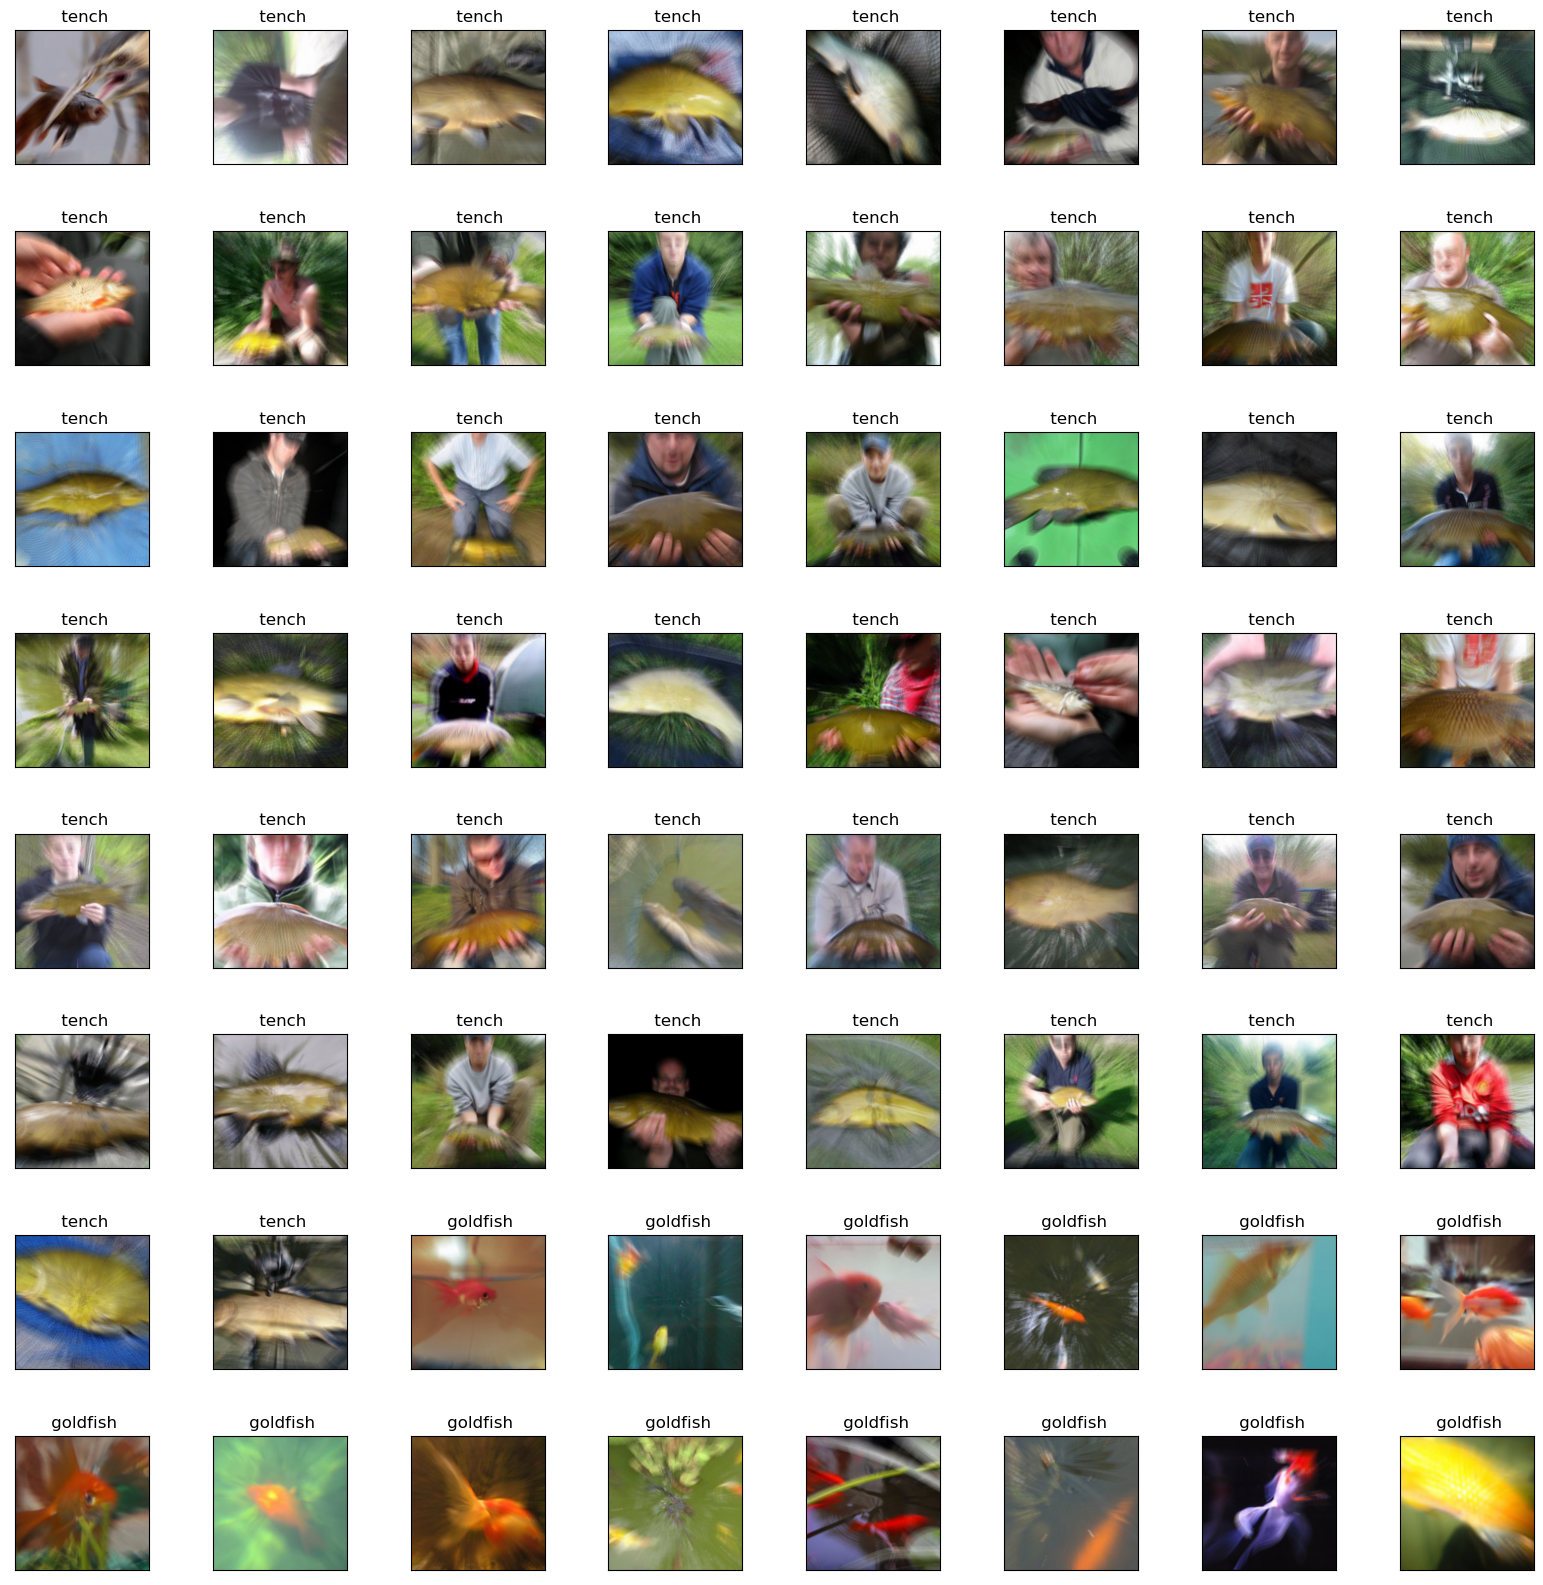

In [6]:
# rand_classes = torch.randperm(1000)[:10]
clean_val_loader = load_imagenet(256,1234,False)
# clean_val_loader128 = load_imagenet(256,1234,False,resize=128)
# clean_val_loader64 = load_imagenet64(256,1234,False)

corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

corr_val_loaders = []
# corr_val_loaders128 = []
# corr_val_loaders64 = []
for corr in corruptions:
    corr_val_loaders.append(load_imagenetc_val(256,1234,corr,severity=3,shuffle=False))
    # corr_val_loaders128.append(load_imagenetc_val(256,1234,corr,severity=3,shuffle=False,resize=128))
    # corr_val_loaders64.append(load_imagenetc64_val(256,1234,corr,severity=1,shuffle=False))
visualize_batch(corr_val_loaders[6])

# Pre-compute embeddings and save to disk

In [7]:
def save_embds(data_loader,file_name,model,embeddings,out_features):
    embds = torch.zeros((len(data_loader.dataset)),out_features)
    labels = torch.zeros(len(data_loader.dataset))
    preds = torch.zeros((len(data_loader.dataset)),1000)

    model.eval()
    with torch.no_grad():
        batch_idx = 0
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')
            start = batch_idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the embeddings
            out = model(img_batch)
            embd = embeddings['emb'].to('cpu')

            embds[start:end] = embd
            labels[start:end] = label_batch
            preds[start:end] = F.softmax(out,dim=1)
            batch_idx += 1
    torch.save([embds,labels,preds],file_name)

## Compute clean embeddings

In [107]:
out_feats = [1024,1280,1280,1280,1280]
for i,m in enumerate(pt_models):
    save_embds(clean_val_loader,"embds/clean224_"+model_names[i]+".pt",m,embedding,out_feats[i])

100%|██████████| 196/196 [04:46<00:00,  1.46s/it]


In [8]:
save_embds(clean_val_loader,"embds/mnv3small_clean224.pt",student,activationS,1024)
save_embds(clean_val_loader,"embds/resnet50_clean224.pt",teacher,activationT,2048)

100%|██████████| 196/196 [04:23<00:00,  1.34s/it]


## Corrupted Embeddings

In [6]:
out_feats = [1024,1280,1280,1280,1280]
for i,dl in enumerate(corr_val_loaders):
    for j,m in enumerate(pt_models):
        save_embds(dl,"embds/sev1corr224_"+corruptions[i]+"_"+model_names[j]+".pt",pt_models[j],embedding,out_feats[j])

100%|██████████| 196/196 [00:21<00:00,  9.14it/s]


In [9]:
for i,dl in enumerate(corr_val_loaders):
    save_embds(dl,"embds/sev3_mnv3small_corr224_" + corruptions[i] + ".pt",student,activationS,1024)
    save_embds(dl,"embds/sev3_resnet50_corr224_" + corruptions[i] + ".pt",teacher,activationT,2048)

100%|██████████| 196/196 [00:32<00:00,  6.10it/s]


# load precomputed embeddings

In [4]:
clean_embds,clean_labels,clean_preds = torch.load("embds/clean224.pt")
clean_embds128,clean_labels128,clean_preds128 = torch.load("embds/clean128.pt")
corr_embds = []
corr_labels = []
corr_preds = []
corr_embds128 = []
corr_labels128 = []
corr_preds128 = []
corr_embds64 = []
corr_labels64 = []
corr_preds64 = []
for i,corr in enumerate(corruptions):
    e,l,p = torch.load("embds/corr224_"+corr+".pt")
    e128,l128,p128 = torch.load("embds/corr128_"+corr+".pt")
    # e64,l64,p64 = torch.load("embds/corr64_"+corr+".pt")
    corr_embds.append(e)
    corr_labels.append(l)
    corr_preds.append(p)
    corr_embds128.append(e128)
    corr_labels128.append(l128)
    corr_preds128.append(p128)
    # corr_embds64.append(e64)
    # corr_labels64.append(l64)
    # corr_preds64.append(p64)

class FC(torch.nn.Module):
    def __init__(self,feats):
      super(FC, self).__init__()
      self.c = torch.nn.Linear(feats,1000)
    def forward(self,x):
      return self.c(x)
fcs = FC(1280).eval()
fct = FC(1280).eval()
with torch.no_grad():
  fcs.c.weight[:,:] = model128.classifier[3].weight[:,:]
  fcs.c.bias[:] = model128.classifier[3].bias[:]
  fct.c.weight[:,:] = model.classifier[3].weight[:,:]
  fct.c.bias[:] = model.classifier[3].bias[:]

: 

In [55]:
inc_idxs = (torch.argmax(clean_preds,dim=1)!=clean_labels).nonzero().view(-1)
print(inc_idxs)
print(torch.argmax(clean_preds[inc_idxs],dim=1))

tensor([    0,     7,    35,  ..., 49994, 49996, 49999])
tensor([133, 758, 394,  ..., 656, 509, 330])


e1: tensor(False)
e2: tensor(True)


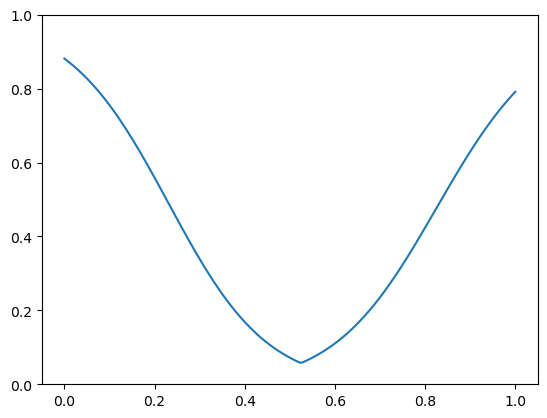

In [112]:
with torch.no_grad():
    n1 = 0
    n2 = 1
    embd1 = clean_embds[n1]
    embd2 = clean_embds[n2]

    alpha = torch.linspace(0,1,200)
    ccs = torch.zeros((len(alpha),1280))
    for i,a in enumerate(alpha):
        ccs[i] = a*embd1+(1-a)*embd2
    cc_confs = torch.max(torch.nn.functional.softmax(fct(ccs),dim=1),dim=1)[0]
    plt.plot(alpha,cc_confs)
    plt.ylim([0,1])
    print("e1:",torch.argmax(clean_preds[n1])==clean_labels[n1])
    print("e2:",torch.argmax(clean_preds[n2])==clean_labels[n2])

# compute predictions and confidences

In [152]:
corr_i = 0
prec_S = torch.zeros(1000)
recall_S = torch.zeros(1000)
prec_T = torch.zeros(1000)
recall_T = torch.zeros(1000)
corr_confs_S,corr_preds_S = torch.max(corr_preds128[corr_i],dim=1)
corr_confs_T,corr_preds_T = torch.max(corr_preds[corr_i],dim=1)
clean_confs_S,clean_preds_S = torch.max(clean_preds128,dim=1)
clean_confs_T,clean_preds_T = torch.max(clean_preds,dim=1)
class_dist_S = torch.zeros(1000)
class_dist_T = torch.zeros(1000)
prec_est = torch.zeros(1000)
recall_est = torch.zeros(1000)
class_conf_S = torch.zeros(1000)
class_conf_T = torch.zeros(1000)
confusion = torch.zeros((1000,1000))
clean_means = torch.zeros((1000,clean_embds128.shape[1]))
corr_means = torch.zeros((1000,corr_embds128[corr_i].shape[1]))
est_corr_means_s = torch.zeros((1000,corr_embds128[corr_i].shape[1]))
est_corr_means_t = torch.zeros((1000,corr_embds128[corr_i].shape[1]))
est_corr_means_st = torch.zeros((1000,corr_embds128[corr_i].shape[1]))
est_corr_means_correct = torch.zeros((1000,corr_embds128[corr_i].shape[1]))
for c in range(1000):
    if len((corr_preds_S==c).nonzero()) > 0:
        prec_S[int(c)] = sum(corr_labels[0][(corr_preds_S==c).nonzero()] == c)/len((corr_preds_S==c).nonzero())
        prec_est[int(c)] = sum(corr_preds_T[(corr_preds_S==c).nonzero()] == c)/len((corr_preds_S==c).nonzero())
        class_conf_S[int(c)] = corr_confs_S[(corr_preds_S==c).nonzero()].mean()
    prec_T[int(c)] = sum(corr_labels[0][(corr_preds_T==c).nonzero()] == c)/len((corr_preds_T==c).nonzero())
    recall_S[int(c)] = sum(corr_preds_S[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())
    recall_T[int(c)] = sum(corr_preds_T[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())
    
    recall_est[int(c)] = sum(corr_preds_S[(corr_preds_T==c).nonzero()] == c)/len((corr_preds_T==c).nonzero())
    class_dist_S[int(c)] = len((corr_preds_S==c).nonzero())/50000
    class_dist_T[int(c)] = len((corr_preds_T==c).nonzero())/50000
    class_conf_T[int(c)] = corr_confs_T[(corr_preds_T==c).nonzero()].mean()

    idxs = (clean_labels == c).nonzero().view(-1)
    est_idxs_s = (corr_preds_S == c).nonzero().view(-1)
    est_idxs_t = (corr_preds_T == c).nonzero().view(-1)
    est_idxs_st = (torch.logical_and((corr_preds_T==c),(corr_preds_S==c))).nonzero().view(-1)
    correct_idxs = (torch.logical_and((corr_preds_S==c),(clean_labels==c))).nonzero().view(-1)
    clean_means[c] = torch.mean(clean_embds128[idxs],dim=0)
    corr_means[c] = torch.mean(corr_embds128[corr_i][idxs],dim=0)
    est_corr_means_s[c] = torch.mean(corr_embds128[corr_i][est_idxs_s],dim=0)
    est_corr_means_t[c] = torch.mean(corr_embds128[corr_i][est_idxs_t],dim=0)
    if len(correct_idxs) > 0:
        est_corr_means_correct[c] = torch.mean(corr_embds128[corr_i][correct_idxs],dim=0)
    if len(est_idxs_st) > 0:
        est_corr_means_st[c] = torch.mean(corr_embds128[corr_i][est_idxs_st],dim=0)
for i in range(50000):
    confusion[corr_preds_S[i],corr_preds_T[i]] += 1

    

In [181]:
emb = torch.clone(corr_embds128[0][50])
emb.requires_grad = True
for i in range(10):
    pred = fcs(emb)
    pred[0].backward()
    with torch.no_grad():
        emb += 0.1*emb.grad

In [182]:
with torch.no_grad():
    print(torch.nn.functional.softmax(fcs(emb),dim=0)[0:5])

tensor([1.0000e+00, 4.1534e-13, 3.0739e-18, 9.4867e-18, 9.4512e-18])


In [185]:
with torch.no_grad():
    print(torch.topk(-torch.cdist(emb.unsqueeze(0),clean_means),5))
    print(torch.cdist(emb.unsqueeze(0),clean_means)[0][0])

torch.return_types.topk(
values=tensor([[-25.6565, -26.1159, -26.3626, -26.5051, -26.6985]]),
indices=tensor([[  1,  29,   5, 314, 124]]))
tensor(27.0237)


tensor([ 0.8700, -0.2588, -0.3038,  ...,  0.1783, -0.1900,  0.0391],
       requires_grad=True)

here we see that after the shift, almost all the shifted class centroids are closer to their original centroids compared to all other original class centroids

how many shifted class centroids are closest to their original class centroid: tensor(989)
what our fc layer classifies clean centroid as: tensor(990)
what our fc layer classifies shifted centroids as: tensor(974)


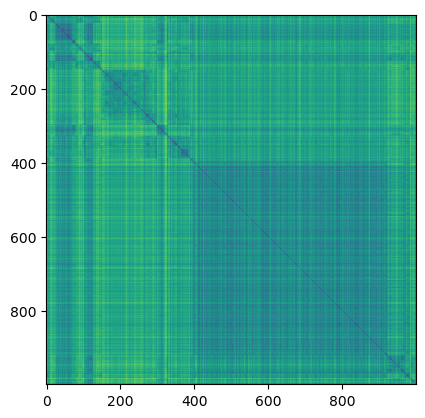

In [134]:
dist_corr_to_clean = torch.cdist(corr_means,clean_means)
print("how many shifted class centroids are closest to their original class centroid:",sum(torch.argmin(dist_corr_to_clean,dim=1) == torch.arange(0,1000)))
print("what our fc layer classifies clean centroid as:",sum(torch.argmax(torch.nn.functional.softmax(fcs(clean_means),dim=1),dim=1) == torch.arange(0,1000)))
print("what our fc layer classifies shifted centroids as:",sum(torch.argmax(torch.nn.functional.softmax(fcs(corr_means),dim=1),dim=1) == torch.arange(0,1000)))
plt.imshow(dist_corr_to_clean)

interestingly after a shift our centroids remain close to their original locations, the reason is that a centroid can't leave its original decision region since all the points that are used to construct it are in the decisoin region, whether this is useful for classification is another question because we can have points from other classes that get shifted into other decision regions

how many shifted class centroids are closest to their original class centroid: tensor(971)
what our fc layer classifies shifted centroids as: tensor(1000)
accuracy for ncm using true shifted mean: tensor(0.4855)
baseline accuracy using confidence: tensor(0.4226)
accuracy for ncm using estimated student shifted mean: tensor(0.3784)
accuracy for ncm using estimated teacher shifted mean: tensor(0.4200)
accuracy for ncm using estimated stud-teach agree shifted mean: tensor(0.4055)
accuracy for ncm using student correct shifted mean: tensor(0.4343)


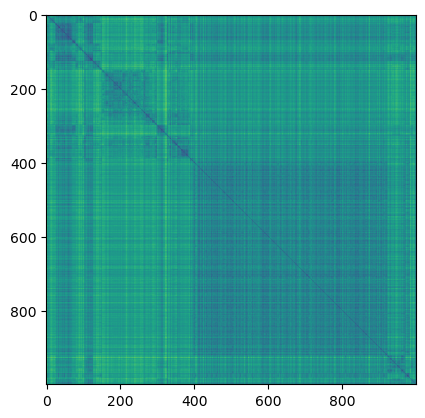

: 

In [208]:
est_dist_corr_to_clean = torch.cdist(est_corr_means_s,clean_means)
print("how many shifted class centroids are closest to their original class centroid:",sum(torch.argmin(est_dist_corr_to_clean,dim=1) == torch.arange(0,1000)))
print("what our fc layer classifies shifted centroids as:",sum(torch.argmax(torch.nn.functional.softmax(fcs(est_corr_means_s),dim=1),dim=1) == torch.arange(0,1000)))
plt.imshow(est_dist_corr_to_clean)

# get the ncm
ncms_s = torch.argmin(torch.cdist(corr_embds128[corr_i],est_corr_means_s),dim=1)
ncms_t = torch.argmin(torch.cdist(corr_embds128[corr_i],est_corr_means_t),dim=1)
ncms_st = torch.argmin(torch.cdist(corr_embds128[corr_i],est_corr_means_st),dim=1)
ncms_correct = torch.argmin(torch.cdist(corr_embds128[corr_i],est_corr_means_correct),dim=1)
ncms_gt = torch.argmin(torch.cdist(corr_embds128[corr_i],corr_means),dim=1)
print("accuracy for ncm using true shifted mean:",sum(ncms_gt == corr_labels[0])/50000)
print("baseline accuracy using confidence:",sum(corr_preds_S==clean_labels)/len(clean_labels))
print("accuracy for ncm using estimated student shifted mean:",sum(ncms_s == corr_labels[0])/50000)
print("accuracy for ncm using estimated teacher shifted mean:",sum(ncms_t == corr_labels[0])/50000)
print("accuracy for ncm using estimated stud-teach agree shifted mean:",sum(ncms_st == corr_labels[0])/50000)
print("accuracy for ncm using student correct shifted mean:",sum(ncms_correct == corr_labels[0])/50000)


In [5]:
# motivation for using matching preds as pseudo labels
preds_S = torch.argmax(corr_preds128[0],dim=1)
preds_T = torch.argmax(corr_preds[0],dim=1)
matched_idxs = (preds_S == preds_T).nonzero()
diff_idxs = (preds_S != preds_T).nonzero()
sum(preds_S[diff_idxs] == corr_labels[0][diff_idxs])/len(diff_idxs)

tensor([0.0955])

In [6]:
rand_i = torch.randperm(len(matched_idxs))[:1000]
match_idxs = matched_idxs.view(-1)[rand_i]

In [7]:
def get_ECE(preds,labels,n_bins=15):
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences, predictions = torch.max(preds,dim=1)
    accuracies = predictions.eq(labels)

    ece = torch.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers,bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

def get_c_dist(preds,n_bins=15):
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences, predictions = torch.max(preds,dim=1)
    conf_dist = torch.zeros(n_bins)
    i = 0
    for bin_lower, bin_upper in zip(bin_lowers,bin_uppers):
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        conf_dist[i] = sum(in_bin)/len(in_bin)
        i += 1
    return conf_dist, (sum(conf_dist*bin_lowers)+sum(conf_dist*bin_uppers))/2

# temp scaling
class Temp(torch.nn.Module):
  def __init__(self):
    super(Temp,self).__init__()
    self.temp = torch.nn.Parameter(torch.ones(1)*1.5)
  def forward(self,logits):
    temp = self.temp.unsqueeze(1).expand(logits.size(0), logits.size(1))
    return logits / temp

# vector scaling
class Vec(torch.nn.Module):
  def __init__(self):
    super(Vec,self).__init__()
    # self.w = torch.nn.Parameter(torch.eye(1000))
    # self.b = torch.nn.Parameter(torch.ones(1000,1))
    self.w = torch.nn.Linear(1000,1000)
  def forward(self,logits):
    return self.w(logits)

temp_scale = Temp().to('cuda')
opt = torch.optim.SGD(temp_scale.parameters(),0.2)
# temp_scale = Vec().to('cuda')
# opt = torch.optim.SGD(temp_scale.parameters(),0.06)
c_i = 0
print("ECE before:",get_ECE(corr_preds128[c_i],corr_labels[c_i]).item())
fcs = fcs.to('cuda')
fct = fct.to('cuda')
with torch.no_grad():
  teach_labels = torch.argmax(corr_preds[c_i],dim=1)[match_idxs]
for i in range(1):
  opt.zero_grad()
  with torch.no_grad():
    logits = fcs(corr_embds128[c_i][match_idxs].to('cuda'))
    # logits = fct(corr_embds[c_i][match_idxs].to('cuda'))
  loss = torch.nn.CrossEntropyLoss()(temp_scale(logits),teach_labels.long().to('cuda'))
  loss.backward()
  opt.step()

with torch.no_grad():
  logits = fcs(corr_embds128[c_i].to('cuda'))
  # logits = fct(corr_embds[c_i].to('cuda'))
  preds = torch.nn.functional.softmax(temp_scale(logits),dim=1).to('cpu')

print("ECE after:",get_ECE(preds,corr_labels[c_i]).item())

ECE before: 0.10753802955150604
ECE after: 0.010760286822915077


In [10]:
from torch.distributions import Categorical
ent_b = Categorical(probs = corr_preds128[c_i]).entropy()
ent_a = Categorical(probs = preds).entropy()
bef_idxs = torch.argsort(ent_b)
aft_idxs = torch.argsort(ent_a)
start = 30000
stop = 35000
print(sum(res[bef_idxs[start:stop]])/(stop-start))
print(sum(res[aft_idxs[start:stop]])/(stop-start))

tensor(0.2446)
tensor(0.2566)


In [108]:
(bef[wrong_idxs]-aft[wrong_idxs]).mean()
(bef[right_idxs]-aft[right_idxs]).mean()

tensor(0.1165)

In [37]:
v,iss = torch.topk(bef[wrong_idxs].view(-1),501)

In [38]:
aft[iss].mean()

tensor(0.4451)

In [11]:
wrong_idxs = (c_preds != corr_labels128[0]).nonzero()
right_idxs = (c_preds == corr_labels128[0]).nonzero()
vals,idxs = torch.topk(bef-aft,30)

In [9]:
bef,c_preds = torch.max(corr_preds128[c_i],dim=1)
aft = torch.max(preds,dim=1)[0]
res = (c_preds == corr_labels[0])
# db = get_c_dist(corr_preds128[c_i],15)
# da = get_c_dist(preds,15)
bef_idxs = torch.argsort(bef)
aft_idxs = torch.argsort(aft)

In [740]:
bef[bef_idxs[1000:1010]]
aft[aft_idxs[1000:1010]]

tensor([0.0591, 0.0591, 0.0592, 0.0592, 0.0592, 0.0592, 0.0592, 0.0592, 0.0592,
        0.0592])

In [768]:
start = 20000
stop = 25000
print(sum(res[bef_idxs[start:stop]])/(stop-start))
print(sum(res[aft_idxs[start:stop]])/(stop-start))

tensor(0.3926)
tensor(0.3816)


In [707]:
vals,idxs = torch.topk(bef,1000)
vals2,idxs2 = torch.topk(aft,1000)
b = torch.argsort(bef)
a = torch.argsort(aft)

In [722]:
r = torch.randperm(50000)[:10]
print(sorted(bef[r]))
print(sorted(aft[r]))
print(res[r][torch.argsort(bef[r])])
print(res[r][torch.argsort(aft[r])])

[tensor(0.2432), tensor(0.3164), tensor(0.3882), tensor(0.3972), tensor(0.5479), tensor(0.6427), tensor(0.8143), tensor(0.8153), tensor(0.9330), tensor(0.9527)]
[tensor(0.1463), tensor(0.2358), tensor(0.2513), tensor(0.2556), tensor(0.3288), tensor(0.5138), tensor(0.6748), tensor(0.6912), tensor(0.7933), tensor(0.8802)]
tensor([False,  True,  True, False,  True, False,  True, False,  True, False])
tensor([False,  True, False,  True,  True, False, False,  True, False,  True])


In [681]:
print(bef[:10])
print(aft[:10])
vals,idxs = torch.topk(aft-bef,1000)
# print(vals)
print(sum(res[idxs]))
print(bef[idxs])

tensor([0.1463, 0.3311, 0.9584, 0.9996, 0.9965, 0.9298, 0.9993, 0.2195, 0.1490,
        0.1212])
tensor([0.0896, 0.1845, 0.8739, 0.9955, 0.9777, 0.8189, 0.9961, 0.1225, 0.0820,
        0.0663])
tensor(994)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.

In [639]:
rand_i = torch.randperm(50000)
# dist_c,avg_c = get_c_dist(preds[rand_i[:200]])
# dist_c2,avg_c2 = get_c_dist(preds[rand_i[200:400]])
# dist,avg = get_c_dist(corr_preds128[c_i][rand_i[:200]])
# dist2,avg2 = get_c_dist(corr_preds128[c_i][rand_i[200:400]])
# dist3,avg3 = get_c_dist(corr_preds128[c_i][rand_i[400:600]])
avg_c1 = torch.max(preds[rand_i[:100]],dim=1)[0].mean()
avg_c2 = torch.max(preds[rand_i[100:200]],dim=1)[0].mean()
avg_c3 = torch.max(preds[rand_i[200:300]],dim=1)[0].mean()
avg_c4 = torch.cat([torch.max(preds[rand_i[300:350]],dim=1)[0],torch.max(corr_preds128[5][rand_i[350:400]],dim=1)[0]]).mean()
avg1 = torch.max(corr_preds128[c_i][rand_i[:100]],dim=1)[0].mean()
avg2 = torch.max(corr_preds128[c_i][rand_i[100:200]],dim=1)[0].mean()
avg3 = torch.max(corr_preds128[c_i][rand_i[200:300]],dim=1)[0].mean()
avg4 = torch.cat([torch.max(corr_preds128[c_i][rand_i[300:350]],dim=1)[0],torch.max(corr_preds128[5][rand_i[350:400]],dim=1)[0]]).mean()
avg5 = torch.max(corr_preds128[5][rand_i[400:500]],dim=1)[0].mean()
# dist_un,avg_un = get_c_dist(corr_preds128[4][rand_i[:200]])

In [640]:
print(avg1,avg2,avg3,avg4,avg5,"mean:",torch.tensor([avg1,avg2,avg3]).mean(),"std:",torch.tensor([avg1,avg2,avg3]).std(),"diff:",abs(avg4-torch.tensor([avg1,avg2,avg3]).mean()),abs(avg5-torch.tensor([avg1,avg2,avg3]).mean()))
print(avg_c1,avg_c2,avg_c3,avg_c4,avg5,"mean:",torch.tensor([avg_c1,avg_c2,avg_c3]).mean(),"std:",torch.tensor([avg_c1,avg_c2,avg_c3]).std(),"diff:",abs(avg_c4-torch.tensor([avg_c1,avg_c2,avg_c3]).mean()),abs(avg5-torch.tensor([avg_c1,avg_c2,avg_c3]).mean()))

tensor(0.5581) tensor(0.5031) tensor(0.5321) tensor(0.5476) tensor(0.5724) mean: tensor(0.5311) std: tensor(0.0275) diff: tensor(0.0165) tensor(0.0413)
tensor(0.4469) tensor(0.3886) tensor(0.4082) tensor(0.4895) tensor(0.5724) mean: tensor(0.4146) std: tensor(0.0297) diff: tensor(0.0750) tensor(0.1578)


In [504]:
abs(avg-avg_un)

tensor(0.0275)

In [481]:
sum(dist*torch.linspace(0,1,15))

tensor(0.5299)

(0.0, 0.5)

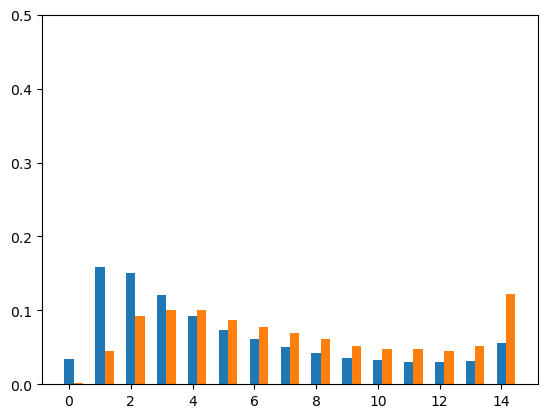

In [646]:
dist_c,avg_c = get_c_dist(preds)
dist_un,avg_un = get_c_dist(corr_preds128[c_i])
plt.bar(np.arange(len(dist_c)),dist_c,width=0.3)
plt.bar(np.arange(len(dist_un))+0.3,dist_un,width=0.3)
plt.ylim([0,0.5])

In [60]:
torch.max(preds,dim=1)[0].mean()

tensor(0.5739)

In [317]:
print(sum(torch.argmax(corr_preds[0],dim=1) == corr_labels[0])/50000)
print(sum(torch.argmax(preds,dim=1) == corr_labels[0])/50000)

tensor(0.6035)
tensor(0.6035)


In [322]:
print(sum(torch.argmax(corr_preds128[0],dim=1) == corr_labels[0])/50000)
print(sum(torch.argmax(preds,dim=1) == corr_labels[0])/50000)

tensor(0.4226)
tensor(0.4226)


In [145]:
teach_cal_preds = preds.clone()

In [147]:
stud_cal_preds = preds.clone()

In [148]:
prec_S = torch.zeros(1000)
recall_S = torch.zeros(1000)
prec_T = torch.zeros(1000)
recall_T = torch.zeros(1000)
preds_S = torch.argmax(stud_cal_preds,dim=1)
preds_T = torch.argmax(teach_cal_preds,dim=1)
class_dist_S = torch.zeros(1000)
class_dist_T = torch.zeros(1000)
prec_est = torch.zeros(1000)
recall_est = torch.zeros(1000)
class_conf_S = torch.zeros(1000)
class_conf_T = torch.zeros(1000)
confusion = torch.zeros((1000,1000))
for c in range(1000):
    if len((preds_S==c).nonzero()) > 0:
        prec_S[int(c)] = sum(corr_labels[0][(preds_S==c).nonzero()] == c)/len((preds_S==c).nonzero())
        prec_est[int(c)] = sum(preds_T[(preds_S==c).nonzero()] == c)/len((preds_S==c).nonzero())
        class_conf_S[int(c)] = torch.max(stud_cal_preds[(preds_S==c).nonzero()],dim=2)[0].mean()
    prec_T[int(c)] = sum(corr_labels[0][(preds_T==c).nonzero()] == c)/len((preds_T==c).nonzero())
    recall_S[int(c)] = sum(preds_S[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())
    recall_T[int(c)] = sum(preds_T[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())
    
    recall_est[int(c)] = sum(preds_S[(preds_T==c).nonzero()] == c)/len((preds_T==c).nonzero())
    class_dist_S[int(c)] = len((preds_S==c).nonzero())/50000
    class_dist_T[int(c)] = len((preds_T==c).nonzero())/50000
    class_conf_T[int(c)] = torch.max(teach_cal_preds[(preds_T==c).nonzero()],dim=2)[0].mean()
for i in range(50000):
    confusion[preds_S[i],preds_T[i]] += 1

In [405]:
ids = rand_i[:500]
t_p = torch.argmax(corr_preds[0],dim=1)[ids]
s_p = torch.argmax(corr_preds128[0],dim=1)[ids]
sum(s_p==t_p)

tensor(227)

In [560]:
import cvxpy as cp

# evaluate policies over different budgets
budgets = torch.linspace(1,11,11)
budgets = torch.linspace(2,5,4)
s_cost = 1
t_cost = 10
min_ss = (s_cost+t_cost-budgets)/t_cost

# store the avg accuracy and cost for each policy
acc_cp = []
acc_op = []
cost_cp = []
cost_op = []

# shared variables
n_bins = 30
bin_boundaries = torch.linspace(0, 1, n_bins+1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_marks = torch.cat([bin_lowers,bin_uppers[-1].unsqueeze(0)])
c = [0,1,2]
stud_confs_orig, stud_preds_orig = torch.max(corr_preds128[c[0]],dim=1)
teach_confs_orig, teach_preds_orig = torch.max(corr_preds[c[0]],dim=1)
for c_i in c[1:]:
    stud_confs_orig_, stud_preds_orig_ = torch.max(corr_preds128[c_i],dim=1)
    teach_confs_orig_, teach_preds_orig_ = torch.max(corr_preds[c_i],dim=1)
    stud_confs_orig = torch.cat([stud_confs_orig,stud_confs_orig_])
    stud_preds_orig = torch.cat([stud_preds_orig,stud_preds_orig_])
    teach_confs_orig = torch.cat([teach_confs_orig,teach_confs_orig_])
    teach_preds_orig = torch.cat([teach_preds_orig,teach_preds_orig_])

rand_i = torch.cat([torch.randperm(50000),torch.randperm(50000)+50000,torch.randperm(50000)+100000])

# iterate over min student usages
for min_s in min_ss:
    # ============== init confidence policy ============== #
    conf_bins_cp = torch.zeros(n_bins)
    conf_counts_cp = 0
    overall_preds_cp = torch.zeros(150000)
    overall_cost_cp = 0
    avg_conf_window_cp = torch.zeros(20)
    avg_conf_cp = 0.5


    # ============== init other policy ============== #
    conf_bins_op = torch.zeros(n_bins)
    conf_counts_op = 0
    conf_bins_op_t = torch.zeros(n_bins)
    conf_counts_op_t = 0
    avg_bin_confs_op = torch.zeros(n_bins)
    avg_bin_confs_op_t= torch.zeros(n_bins)
    avg_bin_confs_counts_op = torch.zeros(n_bins)
    avg_conf_window_op = torch.zeros(5)
    avg_conf_op = 0.5

    # need to clone these because will overwrite
    stud_confs_op = stud_confs_orig.clone()
    teach_confs_op = teach_confs_orig.clone()

    temp_scale_s = Temp()
    temp_scale_t = Temp()
    opt_s = torch.optim.SGD(temp_scale_s.parameters(),0.2)
    opt_t = torch.optim.SGD(temp_scale_t.parameters(),0.26)
    opt_s.zero_grad()
    opt_t.zero_grad()
    
    print("S ECE before:",get_ECE(corr_preds128[c_i],corr_labels[c_i]).item())
    print("T ECE before:",get_ECE(corr_preds[c_i],corr_labels[c_i]).item())
    fcs = fcs.to('cpu')
    fct = fct.to('cpu')
    overall_preds_op = torch.zeros(150000)
    overall_cost_op = 0
    
    swap = False
    match_count = 0

    pred_idx = 0
    bin_policy = None
    rand_thresh = 0.1
    # ============== start executing policies ==============
    for id in tqdm(rand_i):
        # ============== execute confidence policy ============== #
        # update confidence distribution
        bin_cp = torch.logical_and(stud_confs_orig[id] > bin_lowers,stud_confs_orig[id] <= bin_uppers).nonzero()
        conf_bins_cp*=conf_counts_cp
        conf_bins_cp[bin_cp] += 1
        conf_counts_cp += 1
        conf_bins_cp /= conf_counts_cp
        overall_cost_cp += s_cost

        # get the ccdf to get the threshold
        conf_ccdf_cp = torch.tensor([sum(conf_bins_cp[len(conf_bins_cp)-i:len(conf_bins_cp)]) for i in range(len(conf_bins_cp)+1)])
        conf_ccdf_cp[-1] = 1.0
        bin_thresh_cp = n_bins - (conf_ccdf_cp >= min_s).nonzero().view(-1).min()
        threshold_cp = bin_marks[bin_thresh_cp]

        # make selection
        if stud_confs_orig[id] >= threshold_cp:
            overall_preds_cp[pred_idx] = stud_preds_orig[id] # choose student
        else:
            overall_preds_cp[pred_idx] = teach_preds_orig[id] # choose teacher
            overall_cost_cp += t_cost

        # check if dist shift
        if sum(avg_conf_window_cp == 0) == 0:
            std = torch.std(avg_conf_window_cp)
            if stud_confs_orig[id]
        avg_conf_cp = 0.95*avg_conf_cp+0.05*stud_confs_orig[id]
        avg_conf_window_cp[1:] = avg_conf_window_cp[:-1]
        avg_conf_window_cp[0] = avg_conf_cp
        

        
        # ============== execute other policy ============== #
        # update student confidence dist
        bin_op = torch.logical_and(stud_confs_op[id] > bin_lowers,stud_confs_op[id] <= bin_uppers).nonzero()
        conf_bins_op*=conf_counts_op
        conf_bins_op[bin_op] += 1
        conf_counts_op += 1
        conf_bins_op /= conf_counts_op
        overall_cost_op += s_cost

        conf_ccdf_op = torch.tensor([sum(conf_bins_op[len(conf_bins_op)-i:len(conf_bins_op)]) for i in range(len(conf_bins_op)+1)])
        conf_ccdf_op[-1] = 1.0
        bin_thresh_op = n_bins - (conf_ccdf_op >= min_s).nonzero().view(-1).min()
        threshold_op = bin_marks[bin_thresh_op]
        # policy update
        if bin_policy is not None:
            # print(bin_policy)
            rand_thresh = 0.0
            if bin_policy[bin_op] == 1:
                threshold_op = 0 # choose student
            else:
                threshold_op = 1 # choose teacher
        # if above thresh
        if stud_confs_op[id] >= threshold_op:
            # exploration, get teacher pred
            if swap == False and torch.rand(1) < rand_thresh:
                swap = True
                # update teacher confidence distribution
                bin_op = torch.logical_and(teach_confs_op[id] > bin_lowers,teach_confs_op[id] <= bin_uppers).nonzero()
                conf_bins_op_t*=conf_counts_op_t
                conf_bins_op_t[bin_op] += 1
                conf_counts_op_t += 1
                conf_bins_op_t /= conf_counts_op_t

                # update avg bin confidences after calibration
                if match_count >= 50:
                    bin_op = torch.logical_and(stud_confs_op[id] > bin_lowers,stud_confs_op[id] <= bin_uppers).nonzero()
                    avg_bin_confs_op[bin_op] *= avg_bin_confs_counts_op[bin_op]
                    avg_bin_confs_op[bin_op] += stud_confs_op[id]
                    avg_bin_confs_op_t[bin_op] *= avg_bin_confs_counts_op[bin_op]
                    avg_bin_confs_op_t[bin_op] += teach_confs_op[id]
                    avg_bin_confs_counts_op[bin_op] += 1
                    avg_bin_confs_op[bin_op] /= avg_bin_confs_counts_op[bin_op]
                    avg_bin_confs_op_t[bin_op] /= avg_bin_confs_counts_op[bin_op]

                    # update the policy
                    if pred_idx > 3000:
                        x_csb = cp.Variable(len(avg_bin_confs_op), boolean = True)
                        x_ctb = cp.Variable(len(avg_bin_confs_op), boolean = True)
                        ones_vec = np.ones(len(avg_bin_confs_op))
                        constraints = []
                        budget = s_cost+t_cost-min_s*t_cost
                        constraints = [x_csb + x_ctb == ones_vec, s_cost*x_csb.T@conf_bins_op + (s_cost+t_cost)*x_ctb.T@conf_bins_op <= budget]
                        acc = x_csb.T@(avg_bin_confs_op*conf_bins_op) + x_ctb.T@(avg_bin_confs_op_t*conf_bins_op)
                        problem = cp.Problem(cp.Maximize(acc), constraints)
                        problem.solve(verbose=False)
                        bin_policy = x_csb.value

                # make prediction
                overall_preds_op[pred_idx] = teach_preds_orig[id]
                overall_cost_op += t_cost
                # check if matches
                if (stud_preds_orig[id] == teach_preds_orig[id]) and match_count < 50:
                    # print(match_count,pred_idx)
                    match_count += 1
                    with torch.no_grad():
                        s_logit = fcs(corr_embds128[c_i][id])
                        t_logit = fct(corr_embds[c_i][id])
                    loss_s = torch.nn.CrossEntropyLoss()(temp_scale_s(s_logit.unsqueeze(0)),teach_preds_orig[id].long().unsqueeze(0))/50
                    loss_t = torch.nn.CrossEntropyLoss()(temp_scale_t(t_logit.unsqueeze(0)),teach_preds_orig[id].long().unsqueeze(0))/50
                    loss_s.backward()
                    loss_t.backward()
                    if match_count == 50:
                        print("hit 100 mathces at idx = ",pred_idx)
                        opt_s.step()
                        opt_t.step()
                        with torch.no_grad():
                            logits_s = fcs(corr_embds128[c_i])
                            logits_t = fct(corr_embds[c_i])
                            stud_confs_op = torch.max(torch.nn.functional.softmax(temp_scale_s(logits_s),dim=1),dim=1)[0]
                            teach_confs_op = torch.max(torch.nn.functional.softmax(temp_scale_t(logits_t),dim=1),dim=1)[0]
                            # print("S ECE atfer:",get_ECE(stud_preds,corr_labels[c_i]).item())
                            # print("T ECE after:",get_ECE(teach_preds,corr_labels[c_i]).item())
                            # reset bins
                            conf_bins_op = torch.zeros(n_bins)
                            conf_counts_op = 0
                            conf_bins_op_t = torch.zeros(n_bins)
                            conf_counts_op_t = 0
                        # swap = None
            else:
                overall_preds_op[pred_idx] = stud_preds_orig[id]
        else:
            if swap == True:
                overall_preds_op[pred_idx] = stud_preds_orig[id]
                swap = False
            else:
                # update teacher confidence distribution
                bin_op = torch.logical_and(teach_confs_op[id] > bin_lowers,teach_confs_op[id] <= bin_uppers).nonzero()
                conf_bins_op_t*=conf_counts_op_t
                conf_bins_op_t[bin_op] += 1
                conf_counts_op_t += 1
                conf_bins_op_t /= conf_counts_op_t

                # update avg bin confidences after calibration
                if match_count >= 50:
                    bin_op = torch.logical_and(stud_confs_op[id] > bin_lowers,stud_confs_op[id] <= bin_uppers).nonzero()
                    avg_bin_confs_op[bin_op] *= avg_bin_confs_counts_op[bin_op]
                    avg_bin_confs_op[bin_op] += stud_confs_op[id]
                    avg_bin_confs_op_t[bin_op] *= avg_bin_confs_counts_op[bin_op]
                    avg_bin_confs_op_t[bin_op] += teach_confs_op[id]
                    avg_bin_confs_counts_op[bin_op] += 1
                    avg_bin_confs_op[bin_op] /= avg_bin_confs_counts_op[bin_op]
                    avg_bin_confs_op_t[bin_op] /= avg_bin_confs_counts_op[bin_op]

                    # update the policy
                    if pred_idx > 3000:
                        x_csb = cp.Variable(len(avg_bin_confs_op), boolean = True)
                        x_ctb = cp.Variable(len(avg_bin_confs_op), boolean = True)
                        ones_vec = np.ones(len(avg_bin_confs_op))
                        constraints = []
                        budget = s_cost+t_cost-min_s*t_cost
                        constraints = [x_csb + x_ctb == ones_vec, s_cost*x_csb.T@conf_bins_op + (s_cost+t_cost)*x_ctb.T@conf_bins_op <= budget]
                        acc = x_csb.T@(avg_bin_confs_op*conf_bins_op) + x_ctb.T@(avg_bin_confs_op_t*conf_bins_op)
                        problem = cp.Problem(cp.Maximize(acc), constraints)
                        problem.solve(verbose=False)
                        bin_policy = x_csb.value
                # make prediction
                overall_preds_op[pred_idx] = teach_preds_orig[id]
                overall_cost_op += t_cost
                # check if matches
                if (stud_preds_orig[id] == teach_preds_orig[id]) and match_count < 50:
                    # print(match_count,pred_idx)
                    match_count += 1
                    with torch.no_grad():
                        s_logit = fcs(corr_embds128[c_i][id])
                        t_logit = fct(corr_embds[c_i][id])
                    loss_s = torch.nn.CrossEntropyLoss()(temp_scale_s(s_logit.unsqueeze(0)),teach_preds_orig[id].long().unsqueeze(0))/50
                    loss_t = torch.nn.CrossEntropyLoss()(temp_scale_t(t_logit.unsqueeze(0)),teach_preds_orig[id].long().unsqueeze(0))/50
                    loss_s.backward()
                    loss_t.backward()
                    if match_count == 50:
                        print("hit 100 mathces at idx = ",pred_idx)
                        opt_s.step()
                        opt_t.step()
                        with torch.no_grad():
                            logits_s = fcs(corr_embds128[c_i])
                            logits_t = fct(corr_embds[c_i])
                            stud_confs_op = torch.max(torch.nn.functional.softmax(temp_scale_s(logits_s),dim=1),dim=1)[0]
                            teach_confs_op = torch.max(torch.nn.functional.softmax(temp_scale_t(logits_t),dim=1),dim=1)[0]
                            # print("S ECE atfer:",get_ECE(stud_preds,corr_labels[c_i]).item())
                            # print("T ECE after:",get_ECE(teach_preds,corr_labels[c_i]).item())
                            # reset bins
                            conf_bins_op = torch.zeros(n_bins)
                            conf_counts_op = 0
                            conf_bins_op_t = torch.zeros(n_bins)
                            conf_counts_op_t = 0
        pred_idx += 1
    acc_cp.append(sum(overall_preds_cp == corr_labels[0][rand_i])/50000)
    acc_op.append(sum(overall_preds_op == corr_labels[0][rand_i])/50000)
    cost_cp.append(overall_cost_cp/50000)
    cost_op.append(overall_cost_op/50000)

S ECE before: 0.08012184500694275
T ECE before: 0.17522040009498596


  3%|▎         | 1539/50000 [00:03<01:39, 487.04it/s]

hit 100 mathces at idx =  1574


100%|██████████| 50000/50000 [02:11<00:00, 379.53it/s]


S ECE before: 0.08012184500694275
T ECE before: 0.17522040009498596


  2%|▏         | 772/50000 [00:01<01:49, 449.44it/s]

hit 100 mathces at idx =  781


100%|██████████| 50000/50000 [03:22<00:00, 247.09it/s]


S ECE before: 0.08012184500694275
T ECE before: 0.17522040009498596


  1%|          | 486/50000 [00:01<01:49, 453.80it/s]

hit 100 mathces at idx =  528


100%|██████████| 50000/50000 [03:03<00:00, 273.17it/s]


S ECE before: 0.08012184500694275
T ECE before: 0.17522040009498596


  1%|          | 394/50000 [00:00<01:51, 444.13it/s]

hit 100 mathces at idx =  437


100%|██████████| 50000/50000 [03:37<00:00, 229.66it/s]


In [561]:
print(bin_policy)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [563]:
overall_preds_cp

tensor([665., 473., 877.,  ..., 404., 790., 126.])

In [567]:
sum((overall_preds_op == overall_preds_cp)[3000:])

tensor(45486)

(0.3, 0.7)

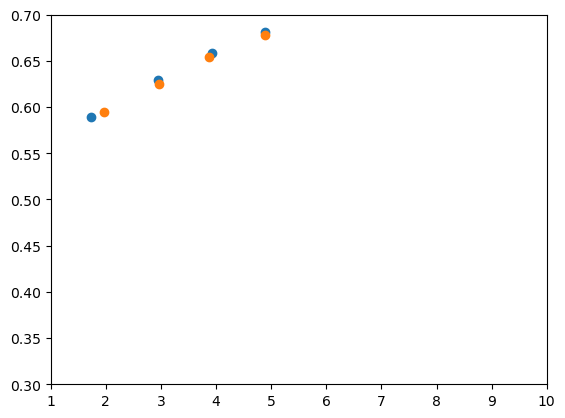

In [562]:
plt.scatter(cost_cp,acc_cp)
plt.scatter(cost_op,acc_op)
plt.xlim([1,10])
plt.ylim([0.3,0.7])

In [335]:
overall_preds_cp

tensor([885., 188., 808.,  ..., 199., 403., 763.])

100%|██████████| 49999/49999 [00:00<00:00, 81331.54it/s]


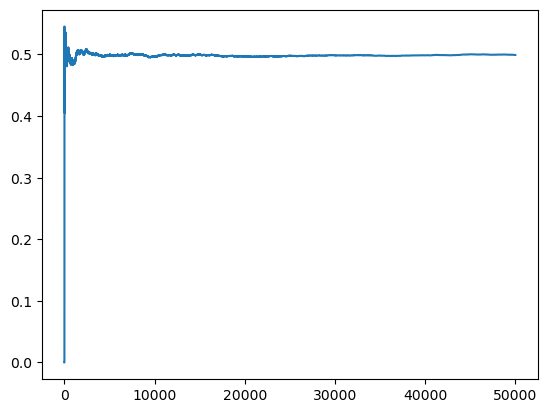

In [338]:
avg_acc = torch.zeros(50000)
res = (overall_preds_op == corr_labels[0][rand_i])
counts = 1
avg_acc[0] = res[0]
for i in tqdm(range(1,50000)):
    avg_acc[i] = (avg_acc[i-1]*counts+res[i])/(counts+1)
    counts += 1
plt.plot(avg_acc)

In [703]:
confidences, predictions = torch.max(stud_cal_preds,dim=1)
confidences_t, predictions_t = torch.max(teach_cal_preds,dim=1)
class_confs = torch.zeros(1000)
class_confs_t = torch.zeros(1000)
for c in range(1000):
    class_confs[c] = confidences[predictions==c].mean()
    class_confs_t[c] = confidences_t[predictions==c].mean()

In [687]:
print(class_confs[:10])
print(class_confs_t[:10])

tensor([0.7328, 0.5033, 0.5788, 0.6320, 0.5354, 0.5375, 0.4113, 0.5917, 0.5972,
        0.7531])
tensor([0.8358, 0.6438, 0.6309, 0.6271, 0.6458, 0.6756, 0.4508, 0.7104, 0.6949,
        0.8299])


In [299]:
bin_boundaries = torch.linspace(0, 1, 30 + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
conf_bins = torch.zeros(30)
conf_bins_t = torch.zeros(30)
conf_dist = torch.zeros(30)
conf_dist_t = torch.zeros(30)
acts_s = torch.zeros(30)
acts_t = torch.zeros(30)

confidences, predictions = torch.max(stud_cal_preds,dim=1)
confidences_t, predictions_t = torch.max(teach_cal_preds,dim=1)
i = 0
for bin_lower, bin_upper in zip(bin_lowers,bin_uppers):
    in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
    prop_in_bin = in_bin.float().mean()
    if prop_in_bin.item() > 0:
        conf_bins[i] = confidences[in_bin].mean()
        conf_bins_t[i] = confidences_t[in_bin].mean()
        conf_dist[i] = sum(in_bin)/50000
        acts_s[i] = (predictions[in_bin]==corr_labels[0][in_bin]).float().mean()
        acts_t[i] = (predictions_t[in_bin]==corr_labels[0][in_bin]).float().mean()
    i += 1

In [300]:
print(conf_bins)
print(acts_s)
print(conf_bins_t)
print(acts_t)
print(conf_dist)

tensor([0.0294, 0.0548, 0.0843, 0.1168, 0.1500, 0.1831, 0.2162, 0.2498, 0.2829,
        0.3164, 0.3498, 0.3830, 0.4165, 0.4499, 0.4830, 0.5162, 0.5495, 0.5830,
        0.6169, 0.6491, 0.6837, 0.7166, 0.7494, 0.7831, 0.8163, 0.8498, 0.8834,
        0.9167, 0.9511, 0.9884])
tensor([0.0769, 0.0619, 0.0924, 0.1203, 0.1656, 0.2027, 0.2464, 0.2635, 0.2956,
        0.3518, 0.3791, 0.4303, 0.4403, 0.4855, 0.5155, 0.5285, 0.5757, 0.6120,
        0.6477, 0.6942, 0.6855, 0.7331, 0.7598, 0.7889, 0.8287, 0.8561, 0.8860,
        0.9206, 0.9463, 0.9810])
tensor([0.2894, 0.3783, 0.4125, 0.4418, 0.4655, 0.5013, 0.5159, 0.5250, 0.5422,
        0.5659, 0.5802, 0.5995, 0.6062, 0.6290, 0.6337, 0.6503, 0.6753, 0.6811,
        0.6959, 0.6949, 0.7161, 0.7371, 0.7545, 0.7736, 0.7940, 0.8023, 0.8404,
        0.8493, 0.8866, 0.9242])
tensor([0.3846, 0.3540, 0.3940, 0.4210, 0.4577, 0.5058, 0.5075, 0.5249, 0.5580,
        0.5861, 0.5932, 0.6230, 0.6205, 0.6544, 0.6470, 0.6745, 0.7248, 0.7109,
        0.7212, 0.735

In [301]:
import cvxpy as cp
x_sb = conf_bins.numpy()
x_tb = conf_bins_t.numpy()
x_d = conf_dist.numpy()

budgets = torch.linspace(1,11,11)
s_cost = 1
t_cost = 10
accs = []
for budget in tqdm(budgets):
    x_csb = cp.Variable(len(x_sb), boolean = True)
    x_ctb = cp.Variable(len(x_sb), boolean = True)
    ones_vec = np.ones(len(x_sb))

    constraints = []
    constraints = [x_csb + x_ctb == ones_vec, s_cost*x_csb.T@x_d + (s_cost+t_cost)*x_ctb.T@x_d <= budget]
    acc = x_csb.T@(x_sb*x_d) + x_ctb.T@(x_tb*x_d)

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve(verbose=False)
    accs.append(problem.value)
    print(x_csb.value)
    print("status:", problem.status)
    print("result:",problem.value)

100%|██████████| 11/11 [00:00<00:00, 163.46it/s]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
status: optimal
result: 0.47134713072773593
[1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
status: optimal
result: 0.5036071027952858
[0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
status: optimal
result: 0.5324245055089705
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
status: optimal
result: 0.5625339347752742
[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
status: optimal
result: 0.5895851735840552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
status: optimal
result: 0.6140214187907986
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
status: optimal
result: 0.6306035036104731
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [266]:
bins = torch.linspace(0.05, .95, 19)
est_t_c = []
est_s_c = []
act_t_c = []
act_s_c = []
est_ov_c = []
act_ov_c = []
for i,thresh in enumerate(bins):
    low_conf_idxs = (torch.max(stud_cal_preds,dim=1)[0] < thresh).nonzero().view(-1)
    high_conf_idxs = (torch.max(stud_cal_preds,dim=1)[0] > thresh).nonzero().view(-1)
    est_t_c.append((torch.max(teach_cal_preds,dim=1)[0][low_conf_idxs]).mean())
    est_s_c.append((torch.max(stud_cal_preds,dim=1)[0][high_conf_idxs]).mean())
    act_t_c.append(((torch.argmax(teach_cal_preds,dim=1)[low_conf_idxs]) == corr_labels[0][low_conf_idxs]).float().mean())
    act_s_c.append(((torch.argmax(stud_cal_preds,dim=1)[high_conf_idxs]) == corr_labels[0][high_conf_idxs]).float().mean())
    est_ov_c.append(est_s_c[i]*(len(high_conf_idxs)/50000) + est_t_c[i]*(len(low_conf_idxs)/50000))
    act_ov_c.append(act_s_c[i]*(len(high_conf_idxs)/50000) + act_t_c[i]*(len(low_conf_idxs)/50000))

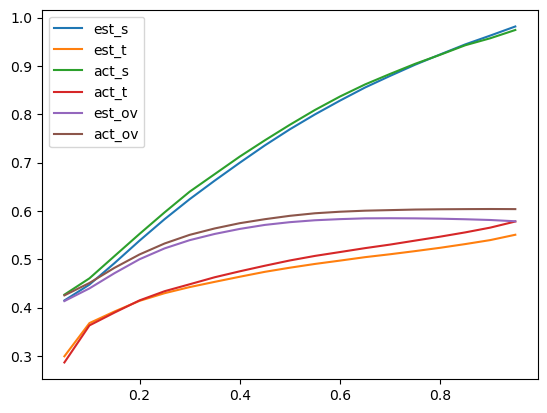

In [267]:
plt.plot(bins,est_s_c,label="est_s")
plt.plot(bins,est_t_c,label="est_t")
plt.plot(bins,act_s_c,label="act_s")
plt.plot(bins,act_t_c,label="act_t")
plt.plot(bins,est_ov_c,label="est_ov")
plt.plot(bins,act_ov_c,label="act_ov")
plt.legend()

In [234]:
print((torch.max(teach_cal_preds,dim=1)[0])[20:30])
print(torch.argmax(teach_cal_preds,dim=1)[20:30] == corr_labels[0][20:30])
print((torch.max(stud_cal_preds,dim=1)[0])[20:30])
print(torch.argmax(stud_cal_preds,dim=1)[20:30] == corr_labels[0][20:30])

tensor([0.9637, 0.2321, 0.9259, 0.9018, 0.1996, 0.9587, 0.9668, 0.8634, 0.9373,
        0.5144])
tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True])
tensor([0.7093, 0.9157, 0.9997, 0.7055, 0.0961, 0.6398, 0.9435, 0.8354, 0.9382,
        0.2750])
tensor([ True,  True,  True,  True, False,  True,  True,  True,  True, False])


In [77]:
teach_confs.mean()

tensor(0.5657)

In [97]:
conf_counts_t == len(overall_preds_t)

True

In [133]:
print("stud_acc:",(sum(conf_bins*bin_lowers)+ sum(conf_bins*bin_uppers))/2)
print("teach_acc:",(sum(conf_bins_t*bin_lowers)+ sum(conf_bins_t*bin_uppers))/2)

stud_acc: tensor(0.4142)
teach_acc: tensor(0.5605)


In [134]:
sum(torch.tensor(overall_preds_t))/len(overall_preds_t)

tensor(0.5294)

In [149]:
torch.topk(class_conf_T-class_conf_S,10)

torch.return_types.topk(
values=tensor([0.4037, 0.3821, 0.3708, 0.3598, 0.3555, 0.3524, 0.3446, 0.3352, 0.3323,
        0.3304]),
indices=tensor([490, 889, 420, 813, 791, 769, 514, 882, 853, 971]))

In [152]:
torch.topk(class_conf_S-class_conf_T,10)

torch.return_types.topk(
values=tensor([0.0712, 0.0695, 0.0651, 0.0477, 0.0363, 0.0275, 0.0187, 0.0183, 0.0164,
        0.0120]),
indices=tensor([607, 961, 959, 780, 933, 190, 809, 578, 623, 685]))

In [151]:
torch.argmax(stud_cal_preds,dim=1)

tensor([[8.2012e-05, 8.3031e-05, 1.4745e-04,  ..., 6.0881e-05, 2.0530e-05,
         6.9560e-05],
        [1.7554e-02, 3.0912e-03, 9.7187e-05,  ..., 1.9540e-04, 1.1620e-05,
         5.6672e-05],
        [8.7370e-01, 4.1389e-06, 3.3027e-06,  ..., 3.3305e-05, 1.2698e-06,
         2.2976e-07],
        ...,
        [7.1798e-07, 1.7144e-05, 2.6536e-06,  ..., 1.0895e-05, 2.8633e-05,
         3.7629e-03],
        [1.6672e-05, 2.1486e-05, 9.8508e-04,  ..., 6.2396e-05, 1.3954e-05,
         1.3406e-03],
        [2.8041e-04, 6.7461e-06, 4.6886e-06,  ..., 6.3242e-04, 2.7020e-04,
         1.2242e-03]])

In [220]:
ids = (torch.argmax(stud_cal_preds,dim=1) == 381).nonzero().view(-1)
print("stud_conf:",(torch.max(stud_cal_preds,dim=1)[0][ids]).mean())
print("stud_acc:",sum(torch.argmax(stud_cal_preds,dim=1)[ids] == corr_labels[0][ids])/len(ids))
print("teach_conf:",(torch.max(teach_cal_preds,dim=1)[0][ids]).mean())
print("teach_acc:",sum(torch.argmax(teach_cal_preds,dim=1)[ids] == corr_labels[0][ids])/len(ids))

stud_conf: tensor(0.2916)
stud_acc: tensor(0.2581)
teach_conf: tensor(0.4888)
teach_acc: tensor(0.3548)


In [190]:
c = 124
vals, idxs = torch.topk(confusion[c],3)
print(class_conf_S[c])
print(class_conf_T[idxs[0]])

tensor(0.2283)
tensor(0.5998)


In [ ]:
(torch.argmax(confusion,dim=1) != torch.arange(0,1000)).nonzero()

In [861]:
sum(label_batch==0)/len(label_batch)

tensor(0.5781)

: 

In [860]:
sum(torch.argmax(out,dim=1) == label_batch)/len(label_batch)

tensor(0.6094)

In [113]:
sum(label_batch)/len(label_batch)

tensor(0.4531)

In [9]:
from sklearn import svm
clf = svm.SVC(kernel="rbf")
X_train = corr_embds[0][rand_idxs[:200]]
Y_train = (predictions[rand_idxs[:200]] == corr_labels[0][rand_idxs[:200]])
X_test = corr_embds[0][rand_idxs[200:400]]
Y_test = (predictions[rand_idxs[200:400]] == corr_labels[0][rand_idxs[200:400]])
clf.fit(X_train,Y_train)

SVC()

In [14]:
pred = clf.predict(X_test)
sum(torch.tensor(pred).float() == Y_test)/(len(Y_test))

tensor(0.6100)

In [17]:
sum(Y_test==1)/len(Y_test)

tensor(0.6100)

In [6]:
rand_idxs = torch.randperm(50000)

In [49]:
import copy

100%|██████████| 400/400 [00:01<00:00, 317.26it/s]


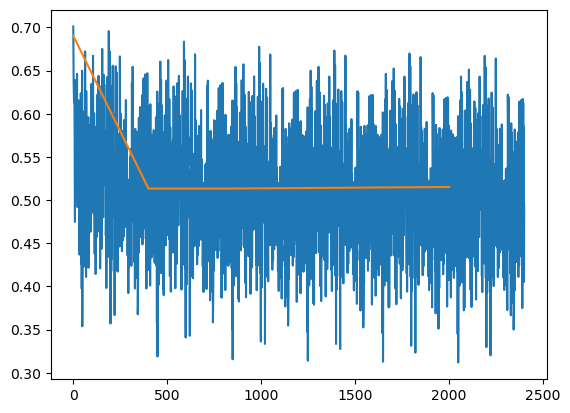

In [128]:
class Dec(torch.nn.Module):
  def __init__(self,feats):
     super(Dec,self).__init__()
     self.fc1 = torch.nn.Linear(feats,1000)
    #  self.fc2 = torch.nn.Linear(512,256)
    #  self.fc3 = torch.nn.Linear(256,128)
    #  self.fc4 = torch.nn.Linear(128,64)
     self.fc5 = torch.nn.Linear(1000,2)
     self.do = torch.nn.Dropout(p=0.5)
  def forward(self,x):
    # return self.fc1(x)
    x = self.fc1(x)
    # x = self.do(F.relu(self.fc2(x)))
    # x = self.do(F.relu(self.fc3(x)))
    # x = self.do(F.relu(self.fc4(x)))
    return self.fc5(x)
dec = Dec(1280)
opt = torch.optim.SGD(dec.parameters(),lr=0.05,momentum=0.4,weight_decay=0.0004)
# dec = copy.deepcopy(fcs)
# opt = torch.optim.SGD(dec.parameters(),lr=0.05,momentum=0.4,weight_decay=0.0004)

rand_idxs = torch.randperm(50000)
b_size = 64
num_train_batches = 400
criterion = torch.nn.CrossEntropyLoss()
confidences, predictions = torch.max(clean_preds,dim=1)#torch.max(corr_preds128[0],dim=1)
losses = []
vals = []
val_iters = []
val_accs = []
iters = 0

for e in range(6):
  with torch.no_grad():
    zs = 0
    ons = 0
    confusion = torch.zeros((2,2))
    val_loss = 0
    dec.eval()
    correct = 0
    for j in range(num_train_batches,750):
      batch_idxs = rand_idxs[j*b_size:j*b_size+b_size]
      emb_batch = clean_embds[batch_idxs]#corr_embds128[0][batch_idxs]
      label_batch = (predictions[batch_idxs] != clean_labels128[batch_idxs]).long()#corr_labels[0][batch_idxs].long()
      # label_batch = (predictions[batch_idxs] != corr_labels[0][batch_idxs]).long()
      out = dec(emb_batch)
      correct += sum(torch.argmax(out,dim=1) == label_batch)
      # print(out.shape,label_batch.shape)
      val_loss += criterion(out,label_batch)
      for p,t in zip(torch.argmax(out,dim=1),label_batch):
        confusion[p,t] += 1
      zs += sum(label_batch==0)
      ons += sum(label_batch==1)
    vals.append(val_loss/350)
    val_iters.append(iters)
    val_accs.append(correct/(b_size*350))
  dec.train()
  for i in tqdm(range(num_train_batches)):
      batch_idxs = rand_idxs[i*b_size:i*b_size+b_size]
      emb_batch = clean_embds[batch_idxs]#corr_embds128[0][batch_idxs]
      # label_batch = (predictions[batch_idxs] != corr_labels[0][batch_idxs]).long()
      label_batch = (predictions[batch_idxs] != clean_labels128[batch_idxs]).long()#corr_labels[0][batch_idxs].long()
      out = dec(emb_batch)
      # print(out.shape,label_batch.shape)
      loss = criterion(out,label_batch)
      loss.backward()
      opt.step()
      opt.zero_grad()
      with torch.no_grad():
          losses.append(loss.detach())
      iters += 1
  
plt.plot(losses)
plt.plot(val_iters,vals)

In [39]:
sum(torch.argmax(out,dim=1) == label_batch)/len(label_batch)

tensor(0.7109)

In [129]:
confusion

tensor([[15996.,  4604.],
        [  934.,   866.]])

In [119]:
val_accs

[tensor(0.4792),
 tensor(0.7512),
 tensor(0.7504),
 tensor(0.7501),
 tensor(0.7496),
 tensor(0.7498)]

In [146]:
prec_S = torch.zeros(1000)
recall_S = torch.zeros(1000)
prec_T = torch.zeros(1000)
recall_T = torch.zeros(1000)
preds_S = torch.argmax(clean_preds128,dim=1)
preds_T = torch.argmax(clean_preds,dim=1)
class_dist_S = torch.zeros(1000)
class_dist_T = torch.zeros(1000)
prec_est = torch.zeros(1000)
recall_est = torch.zeros(1000)
class_conf_S = torch.zeros(1000)
class_conf_T = torch.zeros(1000)
confusion = torch.zeros((1000,1000))
for c in range(1000):
    if len((preds_S==c).nonzero()) > 0:
        prec_S[int(c)] = sum(corr_labels[0][(preds_S==c).nonzero()] == c)/len((preds_S==c).nonzero())
        prec_est[int(c)] = sum(preds_T[(preds_S==c).nonzero()] == c)/len((preds_S==c).nonzero())
        class_conf_S[int(c)] = torch.max(clean_preds128[(preds_S==c).nonzero()],dim=2)[0].mean()
    prec_T[int(c)] = sum(corr_labels[0][(preds_T==c).nonzero()] == c)/len((preds_T==c).nonzero())
    recall_S[int(c)] = sum(preds_S[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())
    recall_T[int(c)] = sum(preds_T[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())
    
    recall_est[int(c)] = sum(preds_S[(preds_T==c).nonzero()] == c)/len((preds_T==c).nonzero())
    class_dist_S[int(c)] = len((preds_S==c).nonzero())/50000
    class_dist_T[int(c)] = len((preds_T==c).nonzero())/50000
    class_conf_T[int(c)] = torch.max(clean_preds[(preds_T==c).nonzero()],dim=2)[0].mean()

In [147]:
prec_S = torch.zeros(1000)
recall_S = torch.zeros(1000)
prec_T = torch.zeros(1000)
recall_T = torch.zeros(1000)
preds_S = torch.argmax(corr_preds128[0],dim=1)
preds_T = torch.argmax(corr_preds[0],dim=1)
class_dist_S = torch.zeros(1000)
class_dist_T = torch.zeros(1000)
prec_est = torch.zeros(1000)
recall_est = torch.zeros(1000)
class_conf_Sc = torch.zeros(1000)
class_conf_Tc = torch.zeros(1000)
confusion = torch.zeros((1000,1000))
for c in range(1000):
    if len((preds_S==c).nonzero()) > 0:
        prec_S[int(c)] = sum(corr_labels[0][(preds_S==c).nonzero()] == c)/len((preds_S==c).nonzero())
        prec_est[int(c)] = sum(preds_T[(preds_S==c).nonzero()] == c)/len((preds_S==c).nonzero())
        class_conf_Sc[int(c)] = torch.max(corr_preds128[0][(preds_S==c).nonzero()],dim=2)[0].mean()
    prec_T[int(c)] = sum(corr_labels[0][(preds_T==c).nonzero()] == c)/len((preds_T==c).nonzero())
    recall_S[int(c)] = sum(preds_S[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())
    recall_T[int(c)] = sum(preds_T[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())
    
    recall_est[int(c)] = sum(preds_S[(preds_T==c).nonzero()] == c)/len((preds_T==c).nonzero())
    class_dist_S[int(c)] = len((preds_S==c).nonzero())/50000
    class_dist_T[int(c)] = len((preds_T==c).nonzero())/50000
    class_conf_Tc[int(c)] = torch.max(corr_preds[0][(preds_T==c).nonzero()],dim=2)[0].mean()

In [148]:
print(torch.topk(class_conf_S-class_conf_Sc,10)) # conf goes down after shift
print(torch.topk(class_conf_Sc-class_conf_S,10)) # conf goes up after shift

torch.return_types.topk(
values=tensor([0.3006, 0.2981, 0.2938, 0.2900, 0.2826, 0.2783, 0.2674, 0.2664, 0.2656,
        0.2639]),
indices=tensor([646, 859, 111, 904,  38, 952, 465, 980,   1, 191]))
torch.return_types.topk(
values=tensor([0.0994, 0.0985, 0.0848, 0.0782, 0.0745, 0.0604, 0.0539, 0.0508, 0.0503,
        0.0427]),
indices=tensor([468, 918, 572, 402, 585, 933, 509, 682, 779, 455]))


In [136]:
preds_S

tensor([777,   6,   0,  ..., 741,  66, 807])

In [164]:
preds_S = torch.argmax(corr_preds128[0],dim=1)
preds_Sc = torch.argmax(clean_preds128,dim=1)
c = 402
print(sum(corr_labels[0][(preds_S==c).nonzero()] == c)/len((preds_S==c).nonzero())) # precision of clean
print(sum(corr_labels[0][(preds_Sc==c).nonzero()] == c)/len((preds_Sc==c).nonzero())) # precision of corrupted
# print(sum(preds_S[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())) # recall of clean
# print(sum(preds_Sc[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())) # recall of corrupted
print(len((preds_S==c).nonzero()))
print(len((preds_Sc==c).nonzero()))

# it looks like after the domain shift, the classes that reduced in confidence removed many false positives
# and the classses that increased in confidence added some false positives

tensor([0.7000])
tensor([0.5000])
20
40


: 

In [85]:
sum(torch.argmax(out,dim=1)==label_batch)/128

tensor(0.6797)

In [87]:
sum(label_batch==0)/128

tensor(0.6172)

In [51]:
rand_idx = torch.randperm(1000)[:10]
idxs = torch.arange(0,10)

strs = []
for i in rand_idx:
    idxs = torch.cat([idxs,torch.arange(i*50,i*50+10)])
    #str(i))
for id in idxs:
    strs.append(str((torch.argmax(corr_preds128[0][id]) == corr_labels128[0][id]).item()))
# init tensorboard
writer = SummaryWriter()
# strs = list(corr_labels128[0][idxs])
writer.add_embedding(corr_embds128[0][idxs],metadata=strs)

check if dec can learn

In [137]:
import cvxpy as cp

# generate the labels for particular model output
shuffled_order = torch.randperm(50000)

In [138]:
n_bins = 20
bin_boundaries = torch.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_marks = torch.cat([bin_lowers,bin_uppers[-1].unsqueeze(0)])
conf_bins = torch.zeros(n_bins)
conf_counts = 0

# first train on first 10000 samples
# shuffled_order = torch.randperm(50000)
train_len = 50000
s_cost = 1
l_cost = 10
budgets = np.arange(1,12)
min_ops = s_cost*train_len
max_ops = l_cost*train_len
ops = np.linspace(min_ops,max_ops,21)
accs_l = []
effs_l = []
accs_t = []
effs_t = []
macs_l = []
macs_t = []
stud_prec_UB_l = []
stud_rec_UB_l = []
stud_prec_UB_t = []
stud_rec_UB_t = []
l_prec_UB = []
l_rec_UB = []
teach_prec_UB = []
teach_rec_UB = []
x_sr = (torch.argmax(corr_preds128[0][shuffled_order[:train_len]],dim=1) == corr_labels128[0][shuffled_order[:train_len]]).numpy()
x_tr = (torch.argmax(corr_preds[0][shuffled_order[:train_len]],dim=1) == corr_labels[0][shuffled_order[:train_len]]).numpy()
x_lr = np.ones(train_len)

for budget in tqdm(budgets):
    # use true label
    x_cs = cp.Variable(train_len, boolean = True)
    x_cl = cp.Variable(train_len, boolean = True)
    ones_vec = np.ones(train_len)
    ones_vec_ = np.ones(train_len)

    constraints = []
    constraints = [x_cs + x_cl == ones_vec, s_cost*x_cs.T@ones_vec + (l_cost)*x_cl.T@ones_vec <= budget*train_len]
    acc = x_sr.T@x_cs + x_lr.T@x_cl

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve(verbose=False)
    accs_l.append(problem.value)
    effs_l.append(sum(x_cs.value)/train_len)
    macs_l.append(s_cost*x_cs.value.T@ones_vec + (l_cost)*x_cl.value.T@ones_vec)
    l_prec_UB.append(1) # always right since GT
    l_rec_UB.append(sum((x_cl.value == 1).astype(float))/sum((x_lr == 1).astype(float)))
    stud_prec_UB_l.append((x_sr == 1).astype(float).T@(x_cs.value.astype(float))/sum((x_cs.value == 1).astype(float)))
    stud_rec_UB_l.append((x_sr == 1).astype(float).T@(x_cs.value.astype(float))/sum((x_sr == 1).astype(float)))
    print("status:", problem.status)

    # use teacher label
    x_cs = cp.Variable(train_len, boolean = True)
    x_ct = cp.Variable(train_len, boolean = True)
    ones_vec = np.ones(train_len)
    ones_vec_ = np.ones(train_len)

    constraints = []
    constraints = [x_cs + x_ct == ones_vec, s_cost*x_cs.T@ones_vec + (l_cost)*x_ct.T@ones_vec <= budget*train_len]
    acc = x_sr.T@x_cs + x_tr.T@x_ct

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve(verbose=False)
    accs_t.append(problem.value)
    effs_t.append(sum(x_cs.value)/train_len)
    macs_t.append(s_cost*x_cs.value.T@ones_vec + (l_cost)*x_ct.value.T@ones_vec)
    stud_prec_UB_t.append((x_sr == 1).astype(float).T@(x_cs.value.astype(float))/sum((x_cs.value == 1).astype(float)))
    stud_rec_UB_t.append((x_sr == 1).astype(float).T@(x_cs.value.astype(float))/sum((x_sr == 1).astype(float)))
    teach_prec_UB.append((x_tr == 1).astype(float).T@(x_ct.value.astype(float))/sum((x_ct.value == 1).astype(float)))
    teach_rec_UB.append((x_tr == 1).astype(float).T@(x_ct.value.astype(float))/sum((x_tr == 1).astype(float)))
    print("status:", problem.status)

# convert to label by merging results (0 choose student, 1 choose label)
# true_labels = x_cl.value

# # now train on these first 10000
# b_size = 9999
# losses = []
# b_loss = 0
# for i,rand_i in enumerate(shuffled_order[:train_len]):
#     # forwards
#     decision = dec(torch.cat([corr_embds128[0][shuffled_order[rand_i]],torch.max(corr_preds128[0][shuffled_order[rand_i]]).unsqueeze(0)]))

#     # get loss
#     loss = torch.nn.functional.binary_cross_entropy(decision,torch.tensor(true_labels[i]).unsqueeze(0).float())/b_size
#     with torch.no_grad():
#         b_loss += loss

#     # backward
#     loss.backward()

#     # update at the end of the window
#     if (i + 1) % b_size == 0:
#         opt.step()
#         opt.zero_grad()
#         with torch.no_grad():
#             losses.append((b_loss).detach())
#             b_loss = 0



# # then test on next 10000 images

# # first get optimal acc/eff
# x_sr = (torch.argmax(corr_preds128[0][shuffled_order[train_len:2*train_len]],dim=1) == corr_labels128[0][shuffled_order[train_len:2*train_len]]).numpy()
# x_lr = np.ones(train_len)

# x_cs = cp.Variable(train_len, boolean = True)
# x_cl = cp.Variable(train_len, boolean = True)
# ones_vec = np.ones(train_len)

# constraints = []
# constraints = [x_cs + x_cl == ones_vec, s_cost*x_cs.T@ones_vec + l_cost*x_cl.T@ones_vec <= budget*train_len]
# acc = x_sr.T@x_cs + x_lr.T@x_cl

# problem = cp.Problem(cp.Maximize(acc), constraints)

# problem.solve(verbose=False)
# accs = problem.value
# effs = sum(x_cs.value)/train_len
# print("status:", problem.status)
# print("eff:",effs)
# print("acc:",accs/train_len)

# res = torch.zeros(train_len)
# res_naive = torch.zeros(train_len)
# accum_cost = 0
# accum_cost_naive = 0
# min_s = (s_cost+l_cost-budget)/l_cost
# for i,rand_i in enumerate(shuffled_order[train_len:2*train_len]):
#     # forwards
#     with torch.no_grad():
#         decision = dec(torch.cat([corr_embds128[0][shuffled_order[rand_i]],torch.max(corr_preds128[0][shuffled_order[rand_i]]).unsqueeze(0)]))
#         if decision > 0.5 and accum_cost/(i+1) < budget:
#             accum_cost += (l_cost+s_cost)
#             res[i] = 1
#         else:
#             accum_cost += s_cost
#             res[i] = (torch.argmax(corr_preds128[0][shuffled_order[rand_i]]) == corr_labels128[0][shuffled_order[rand_i]])
#     # naive
#     stud_pred,stud_conf = torch.argmax(corr_preds128[0][rand_i]),torch.max(corr_preds128[0][rand_i])
#     accum_cost_naive += s_cost

#     # update confidence and threshold
#     bin = torch.logical_and(stud_conf > bin_lowers,stud_conf <= bin_uppers).nonzero()
#     conf_bins*=conf_counts
#     conf_bins[bin] += 1
#     conf_counts += 1
#     conf_bins /= conf_counts
#     conf_ccdf = torch.tensor([sum(conf_bins[len(conf_bins)-i:len(conf_bins)]) for i in range(len(conf_bins)+1)])
#     bin_thresh = n_bins - (conf_ccdf+1e-3 >= min_s).nonzero().view(-1).min()
#     threshold = bin_marks[bin_thresh]

#     # check if have budget for teacher
#     # if (accum_cost + l_cost)/(count+1) < budget:
#         # get precision, need to account for columns with zero
#     # zero_idxs = (confusion.sum(dim=1) == 0).nonzero()
#     # diag = torch.diagonal(confusion,0)
#     # row_sums = confusion.sum(dim=1)
#     # row_sums[zero_idxs] = -1
#     # prec = diag/row_sums
    
#     if stud_conf > threshold:
#         res_naive[i] = (stud_pred == corr_labels[0][rand_i])
#     else:
#         res_naive[i] = 1
#         accum_cost_naive += l_cost


  0%|          | 0/11 [00:00<?, ?it/s]

status: optimal


/tmp/ipykernel_1812570/2081203439.py:77: RuntimeWarning: invalid value encountered in double_scalars
  teach_prec_UB.append((x_tr == 1).astype(float).T@(x_ct.value.astype(float))/sum((x_ct.value == 1).astype(float)))
  9%|▉         | 1/11 [00:00<00:07,  1.31it/s]

status: optimal
status: optimal


 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

status: optimal
status: optimal


 27%|██▋       | 3/11 [00:02<00:05,  1.40it/s]

status: optimal
status: optimal


 36%|███▋      | 4/11 [00:02<00:04,  1.47it/s]

status: optimal
status: optimal


 45%|████▌     | 5/11 [00:03<00:04,  1.44it/s]

status: optimal
status: optimal


 55%|█████▍    | 6/11 [00:04<00:03,  1.48it/s]

status: optimal
status: optimal


 64%|██████▎   | 7/11 [00:04<00:02,  1.45it/s]

status: optimal
status: optimal


 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]

status: optimal
status: optimal


 82%|████████▏ | 9/11 [00:06<00:01,  1.50it/s]

status: optimal
status: optimal


 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

status: optimal
status: optimal


100%|██████████| 11/11 [00:07<00:00,  1.48it/s]

status: optimal


In [97]:
print(torch.argsort(torch.max(corr_preds128[0],dim=1)[0]))
print(torch.argsort(scs))

tensor([25389, 41879,  5024,  ..., 30218,  4217, 47756])
tensor([25389, 41879,  5024,  ..., 30218, 36847, 34288])


In [ ]:
with torch.no_grad():
    logits = fcs(corr_embds128[0].to('cuda'))
    preds = torch.nn.functional.softmax(temp_scale(logits[shuffled_order]),dim=1).to('cpu')
    scs = torch.max(preds,dim=1)[0].to('cpu')

In [140]:
# relative costs
s_cost = 1
l_cost = 10
budgets = np.arange(1,12)

min_ss = (s_cost+l_cost-budgets)/l_cost
min_ss_rand = (l_cost-budgets)/(l_cost-s_cost)
actual_accs_l = []
actual_accs_t = []
actual_macs_l = []
actual_macs_t = []
stud_prec_actual = []
stud_rec_actual = []
l_prec_actual = []
l_rec_actual = []
teach_prec_actual = []
teach_rec_actual = []
actual_accs_rand_l = []
actual_accs_rand_t = []
stud_prec_rand = []
stud_rec_rand = []
l_prec_rand = []
l_rec_rand = []
teach_prec_rand = []
teach_rec_rand = []
macs_t_rand = []
macs_l_rand = []
macs_t_policy = []
actual_accs_t_policy = []
macs_l_policy = []
actual_accs_l_policy = []
p = 0
for min_s in tqdm(min_ss):
    i = 0
    n_bins = 21
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_marks = torch.cat([bin_lowers,bin_uppers[-1].unsqueeze(0)])
    conf_bins = torch.zeros(n_bins)
    conf_counts = 0
    conf_bins_p = torch.zeros(n_bins)
    conf_counts_p = 0
    stud_confs = torch.max(corr_preds128[0][shuffled_order],dim=1)[0]
    stud_preds = torch.zeros(50000)
    stud_preds_rand = torch.zeros(50000)
    stud_preds_policy = torch.zeros(50000)
    i = 0
    swap = False
    for stud_conf in stud_confs:
        bin = torch.logical_and(stud_conf > bin_lowers,stud_conf <= bin_uppers).nonzero()
        conf_bins*=conf_counts
        conf_bins[bin] += 1
        conf_counts += 1
        conf_bins /= conf_counts
        conf_ccdf = torch.tensor([sum(conf_bins[len(conf_bins)-i:len(conf_bins)]) for i in range(len(conf_bins)+1)])
        conf_ccdf[-1] = 1.0
        bin_thresh = n_bins - (conf_ccdf >= min_s).nonzero().view(-1).min()
        threshold = bin_marks[bin_thresh]
        if stud_conf >= threshold:
            stud_preds[i] = 1 # choose student
        else:
            stud_preds[i] = 0 # choose teacher
        if torch.rand(1) < min_ss_rand[p]:
            stud_preds_rand[i] = 1
        else:
            stud_preds_rand[i] = 0
        
        # # policy
        # bin = torch.logical_and(scs[i] > bin_lowers,scs[i] <= bin_uppers).nonzero()
        # conf_bins_p*=conf_counts_p
        # conf_bins_p[bin] += 1
        # conf_counts_p += 1
        # conf_bins_p /= conf_counts_p
        # conf_ccdf = torch.tensor([sum(conf_bins_p[len(conf_bins_p)-i:len(conf_bins_p)]) for i in range(len(conf_bins_p)+1)])
        # conf_ccdf[-1] = 1.0
        # bin_thresh = n_bins - (conf_ccdf >= min_s).nonzero().view(-1).min()
        # threshold = bin_marks[bin_thresh]
        # if scs[i] >= threshold:
        #     stud_preds_policy[i] = 1 # choose student
        # else:
        #     stud_preds_policy[i] = 0 # choose teacher

        i += 1
    actual_accs_t.append((stud_preds.T@torch.tensor(x_sr).float().numpy() + ((stud_preds==0).float()@torch.tensor(x_tr).float()).numpy())/50000)
    actual_accs_l.append((stud_preds.T@torch.tensor(x_sr).float().numpy() + ((stud_preds==0).float()@torch.tensor(x_lr).float()).numpy())/50000)
    actual_accs_rand_t.append((stud_preds_rand.T@torch.tensor(x_sr).float().numpy() + ((stud_preds_rand==0).float()@torch.tensor(x_tr).float()).numpy())/50000)
    actual_accs_rand_l.append((stud_preds_rand.T@torch.tensor(x_sr).float().numpy() + ((stud_preds_rand==0).float()@torch.tensor(x_lr).float()).numpy())/50000)
    # actual_accs_t_policy.append((stud_preds_policy.T@torch.tensor(x_sr).float().numpy() + ((stud_preds_policy==0).float()@torch.tensor(x_tr).float()).numpy())/50000)
    # actual_accs_l_policy.append((stud_preds_policy.T@torch.tensor(x_sr).float().numpy() + ((stud_preds_policy==0).float()@torch.tensor(x_lr).float()).numpy())/50000)
    actual_macs_l.append((stud_preds==1).float().sum()*s_cost + (stud_preds==0).float().sum()*(l_cost+s_cost))
    actual_macs_t.append((stud_preds==1).float().sum()*s_cost + (stud_preds==0).float().sum()*(l_cost+s_cost))
    # macs_t_policy.append((stud_preds_policy==1).float().sum()*s_cost + (stud_preds_policy==0).float().sum()*(l_cost+s_cost))
    # macs_l_policy.append((stud_preds_policy==1).float().sum()*s_cost + (stud_preds_policy==0).float().sum()*(l_cost+s_cost))
    macs_t_rand.append((stud_preds_rand==1).float().sum()*s_cost + (stud_preds_rand==0).float().sum()*l_cost)
    macs_l_rand.append((stud_preds_rand==1).float().sum()*s_cost + (stud_preds_rand==0).float().sum()*l_cost)
    stud_prec_actual.append(stud_preds.T@torch.tensor(x_sr).float().numpy()/sum(stud_preds==1))
    stud_rec_actual.append(stud_preds.T@torch.tensor(x_sr).float().numpy()/sum((x_sr == 1).astype(float)))
    teach_prec_actual.append((stud_preds==0).T@torch.tensor(x_tr).float().numpy()/sum(stud_preds==0))
    teach_rec_actual.append((stud_preds==0).T@torch.tensor(x_tr).float().numpy()/sum((x_tr == 1).astype(float)))
    l_prec_actual.append(1)
    l_rec_actual.append((stud_preds==0).T@torch.tensor(x_lr).float().numpy()/sum((x_lr == 1).astype(float)))
    stud_prec_rand.append(stud_preds_rand.T@torch.tensor(x_sr).float().numpy()/sum(stud_preds_rand==1))
    stud_rec_rand.append(stud_preds_rand.T@torch.tensor(x_sr).float().numpy()/sum((x_sr == 1).astype(float)))
    teach_prec_rand.append((stud_preds_rand==0).T@torch.tensor(x_tr).float().numpy()/sum(stud_preds_rand==0))
    teach_rec_rand.append((stud_preds_rand==0).T@torch.tensor(x_tr).float().numpy()/sum((x_tr == 1).astype(float)))
    l_prec_rand.append(1)
    l_rec_rand.append((stud_preds_rand==0).T@torch.tensor(x_lr).float().numpy()/sum((x_lr == 1).astype(float)))
    p += 1

  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_1812570/3009944624.py:85: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  actual_accs_t.append((stud_preds.T@torch.tensor(x_sr).float().numpy() + ((stud_preds==0).float()@torch.tensor(x_tr).float()).numpy())/50000)
100%|██████████| 11/11 [05:18<00:00, 28.91s/it]


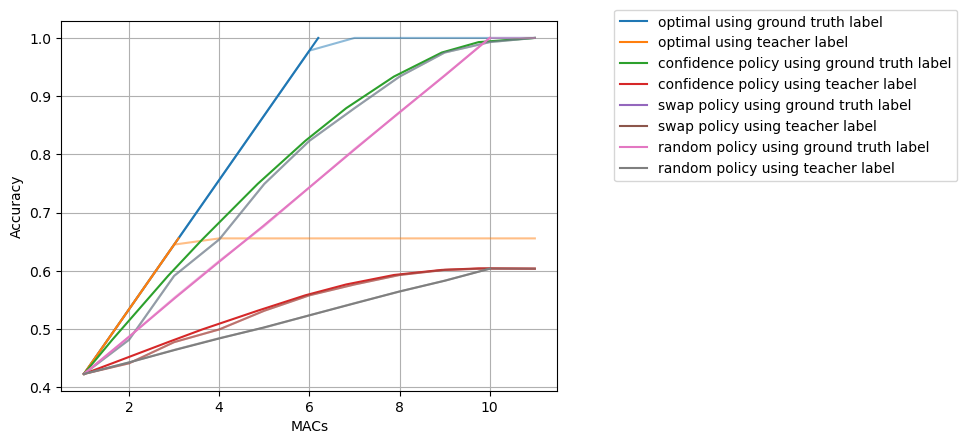

In [141]:
plt.plot(np.array(macs_l)/50000,np.array(accs_l)/50000,label="optimal using ground truth label")
plt.plot(budgets,np.array(accs_l)/50000,alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_t)/50000,np.array(accs_t)/50000,label="optimal using teacher label")
plt.plot(budgets,np.array(accs_t)/50000,alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(actual_macs_l)/50000,actual_accs_l,label="confidence policy using ground truth label")
plt.plot(budgets,actual_accs_l,alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(actual_macs_t)/50000,actual_accs_t,label="confidence policy using teacher label")
plt.plot(budgets,actual_accs_t,alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_l_policy)/50000,actual_accs_l_policy,label="swap policy using ground truth label")
plt.plot(budgets,actual_accs_l,alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_t_policy)/50000,actual_accs_t_policy,label="swap policy using teacher label")
plt.plot(budgets,actual_accs_t,alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_l_rand)/50000,actual_accs_rand_l,label="random policy using ground truth label")
plt.plot(budgets,actual_accs_rand_l,alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_t_rand)/50000,actual_accs_rand_t,label="random policy using teacher label")
plt.plot(budgets,actual_accs_rand_t,alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.xlabel("MACs")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.grid()

In [72]:
np.array(actual_macs_t)/50000

array([ 1.    ,  1.6292,  2.9048,  3.6236,  4.8284,  5.896 ,  6.824 ,
        7.9336,  8.9444,  9.7522, 10.9988], dtype=float32)

In [70]:
actual_accs_t

[tensor(0.4226),
 tensor(0.4409),
 tensor(0.4785),
 tensor(0.4991),
 tensor(0.5307),
 tensor(0.5576),
 tensor(0.5763),
 tensor(0.5933),
 tensor(0.6013),
 tensor(0.6039),
 tensor(0.6035)]

In [60]:
actual_accs_t_policy

[tensor(0.4226),
 tensor(0.4381),
 tensor(0.4577),
 tensor(0.4813),
 tensor(0.4988),
 tensor(0.5178),
 tensor(0.5364),
 tensor(0.5528),
 tensor(0.5702),
 tensor(0.5860),
 tensor(0.6035)]

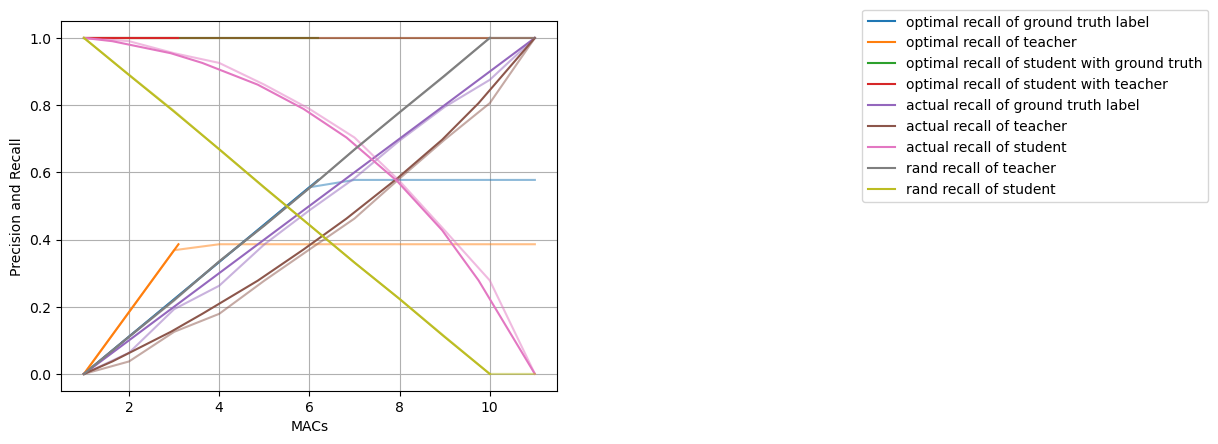

In [340]:
# plt.plot(np.array(macs_l)/50000,np.array(l_prec_UB),label="optimal precision of ground truth label")
# plt.plot(budgets,np.array(l_prec_UB),alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_l)/50000,np.array(l_rec_UB),label="optimal recall of ground truth label")
plt.plot(budgets,np.array(l_rec_UB),alpha=0.5,color=plt.gca().lines[-1].get_color())
# plt.plot(np.array(macs_t)/50000,np.array(teach_prec_UB),label="optimal precision of teacher")
# plt.plot(budgets,np.array(teach_prec_UB),alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_t)/50000,np.array(teach_rec_UB),label="optimal recall of teacher")
plt.plot(budgets,np.array(teach_rec_UB),alpha=0.5,color=plt.gca().lines[-1].get_color())
# plt.plot(np.array(macs_l)/50000,np.array(stud_prec_UB_l),label="optimal precision of student with ground truth")
# plt.plot(budgets,np.array(stud_prec_UB_l),alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_l)/50000,np.array(stud_rec_UB_l),label="optimal recall of student with ground truth")
plt.plot(budgets,np.array(stud_rec_UB_l),alpha=0.5,color=plt.gca().lines[-1].get_color())
# plt.plot(np.array(macs_t)/50000,np.array(stud_prec_UB_t),label="optimal precision of student with teacher")
# plt.plot(budgets,np.array(stud_prec_UB_t),alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_t)/50000,np.array(stud_rec_UB_t),label="optimal recall of student with teacher")
plt.plot(budgets,np.array(stud_rec_UB_t),alpha=0.5,color=plt.gca().lines[-1].get_color())

# plt.plot(np.array(actual_macs_l)/50000,np.array(l_prec_actual),label="actual precision of ground truth label")
# plt.plot(budgets,np.array(l_prec_actual),alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(actual_macs_l)/50000,np.array(l_rec_actual),label="actual recall of ground truth label")
plt.plot(budgets,np.array(l_rec_actual),alpha=0.5,color=plt.gca().lines[-1].get_color())
# plt.plot(np.array(actual_macs_t)/50000,np.array(teach_prec_actual),label="actual precision of teacher")
# plt.plot(budgets,np.array(teach_prec_actual),alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(actual_macs_t)/50000,np.array(teach_rec_actual),label="actual recall of teacher")
plt.plot(budgets,np.array(teach_rec_actual),alpha=0.5,color=plt.gca().lines[-1].get_color())
# plt.plot(np.array(actual_macs_l)/50000,np.array(stud_prec_actual),label="actual precision of student")
# plt.plot(budgets,np.array(stud_prec_actual),alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(actual_macs_l)/50000,np.array(stud_rec_actual),label="actual recall of student")
plt.plot(budgets,np.array(stud_rec_actual),alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_t_rand)/50000,np.array(teach_rec_rand),label="rand recall of teacher")
plt.plot(budgets,np.array(teach_rec_rand),alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.plot(np.array(macs_t_rand)/50000,np.array(stud_rec_rand),label="rand recall of student")
plt.plot(budgets,np.array(stud_rec_rand),alpha=0.5,color=plt.gca().lines[-1].get_color())
plt.xlabel("MACs")
plt.ylabel("Precision and Recall")
plt.legend(bbox_to_anchor=(1.6,1.05))
plt.grid()

In [287]:
teach_prec_actual

[tensor(0.1500),
 tensor(0.3559),
 tensor(0.3925),
 tensor(0.4112),
 tensor(0.4345),
 tensor(0.4592),
 tensor(0.4793),
 tensor(0.5053),
 tensor(0.5295),
 tensor(0.5557),
 tensor(0.6035)]

In [199]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from torch.distributions import Categorical

# build models
# mlp_clf = mlp = MLPClassifier((128),batch_size=64)

# get data, 0 means stud wrong, 1 means stud right
num_total = 20000 
X = corr_embds128[0][shuffled_order[:num_total]]
Y = x_sr[:num_total]
num_train = 3000


# relative costs
s_cost = 1
l_cost = 10
budget = 4

# this fraction of preds must be student, i.e. must pred stud right (1) this number of times
min_s = (s_cost+l_cost-budget)/l_cost

# train models
# X_train = X[:num_train]
# Y_train = Y[:num_train]

# mlp
# mlp_clf.fit(X_train,Y_train)

# all classifiers use conf dist to remain in budget
# n_bins = 31
# bin_boundaries = torch.linspace(0, 1, n_bins + 1)
# bin_lowers = bin_boundaries[:-1]
# bin_uppers = bin_boundaries[1:]
# bin_marks = torch.cat([bin_lowers,bin_uppers[-1].unsqueeze(0)])
# conf_bins = torch.zeros(n_bins)
# conf_counts = 0
# ent_bin_boundaries = torch.linspace(0, 5, n_bins + 1)
# ent_bin_lowers = ent_bin_boundaries[:-1]
# ent_bin_uppers = ent_bin_boundaries[1:]
# ent_bin_marks = torch.cat([ent_bin_lowers,ent_bin_uppers[-1].unsqueeze(0)])
# ent_conf_bins = torch.zeros(n_bins)
# ent_conf_counts = 0
# mlp_conf_bins = torch.zeros(n_bins)
# mlp_conf_counts = 0
# stud_confs = torch.max(corr_preds128[0][shuffled_order[:num_train]],dim=1)[0]
# stud_ents = Categorical(probs=corr_preds128[0][shuffled_order[:num_train]]).entropy()

# # update confidence and threshold
# for stud_conf in tqdm(stud_confs):
#     bin = torch.logical_and(stud_conf > bin_lowers,stud_conf <= bin_uppers).nonzero()
#     conf_bins*=conf_counts
#     conf_bins[bin] += 1
#     conf_counts += 1
#     conf_bins /= conf_counts
#     conf_ccdf = torch.tensor([sum(conf_bins[len(conf_bins)-i:len(conf_bins)]) for i in range(len(conf_bins)+1)])
#     bin_thresh = n_bins - (conf_ccdf+1e-3 >= min_s).nonzero().view(-1).min()
#     threshold = bin_marks[bin_thresh]

# for stud_ent in tqdm(stud_ents):
#     bin = torch.logical_and(stud_ent > ent_bin_lowers,stud_ent <= ent_bin_uppers).nonzero()
#     ent_conf_bins*=ent_conf_counts
#     ent_conf_bins[bin] += 1
#     ent_conf_counts += 1
#     ent_conf_bins /= ent_conf_counts
#     conf_ccdf = torch.tensor([sum(ent_conf_bins[len(ent_conf_bins)-i:len(ent_conf_bins)]) for i in range(len(ent_conf_bins)+1)])
#     bin_thresh = n_bins - (conf_ccdf+1e-3 >= min_s).nonzero().view(-1).min()
#     threshold = bin_marks[bin_thresh]


# # update confidence and threshold
# mlp_preds = torch.zeros(num_total-num_train)
# mlp_confs = np.max(mlp_clf.predict_proba(X[num_train:]),axis=1)
# i = 0
# for mlp_conf in tqdm(mlp_confs):
#     bin = torch.logical_and(mlp_conf > bin_lowers,mlp_conf <= bin_uppers).nonzero()
#     mlp_conf_bins*=mlp_conf_counts
#     mlp_conf_bins[bin] += 1
#     mlp_conf_counts += 1
#     mlp_conf_bins /= mlp_conf_counts
#     conf_ccdf = torch.tensor([sum(mlp_conf_bins[len(mlp_conf_bins)-i:len(mlp_conf_bins)]) for i in range(len(mlp_conf_bins)+1)])
#     bin_thresh = n_bins - (conf_ccdf+1e-3 >= min_s).nonzero().view(-1).min()
#     threshold = bin_marks[bin_thresh]
#     if mlp_conf > threshold:
#         mlp_preds[i] = 1
#     else:
#         mlp_preds[i] = 0
#     i += 1
# mlp_acc = sum(mlp_preds.numpy() == Y[num_train:])/len(mlp_preds)

n_bins = 21
bin_boundaries = torch.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_marks = torch.cat([bin_lowers,bin_uppers[-1].unsqueeze(0)])
conf_bins = torch.zeros(n_bins)
conf_counts = 0
stud_confs = torch.max(corr_preds128[0][shuffled_order[:num_total]],dim=1)[0]
stud_preds = torch.zeros(num_total)
i = 0
for stud_conf in tqdm(stud_confs):
    bin = torch.logical_and(stud_conf > bin_lowers,stud_conf <= bin_uppers).nonzero()
    conf_bins*=conf_counts
    conf_bins[bin] += 1
    conf_counts += 1
    conf_bins /= conf_counts
    conf_ccdf = torch.tensor([sum(conf_bins[len(conf_bins)-i:len(conf_bins)]) for i in range(len(conf_bins)+1)])
    bin_thresh = n_bins - (conf_ccdf+1e-3 >= min_s).nonzero().view(-1).min()
    threshold = bin_marks[bin_thresh]
    if stud_conf > threshold:
        stud_preds[i] = 1
    else:
        stud_preds[i] = 0
    i += 1
# stud_acc = sum(stud_preds.numpy() == Y[num_train:])/len(stud_preds)
act_acc = (stud_preds.T@Y + ((stud_preds==0).float()@torch.tensor(x_tr[:num_total]).float()).numpy())/len(Y)

# stud_ents = Categorical(probs=corr_preds128[0][shuffled_order[num_train:num_total]]).entropy()
# stud_preds = torch.zeros(num_total-num_train)
# i = 0
# for stud_ent in tqdm(stud_ents):
#     bin = torch.logical_and(stud_ent > ent_bin_lowers,stud_ent <= ent_bin_uppers).nonzero()
#     ent_conf_bins*=ent_conf_counts
#     ent_conf_bins[bin] += 1
#     ent_conf_counts += 1
#     ent_conf_bins /= ent_conf_counts
#     conf_ccdf = torch.tensor([sum(ent_conf_bins[len(ent_conf_bins)-i:len(ent_conf_bins)]) for i in range(len(ent_conf_bins)+1)])
#     bin_thresh = n_bins - (conf_ccdf+1e-3 >= min_s).nonzero().view(-1).min()
#     threshold = bin_marks[bin_thresh]
#     if stud_ent > threshold:
#         stud_preds[i] = 1
#     else:
#         stud_preds[i] = 0
# ent_stud_acc = sum(stud_preds.numpy() == Y[num_train:])/len(stud_preds)

# # random
# pred = (torch.rand(num_total-num_train) < min_s).numpy()
# rand_acc = sum(pred == Y[num_train:])/len(pred)

100%|██████████| 20000/20000 [00:21<00:00, 928.86it/s]


In [181]:
20000 - sum(stud_preds)

tensor(5364.)

In [202]:
stud_preds.T@Y /sum(stud_preds)

tensor(0.5382)

In [201]:
(stud_preds==0).float()@torch.tensor(x_tr[:num_total]).float()/5364

tensor(0.4141)

In [200]:
act_acc

tensor(0.5049)

In [144]:
print("mlp:",mlp_acc)
print("conf:",stud_acc)
print("ent:",ent_stud_acc)
print("random",rand_acc)

mlp: 0.48542857142857143
conf: 0.7341428571428571
ent: 0.5738571428571428
random 0.5018571428571429


In [1]:
rand_i = 30
dec(torch.cat([corr_embds128[0][shuffled_order[rand_i]],torch.max(corr_preds128[0][shuffled_order[rand_i]]).unsqueeze(0)]))

NameError: name 'dec' is not defined

In [468]:
print(sum(res)/train_len)
print(sum(res_naive)/train_len)
print(accum_cost/train_len)
print(accum_cost_naive/train_len)
print(effs*s_cost+(1-effs)*l_cost)
print(accs/train_len)

tensor(0.4244)
tensor(0.6654)
1.0035
3.808
3.9997000000000003
0.75265


: 

In [434]:
sum(x_sr[:5000])

2111

In [439]:
sum(x_cl.value[:5000])

514.0

In [390]:
losses[-1]

tensor(0.6447)

tensor(0.6301)


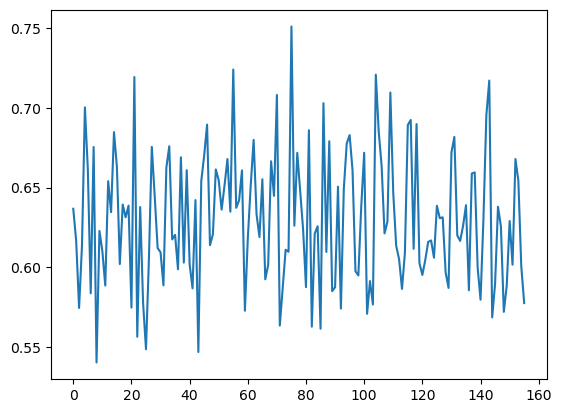

In [421]:
plt.plot(losses)
print(sum(losses)/len(losses))

In [174]:
prec_S = torch.zeros(1000)
recall_S = torch.zeros(1000)
prec_T = torch.zeros(1000)
recall_T = torch.zeros(1000)
preds_S = torch.argmax(corr_preds64[0],dim=1)
preds_T = torch.argmax(corr_preds[0],dim=1)
class_dist_S = torch.zeros(1000)
class_dist_T = torch.zeros(1000)
prec_est = torch.zeros(1000)
recall_est = torch.zeros(1000)
class_conf_S = torch.zeros(1000)
class_conf_T = torch.zeros(1000)
confusion = torch.zeros((1000,1000))
for c in range(1000):
    if len((preds_S==c).nonzero()) > 0:
        prec_S[int(c)] = sum(corr_labels[0][(preds_S==c).nonzero()] == c)/len((preds_S==c).nonzero())
        prec_est[int(c)] = sum(preds_T[(preds_S==c).nonzero()] == c)/len((preds_S==c).nonzero())
        class_conf_S[int(c)] = torch.max(corr_preds64[0][(preds_S==c).nonzero()],dim=2)[0].mean()
    prec_T[int(c)] = sum(corr_labels[0][(preds_T==c).nonzero()] == c)/len((preds_T==c).nonzero())
    recall_S[int(c)] = sum(preds_S[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())
    recall_T[int(c)] = sum(preds_T[(corr_labels[0]==c).nonzero()] == c)/len((corr_labels[0]==c).nonzero())
    
    recall_est[int(c)] = sum(preds_S[(preds_T==c).nonzero()] == c)/len((preds_T==c).nonzero())
    class_dist_S[int(c)] = len((preds_S==c).nonzero())/50000
    class_dist_T[int(c)] = len((preds_T==c).nonzero())/50000
    class_conf_T[int(c)] = torch.max(corr_preds[0][(preds_T==c).nonzero()],dim=2)[0].mean()
for i in range(50000):
    confusion[preds_S[i],preds_T[i]] += 1

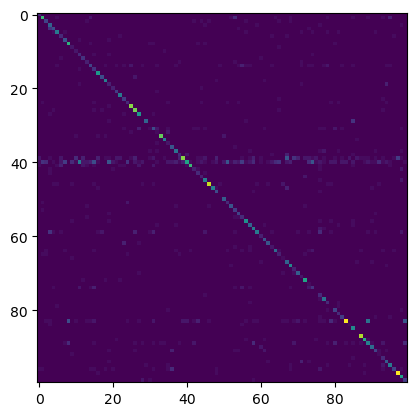

In [141]:
plt.imshow(confusion[450:550,450:550])

In [151]:
print("student prec:",prec_S.mean())
print("teacher prec:",prec_T.mean())
print("student recall:",recall_S.mean())
print("teacher recall:",recall_T.mean())
print("estimate precision:",prec_est.mean())
print("estimate recall:",recall_est.mean())

student prec: tensor(0.3811)
teacher prec: tensor(0.6222)
student recall: tensor(0.3277)
teacher recall: tensor(0.6035)
estimate precision: tensor(0.4104)
estimate recall: tensor(0.3541)


In [322]:
unconf_idxs = (torch.max(corr_preds64[0],dim=1)[0] < 0.1).nonzero()
conf_idxs = (torch.max(corr_preds64[0],dim=1)[0] > 0.1).nonzero()
print(sum(preds_S[unconf_idxs] == corr_labels[0][unconf_idxs])/len(unconf_idxs))
print(sum(preds_S[conf_idxs] == corr_labels[0][conf_idxs])/len(conf_idxs))
print(sum(preds_T[unconf_idxs] == corr_labels[0][unconf_idxs])/len(unconf_idxs))
print(sum(preds_T[conf_idxs] == corr_labels[0][conf_idxs])/len(conf_idxs))
print(len(unconf_idxs)/50000,len(conf_idxs)/50000)

IndexError: list index out of range

In [227]:
class Dec(torch.nn.Module):
  def __init__(self,feats):
     super(Dec,self).__init__()
     self.dec = torch.nn.Linear(feats,1)
  def forward(self,x):
    return F.sigmoid(self.dec(x))
dec = Dec(1022).eval()


s_cost = 22
l_cost = 234
budget = 120
min_s = (s_cost+l_cost-budget)/l_cost
print(min_s)
accum_cost = 0
accum_cost_naive = 0
count = 0
feat_vec = torch.zeros(2)
confusion = torch.zeros((1000,1000))
class_confs = torch.zeros(1000)
class_counts = torch.zeros(1000)
n_bins = 20
bin_boundaries = torch.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_marks = torch.cat([bin_lowers,bin_uppers[-1].unsqueeze(0)])
conf_bins = torch.zeros(n_bins)
conf_counts = 0
opt = torch.optim.SGD(dec.parameters(),0.01,0.9)
n = 1
stud_preds = torch.zeros(50000*n)
stud_preds_naive = torch.zeros(50000*n)
decs = torch.zeros(50000)

means = torch.zeros((1000,1280))
mean_counts = torch.zeros(1000)
conf_mem = torch.zeros((500,1280))
conf_mem_values = torch.zeros(500)
unconf_mem = torch.zeros((500,1280))
unconf_mem_values = torch.ones(500)*1e6
i = 0

res = torch.zeros(50000*n)
res_naive = torch.zeros(50000*n)
swap = False
for c_i in range(n):
    shuffled_order = torch.randperm(50000)
    confusion = torch.zeros((1000,1000))
    conf_bins = torch.zeros(n_bins)
    conf_counts = 0
    for rand_idx in tqdm(shuffled_order):
        # stud_emb = corr_embds64[c_i][rand_idx]
        # label = int(corr_labels[c_i][rand_idx])
        # if i < n:
        #     means[label] = (means[label]*mean_counts[label] + stud_emb)/(mean_counts[label]+1)
        #     mean_counts[label] += 1
        # else:
        #     pred = torch.argmin(torch.cdist(stud_emb.unsqueeze(0),means).view(-1))
        #     res[i-n] = (int(corr_labels[c_i][rand_idx])==pred)
        # get student prediction
        teach_pred,teach_conf = torch.argmax(corr_preds[c_i][rand_idx]),torch.max(corr_preds[c_i][rand_idx])
        stud_pred,stud_conf = torch.argmax(corr_preds128[c_i][rand_idx]),torch.max(corr_preds128[c_i][rand_idx])
        accum_cost += s_cost
        accum_cost_naive += s_cost

        # update confidence and threshold
        bin = torch.logical_and(stud_conf > bin_lowers,stud_conf <= bin_uppers).nonzero()
        conf_bins*=conf_counts
        conf_bins[bin] += 1
        conf_counts += 1
        conf_bins /= conf_counts
        conf_ccdf = torch.tensor([sum(conf_bins[len(conf_bins)-i:len(conf_bins)]) for i in range(len(conf_bins)+1)])
        bin_thresh = n_bins - (conf_ccdf+1e-3 >= min_s).nonzero().view(-1).min()
        threshold = bin_marks[bin_thresh]

        # check if have budget for teacher
        # if (accum_cost + l_cost)/(count+1) < budget:
            # get precision, need to account for columns with zero
        # zero_idxs = (confusion.sum(dim=1) == 0).nonzero()
        # diag = torch.diagonal(confusion,0)
        # row_sums = confusion.sum(dim=1)
        # row_sums[zero_idxs] = -1
        # prec = diag/row_sums
        
        class_counts[stud_pred] += 1
        if stud_conf > threshold:
            stud_preds[i] = stud_pred
            stud_preds_naive[i] = stud_pred
            if False and torch.rand(1) > 0.5 and swap == False:
                stud_preds[i] = teach_pred
                accum_cost += l_cost
                confusion[stud_pred][teach_pred] += 1
                swap = True
        else:
            if False and swap == True:
                stud_preds[i] = stud_pred
                swap = False
            else:
                stud_preds_naive[i] = teach_pred
                accum_cost_naive += l_cost
                # if confusion[int(stud_pred)].mean() > threshold:
                #     stud_preds[i] = stud_pred
                conf_dist = torch.cdist(corr_embds128[c_i][rand_idx].unsqueeze(0),conf_mem).view(-1).mean()
                unconf_dist = torch.cdist(corr_embds128[c_i][rand_idx].unsqueeze(0),unconf_mem).view(-1).mean()
                # if we have mem full and we are closer to confident region
                if (sum(conf_mem_values == 0) == 0) and (sum(unconf_mem_values == 1e6) == 0) and (unconf_dist > conf_dist):
                    stud_preds[i] = stud_pred
                else:
                    accum_cost += l_cost
                    stud_preds[i] = teach_pred

                    if teach_conf > threshold and teach_conf > conf_mem_values[0]:
                        conf_mem_values[0] = teach_conf
                        conf_mem_values, idxs = torch.sort(conf_mem_values)
                        conf_mem[0] = corr_embds[c_i][rand_idx]
                        conf_mem = conf_mem[idxs]
                    else:
                        if teach_conf < threshold and teach_conf < unconf_mem_values[-1]:
                            unconf_mem_values[-1] = teach_conf
                            unconf_mem_values, idxs = torch.sort(unconf_mem_values)
                            unconf_mem[0] = corr_embds[c_i][rand_idx]
                            unconf_mem = unconf_mem[idxs]
                    # confusion[stud_pred][teach_pred] += 1
                    # class_confs[int(teach_pred)] = (class_confs[int(teach_pred)]*class_counts[int(teach_pred)] + teach_conf)/(class_counts[int(teach_pred)]+1)

            # feed feature vec into model to determine if to get the label
            # feat_vec = torch.cat([prec,conf_bins,torch.tensor([stud_conf,stud_pred])])
            # get_label = dec(feat_vec)
            # if get_label > 0.5: # get label = 1 means get label, get label = 0 means use student
            #     # get the label, if it was the same as student prediction then add loss
            #     label = labels[rand_idx]
            #     accum_cost += l_cost
            #     opt.zero_grad()
            #     # loss = torch.nn.functional.binary_cross_entropy(get_label[0],(stud_pred!=label).float())
            #     if stud_pred == label:
            #         loss = 0.0*get_label[0]
            #     else:
            #         loss = -get_label[0]
            #     loss.backward()
            #     opt.step()
            #     confusion[int(stud_pred)][int(label)] += 1
            #     stud_preds[i] = label
            # else:
            #     stud_preds[i] = stud_pred
            #     decs[i] = 1
        res[i] = (stud_preds[i] == corr_labels[c_i][rand_idx])
        res_naive[i] = (stud_preds_naive[i] == corr_labels[c_i][rand_idx])
        count += 1
        i+=1



0.5811965811965812


100%|██████████| 50000/50000 [01:47<00:00, 467.14it/s]


In [233]:
unconf_dist

tensor(22.3386)

In [228]:
print(accum_cost/(50000*n))
print(accum_cost_naive/(50000*n))

112.0198
112.0198


In [229]:
print(sum(res)/(50000*n))
print(sum(res_naive)/(50000*n))

tensor(0.4647)
tensor(0.4647)


In [267]:
(decs == 0).nonzero()

tensor([[    0],
        [    1],
        [  352],
        [  858],
        [ 1410],
        [ 1729],
        [ 1972],
        [ 2000],
        [ 3103],
        [ 3185],
        [ 3394],
        [ 4548],
        [ 4767],
        [ 5217],
        [ 5560],
        [ 5720],
        [ 6312],
        [ 6636],
        [ 6747],
        [ 6837],
        [ 7511],
        [ 7801],
        [ 8129],
        [ 8761],
        [ 8863],
        [ 9221],
        [11119],
        [11762],
        [11939],
        [12096],
        [12624],
        [12831],
        [12912],
        [13105],
        [13225],
        [14299],
        [15725],
        [16035],
        [17568],
        [18750],
        [18918],
        [21636],
        [22648],
        [22737],
        [23444],
        [24385],
        [24516],
        [29882],
        [31036],
        [42699],
        [43944],
        [46431],
        [49415]])

In [143]:
# shuffle order
n = 10000
c_i = 0
shuffled_order = torch.randperm(50000)
# prec_est = torch.zeros(1000)
# prec_count = torch.zeros(1000)
# recall_est = torch.zeros(1000)
# recall_count = torch.zeros(1000)
confusion = torch.zeros(1000,1000)

# for every img in first n
for rand_idx in tqdm(shuffled_order[:n]):
    # get teacher pred and conf
    teach_pred,teacher_conf = torch.argmax(corr_preds[c_i][rand_idx]),torch.max(corr_preds[c_i][rand_idx])
    stud_pred,stud_conf = torch.argmax(corr_preds128[c_i][rand_idx]),torch.max(corr_preds128[c_i][rand_idx])
    # prec_est[stud_pred] = (prec_est[stud_pred]*prec_count[stud_pred] + (teach_pred==stud_pred))/(prec_count[stud_pred]+1)
    # prec_count[stud_pred] += 1
    # recall_est[teach_pred] = (recall_est[teach_pred]*recall_count[teach_pred] + (teach_pred==stud_pred))/(recall_count[teach_pred]+1)
    # recall_count[teach_pred] += 1
    confusion[stud_pred][teach_pred] += 1

prec_est = torch.diagonal(confusion,0)/confusion.sum(dim=1)
recall_est = torch.diagonal(confusion,0)/confusion.sum(dim=0)
prec_counts = confusion.sum(dim=1)
recall_counts = confusion.sum(dim=0)
    
print(prec_est[prec_est > 0].mean())
print(recall_est[recall_est > 0].mean())
# then do prediction for remaining images
stud_base_preds = torch.zeros(50000-n)
confusion_preds = torch.zeros(50000-n)
count_c = 0
count_t = 0
for i,rand_idx in enumerate(shuffled_order[n:]):
    stud_pred = torch.argmax(corr_preds128[c_i][rand_idx])
    stud_base_preds[i] = stud_pred
    stud_base_conf = torch.max(corr_preds128[c_i][rand_idx])

    value = confusion[stud_pred,stud_pred]
    largest_value = torch.max(confusion[stud_pred,:])
    largest_idx = torch.argmax(confusion[stud_pred,:])

    if (prec_counts[stud_pred] > 1) and (prec_est[stud_pred] < 0.05) and largest_value > 10*value:
        confusion_preds[i] = largest_idx
        if largest_idx == labels[rand_idx]:
            count_c +=1
        count_t += 1
    else:
        confusion_preds[i] = stud_pred

    
    
print("base:",sum(stud_base_preds == labels[shuffled_order[n:]])/(50000-n))
print("confusion:",sum(confusion_preds == labels[shuffled_order[n:]])/(50000-n))
print(count_c/count_t)

100%|██████████| 10000/10000 [00:00<00:00, 42652.13it/s]


tensor(0.4365)
tensor(0.3873)
base: tensor(0.3274)
confusion: tensor(0.3180)
0.023529411764705882


In [133]:
len(prec_est[torch.logical_and(prec_est < 0.1,prec_counts>0)])

116

In [360]:
# shuffle order
n = 10000
# c_i = 4
shuffled_order = torch.randperm(50000)
for c_i in range(15):

    mean_idxs = shuffled_order[0:n]
    flags = torch.ones(1000)

    # build means from first 5000 imgs
    stud_means = torch.zeros((1000,embds.shape[1]))
    max_dist = 0
    for i,c in enumerate(torch.unique(labels)):
        # get idxs where teacher predicts that class and its greater than 50% conf
        idxs = (torch.argmax(corr_preds[c_i][mean_idxs],dim=1) == c).nonzero()
        idxs2 = torch.max(corr_preds[c_i][mean_idxs],dim=1)[0][idxs] > 0.5
        idxs = idxs[idxs2]
        
        if len(idxs) == 0:
            flags[int(c)] = 0
        else:
            # idxs is between [0,5000], we need to map this to mean idxs
            stud_means[int(c)] = torch.mean(corr_embds64[c_i][mean_idxs[idxs]],dim=0)

    with torch.no_grad():
        mean_confs = fcs(stud_means)


    # student accuracy on 5,000:50000
    stud_base = sum(torch.argmax(corr_preds64[c_i][shuffled_order[n:]],dim=1)==labels[shuffled_order[n:]])/(50000-n)

    # get student confidence scores for 45000
    stud_confs = torch.max(corr_preds64[c_i][shuffled_order[n:]],dim=1)[0]

    # separate the scores into those with conf higher than thresh 0.5
    stud_pred_idxs = (stud_confs >= 0.5).nonzero().view(-1) # b/t 5k and 50k
    check_ncm_idxs = (stud_confs < 0.5).nonzero().view(-1)

    # for the low conf embds, get the nearest class mean, then get the confidence score for each ncm
    ncm_preds = torch.argmin(torch.cdist(corr_embds64[c_i][shuffled_order[n:][check_ncm_idxs]],stud_means),dim=1)
    ncm_confs = torch.max(mean_confs,dim=1)[0][ncm_preds]

    # # flag 0 idxs
    # bad = (flags==0).nonzero().view(-1)
    # switch_idxs = (ncm_preds==bad[0])
    # for bad_c in bad[1:]:
    #     switch_idxs = torch.cat((switch_idxs,(ncm_preds==bad_c)))
    # if len(switch_idxs.nonzero()) > 0:
    #     stud_pred_idxs = torch.cat((stud_pred_idxs,check_ncm_idxs[switch_idxs.nonzero()].view(-1)))
    #     check_ncm_idxs = check_ncm_idxs[(~switch_idxs).nonzero()]

    # # for the low conf embds, get the nearest class mean, then get the confidence score for each ncm
    # ncm_preds = torch.argmin(torch.cdist(corr_embds64[c_i][shuffled_order[n:][check_ncm_idxs]],stud_means),dim=1)
    # ncm_confs = torch.max(mean_confs,dim=1)[0][ncm_preds]

    # get the class prediction for these two partitions
    stud_only_pred = torch.argmax(corr_preds64[c_i][shuffled_order[n:][stud_pred_idxs]],dim=1)
    stud_may_pred = torch.argmax(corr_preds64[c_i][shuffled_order[n:][check_ncm_idxs]],dim=1) # 29k
    stud_may_confs = stud_confs[check_ncm_idxs]

    # compare confidences and choose higher
    # stud_higher_idxs = (stud_may_confs > ncm_confs).nonzero().view(-1)
    # ncm_higher_idxs = (ncm_confs > stud_may_confs).nonzero().view(-1)
    ncm_higher_idxs = (ncm_confs > 0.5).nonzero().view(-1)
    stud_higher_idxs = (ncm_confs < 0.5).nonzero().view(-1)
    
    # get accuracies
    stud_only_corr = sum(stud_only_pred==labels[shuffled_order[n:][stud_pred_idxs]])
    stud_may_corr = sum(stud_may_pred[stud_higher_idxs]==labels[shuffled_order[n:][check_ncm_idxs[stud_higher_idxs]]])
    ncm_corr = sum(ncm_preds[ncm_higher_idxs]==labels[shuffled_order[n:][check_ncm_idxs[ncm_higher_idxs]]])

    stud_teach = (stud_only_corr+stud_may_corr+ncm_corr)/(50000-n)

    print("just stud:",stud_base)
    print("using ncm:",stud_teach)

just stud: tensor(0.2132)
using ncm: tensor(0.2093)
just stud: tensor(0.2234)
using ncm: tensor(0.2148)
just stud: tensor(0.2179)
using ncm: tensor(0.2117)
just stud: tensor(0.3033)
using ncm: tensor(0.2775)
just stud: tensor(0.0913)
using ncm: tensor(0.0940)
just stud: tensor(0.3384)
using ncm: tensor(0.3119)
just stud: tensor(0.2794)
using ncm: tensor(0.2570)


KeyboardInterrupt: 

In [357]:
len(check_ncm_idxs)

25885

In [359]:
sum(stud_may_pred == labels[shuffled_order[n:]][check_ncm_idxs])/25885
sum(ncm_preds == labels[shuffled_order[n:]][check_ncm_idxs])/25885

tensor(0.0974)

# Class Centroids

In [5]:
def get_class_centroids(embds,labels):
    means = torch.zeros((1000,embds.shape[1]))
    stds = torch.zeros((1000,embds.shape[1]))
    for i,c in enumerate(torch.unique(labels)):
        idxs = (labels == c).nonzero().view(-1)
        c_embds = embds[idxs]
        means[i] = torch.mean(c_embds,dim=0)
        stds[i] = torch.std(c_embds,dim=0)
    return means,stds

In [6]:
embds,labels = torch.load("embds/clean224.pt")
means,stds = get_class_centroids(embds,labels)

embds64,labels64 = torch.load("embds/clean64.pt")
means64,stds64 = get_class_centroids(embds64,labels64)

corr_embds = []
corr_labels = []
corr_embds64 = []
corr_labels64 = []
for i,corr in enumerate(corruptions):
    e,l = torch.load("embds/corr224_"+corr+".pt")
    e64,l64 = torch.load("embds/corr64_"+corr+".pt")
    corr_embds.append(e)
    corr_labels.append(l)
    corr_embds64.append(e64)
    corr_labels64.append(l64)
    # corr_means,corr_stds = get_class_centroids(corr_embds,corr_labels)
    # corr_means64,corr_stds64 = get_class_centroids(corr_embds64,corr_labels64)

get the distance of the shifted class centroids to all source centroids

In [6]:
clean_embds = []
clean_labels = []
corr_embds = [[] for i in range(len(model_names))]
corr_labels = [[] for i in range(len(model_names))]
# for all models
for i,mn in enumerate(model_names):
    print(mn)
    # get the source embeddings
    e,l = torch.load("embds/clean224_"+model_names[i]+".pt")
    clean_embds.append(e)
    clean_labels.append(l)
    # for all corruptions
    for j,c in enumerate(corruptions):
        # get the target embeddings for the given model and corruption
        ce,cl = torch.load("embds/sev1corr224_"+corruptions[j]+"_"+model_names[i]+".pt")
        corr_embds[i].append(ce)
        corr_labels[i].append(cl)

clean_means = []
corr_means = [[] for i in range(len(model_names))]
# for all models
for i,mn in enumerate(model_names):
    print(mn)
    # get the source centroids
    mean,std = get_class_centroids(clean_embds[i],clean_labels[i])
    clean_means.append(mean)
    # for all corruptions
    for j,c in enumerate(corruptions):
        # get the target centroids for the given model and corruption
        cm,cstd = get_class_centroids(corr_embds[i][j],corr_labels[i][j])
        corr_means[i].append(cm)

mobilenet_v3_small
mnasnet0_5
mnasnet0_75
mobilenet_v3_large
mobilenet_v2
mobilenet_v3_small
mnasnet0_5
mnasnet0_75
mobilenet_v3_large
mobilenet_v2


In [31]:
# for every corruption


for i in range(15):
    dists = torch.zeros((1000,1000))
    # for every model
    for j,mn in enumerate(model_names):
        # embds,labels = torch.load("embds/clean224_"+model_names[j]+".pt")
        # corr_embds,corr_labels = torch.load("embds/corr224_"+corruptions[i]+"_"+model_names[j]+".pt")

        # means,stds = get_class_centroids(embds,labels)
        # corr_means,corr_stds = get_class_centroids(corr_embds,corr_labels)

        # distance from every source centroid to every target centroid for the given model and corruption type
        # matrix of source-target distances for every class where rows are source and columns are target
        # this matrix is for one model and one corruption type
        dists += torch.cdist(clean_means[j],corr_means[j][i])
        # print((torch.topk(-d[0,:],1000)[1]==1).nonzero())

        # avg rank for all classes
        # avg_pos = 0
        # for every class
        # for c in range(1000):
        #     # for class c, get the distance from source centroid to all other classes target centroids in order
        #     vals,inds = (-dists[c,:]).topk(1000)
        #     # check how far the source and target are for each class by rank
        #     avg_pos += (inds==c).nonzero().view(-1).item()
        # print(avg_pos/1000)
    dists/=5
    # vals,inds = (-dists[0,:]).topk(1000)
    # print((inds==0).nonzero().view(-1).item())
    avg_pos = 0
    # for every class
    for c in range(1000):
        # for class c, get the distance from source centroid to all other classes target centroids in order
        vals,inds = (-dists[c,:]).topk(1000)
        # check how far the source and target are for each class by rank
        avg_pos += (inds==c).nonzero().view(-1).item()
    print(avg_pos/1000)

0.002
0.003
0.004
0.002
0.003
0.0
0.049
0.013
0.003
0.002
0.0
0.0
0.001
0.0
0.0


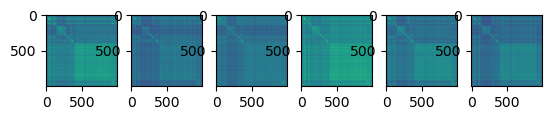

: 

In [32]:
fig,ax = plt.subplots(1,6)
ax[0].imshow(-torch.cdist(clean_means[0],corr_means[0][0]))
ax[1].imshow(-torch.cdist(clean_means[1],corr_means[1][0]))
ax[2].imshow(-torch.cdist(clean_means[2],corr_means[2][0]))
ax[3].imshow(-torch.cdist(clean_means[3],corr_means[3][0]))
ax[4].imshow(-torch.cdist(clean_means[4],corr_means[4][0]))
ax[5].imshow(-dists)

In [102]:
class FC(torch.nn.Module):
    def __init__(self,feats):
      super(FC, self).__init__()
      self.c = torch.nn.Linear(feats,1000)
    def forward(self,x):
      if len(x.shape) > 1:
        return F.softmax(self.c(x),dim=1)
      else:
        return F.softmax(self.c(x),dim=0)
fcs = FC(1024)
fcl = FC(1280)
with torch.no_grad():
  fcs.c.weight[:,:] = pt_models[0].classifier[3].weight[:,:]
  fcs.c.bias[:] = pt_models[0].classifier[3].bias[:]
  fcl.c.weight[:,:] = pt_models[3].classifier[3].weight[:,:]
  fcl.c.bias[:] = pt_models[3].classifier[3].bias[:]
fcs = fcs.to('cuda')
fcl = fcl.to('cuda')

In [109]:
emb1 = corr_embds[0][11][2].to('cuda')
emb2 = corr_embds[3][11][2].to('cuda')
off1 = torch.rand(emb1.shape).to('cuda')
off2 = torch.rand(emb2.shape).to('cuda')
off1.requires_grad=True
off2.requires_grad=True


outs = fcs(emb1+off1)
outl = fcl(emb2+off2)

with torch.no_grad():
    print(torch.argmax(fcs(emb1)))
    print(torch.argmax(fcl(emb2)))

from torch.distributions import Categorical
ent = Categorical(probs=F.softmax(outs,dim=0)).entropy() + Categorical(probs=F.softmax(outl,dim=0)).entropy()
norm = torch.norm(off1) + torch.norm(off2) 
diff = abs(F.softmax(outs/0.02,dim=0) - F.softmax(outl/0.02,dim=0))
# print(ent,norm,max(diff))
loss = ent + norm + torch.sum(diff)
loss.backward()
with torch.no_grad():
    off1 -= off1.grad
    off2 -= off2.grad
    off1.grad .zero_()
    off2.grad.zero_()

with torch.no_grad():
    print(torch.argmax(fcs(emb1+off1)))
    print(torch.argmax(fcl(emb2+off2)))


tensor(669, device='cuda:0')
tensor(885, device='cuda:0')
tensor(885, device='cuda:0')
tensor(885, device='cuda:0')


: 

In [67]:
torch.cdist(clean_means[0],corr_means[0][0])

tensor([[18.7399, 19.1296, 19.3615,  ..., 18.5858, 18.5822, 19.0339],
        [13.0545, 13.0227, 13.4947,  ..., 13.1762, 13.0584, 13.4452],
        [14.7070, 14.7666, 14.2506,  ..., 14.9095, 14.7672, 15.0148],
        ...,
        [15.6727, 15.6096, 15.7418,  ..., 14.8093, 15.1948, 15.3285],
        [13.9378, 13.8169, 14.0082,  ..., 13.5413, 12.9922, 13.6231],
        [11.1425, 11.5134, 11.6606,  ..., 10.7484, 10.6770, 10.6798]])

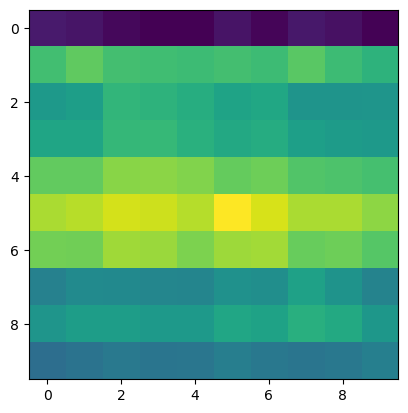

In [66]:
plt.imshow(-dists[:10,:10])

In [ ]:
# get the centroids of all the classes in the source domain
embds = [torch.zeros((50000,m.classifier[0].out_features)) for m in pt_models]
labels = [torch.zeros(50000)]
for i,m in enumerate(pt_models):
    embds[i],labels = torch.load("embds/clean224_"+model_names[i]+".pt")
    means,stds = get_class_centroids(embds,labels)

corr_embds = []
corr_labels = []
corr_embds64 = []
corr_labels64 = []
for i,corr in enumerate(corruptions):
    e,l = torch.load("embds/corr224_"+corr+".pt")
    e64,l64 = torch.load("embds/corr64_"+corr+".pt")
    corr_embds.append(e)
    corr_labels.append(l)
    corr_embds64.append(e64)
    corr_labels64.append(l64)
    # corr_means,corr_stds = get_class_centroids(corr_embds,corr_labels)
    # corr_means64,corr_stds64 = get_class_centroids(corr_embds64,corr_labels64)
# get the centroids of all the classes in the target domain

# for each class, get the distance of the target centroid to all source centroids

# then sort the list and see what spot the true class is

Text(0.5, 1.0, 'corr 64')

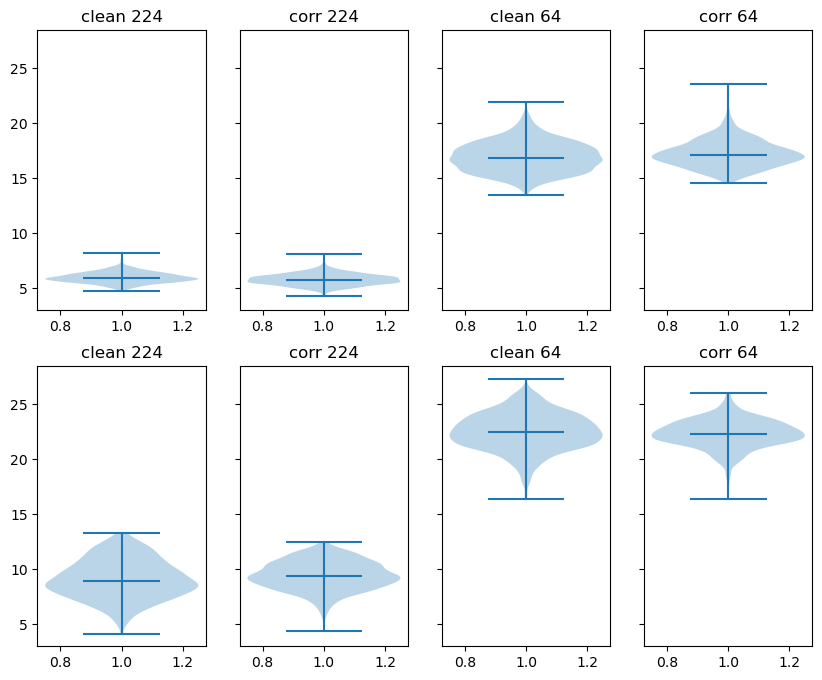

In [7]:
fig,ax = plt.subplots(2,4,figsize=(10,8),sharey=True)
# fig.subplots_adjust(hspace=0.5)
ax[0,0].violinplot(torch.norm(means,dim=1),showmedians=True)
ax[0,0].set_title("clean 224")
ax[0,2].violinplot(torch.norm(means64,dim=1),showmedians=True)
ax[0,2].set_title("clean 64")
ax[0,1].violinplot(torch.norm(corr_means,dim=1),showmedians=True)
ax[0,1].set_title("corr 224")
ax[0,3].violinplot(torch.norm(corr_means64,dim=1),showmedians=True)
ax[0,3].set_title("corr 64")
ax[1,0].violinplot(torch.norm(stds,dim=1),showmedians=True)
ax[1,0].set_title("clean 224")
ax[1,2].violinplot(torch.norm(stds64,dim=1),showmedians=True)
ax[1,2].set_title("clean 64")
ax[1,1].violinplot(torch.norm(corr_stds,dim=1),showmedians=True)
ax[1,1].set_title("corr 224")
ax[1,3].violinplot(torch.norm(corr_stds64,dim=1),showmedians=True)
ax[1,3].set_title("corr 64")

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f84a1a05340>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f84a1a052e0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f84a1a059d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f84a1a05d90>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7f84a19eb1c0>}

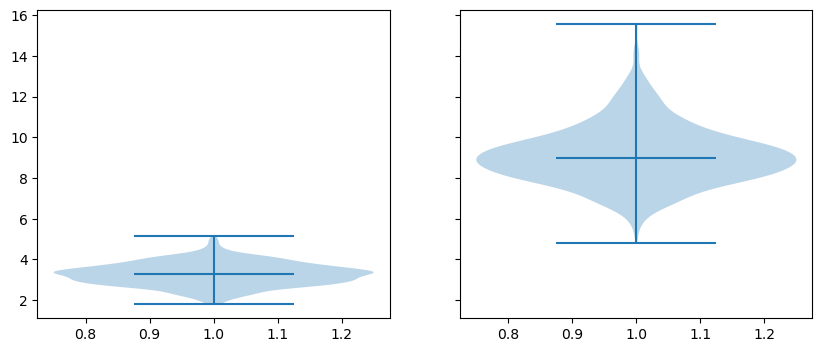

In [8]:
dist = torch.norm(means-corr_means,dim=1)
dist64 = torch.norm(means64-corr_means64,dim=1)
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
ax[0].violinplot(dist,showmedians=True)
ax[1].violinplot(dist64,showmedians=True)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f84a1f9a3d0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f84a1f9a520>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f84a1f894f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f84a1f899a0>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7f84a1f89220>}

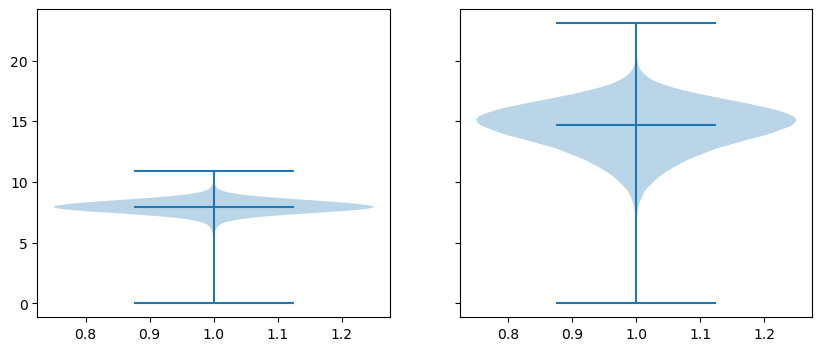

In [9]:
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
ax[0].violinplot(torch.cdist(means,means).view(-1),showmedians=True)
ax[1].violinplot(torch.cdist(means64,means64).view(-1),showmedians=True)


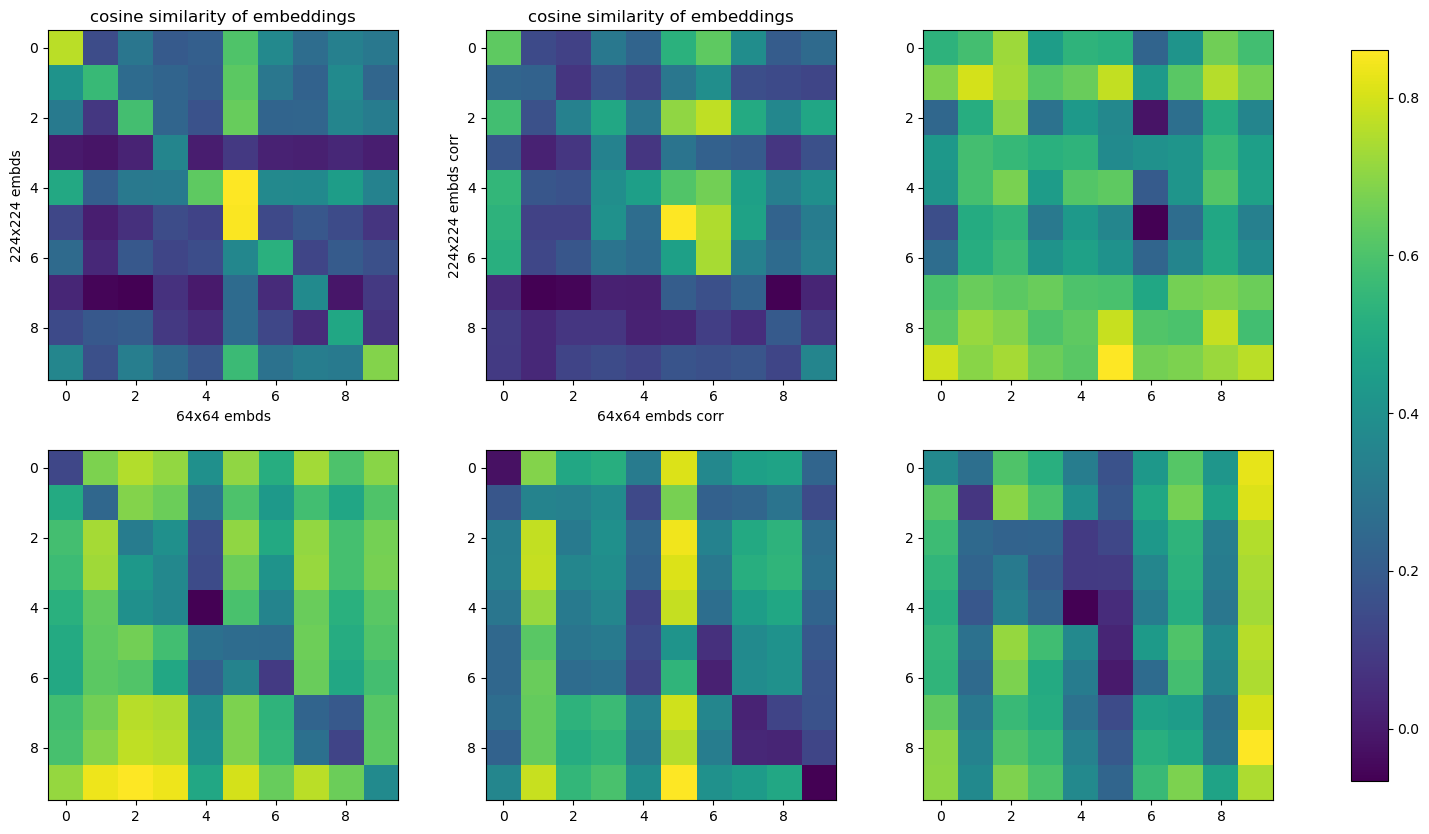

In [458]:
sim_mat = (means/torch.norm(means,dim=1)[:,None]).T@(means64/torch.norm(means64,dim=1)[:,None])
sim_mat2 = (corr_means/torch.norm(corr_means,dim=1)[:,None]).T@(corr_means64/torch.norm(corr_means64,dim=1)[:,None])

sim_mat_e = torch.cdist(means,means64)
sim_mat2_e = torch.cdist(corr_means,corr_means64)
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].imshow(sim_mat[:10,:10])
ax[0,0].set_xlabel("64x64 embds")
ax[0,0].set_ylabel("224x224 embds")
ax[0,0].set_title("cosine similarity of embeddings")
im = ax[0,1].imshow(sim_mat2[:10,:10])
ax[0,1].set_xlabel("64x64 embds corr")
ax[0,1].set_ylabel("224x224 embds corr")
ax[0,1].set_title("cosine similarity of embeddings")
ax[0,2].imshow(sim_mat[:10,:10]-sim_mat2[:10,:10])
ax[1,0].imshow(sim_mat_e[:10,:10])
ax[1,1].imshow(sim_mat2_e[:10,:10])
ax[1,2].imshow(sim_mat_e[:10,:10]-sim_mat2_e[:10,:10])
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)

# Set the data ordering

In [7]:
from torch.utils.data import Subset

from torch.utils.data.sampler import Sampler

class CustomOrder(Sampler):
    def __init__(self, dataset):
        self.order = torch.randperm(len(dataset),)
        
    def __iter__(self):
        return iter(self.order)
    
    def __len__(self):
        return len(self.order)

rand_order = CustomOrder(clean_val_loader.dataset)
rand_corr_order = torch.randperm(15)

# Online Euclidean
Distance from teacher to student
1. clean --> clean
2. clean --> corr1
3. clean --> corr2

In [8]:
num_imgs = 0
transition_points = [1999]
corr_idx = 0
corr_img_count = 0
idxs = []
distances = torch.zeros((16,5200))
cos_sim = torch.zeros((16,5200))
mag_dist = torch.zeros((16,5200))
mag_sim = torch.zeros((16,5200))
phase_dist = torch.zeros((16,5200))
phase_sim = torch.zeros((16,5200))
ent_diff = torch.zeros((16,5200))
rand_order = CustomOrder(clean_val_loader.dataset)
rand_corr_order = torch.randperm(15)
embds,labels = torch.load("embds/clean224.pt")
embds64,labels64 = torch.load("embds/clean64.pt")
from torch.distributions import Categorical

for i in range(16):
    num_imgs = 0
    for sample_idx in tqdm(rand_order):
        # corruptions start after the first 2000 images
        if num_imgs-1 >= 1999:
            # for the first one use clean images as a control
            if corr_img_count == 0:
                corr_embds,corr_labels = torch.load("embds/clean224.pt")
                corr_embds64,corr_labels64 = torch.load("embds/clean64.pt")
            # each corruption lasts 3200 images
            if corr_img_count == 3200:
                corr_idx += 1
                corr_img_count = 0
                transition_points.append(num_imgs)
                corr_embds,corr_labels = torch.load("embds/corr224_"+corruptions[i-1]+".pt")
                corr_embds64,corr_labels64 = torch.load("embds/corr64_"+corruptions[i-1]+".pt")
            # get the image at the specified index
            emb = corr_embds[sample_idx]
            target = corr_labels[sample_idx]
            emb64 = corr_embds64[sample_idx]
            target64 = corr_labels64[sample_idx]
            corr_img_count += 1
        else:
            emb = embds[sample_idx]
            target = labels[sample_idx]
            emb64 = embds64[sample_idx]
            target64 = labels64[sample_idx]

        num_imgs += 1

        # get the euclidean distance and cosine similarity between teacher and student
        if (num_imgs-1) % 10 == 0:
            distances[i][num_imgs-1] = (emb-emb64).pow(2).sum().sqrt()
            cos_sim[i][num_imgs-1] = ((emb64/emb64.norm()) @ (emb/emb.norm()).T)
            freq = torch.fft.fft(emb)
            freq64 = torch.fft.fft(emb64)
            mag_dist[i][num_imgs-1] = (freq.abs()-freq64.abs()).pow(2).sum().sqrt()
            mag_sim[i][num_imgs-1] = ((freq64.abs()/freq64.abs().norm()) @ (freq.abs()/freq.abs().norm()).T)
            phase_dist[i][num_imgs-1] = (freq.angle()-freq64.angle()).pow(2).sum().sqrt()
            phase_sim[i][num_imgs-1] = ((freq64.angle()/freq64.angle().norm()) @ (freq.angle()/freq.angle().norm()).T)
            ent_diff[i][num_imgs-1] = Categorical(probs = F.softmax(emb64)).entropy()
        else:
            distances[i][num_imgs-1] = distances[i][num_imgs-2]
            cos_sim[i][num_imgs-1] = cos_sim[i][num_imgs-2]
            mag_dist[i][num_imgs-1] = mag_dist[i][num_imgs-2]
            mag_sim[i][num_imgs-1] = mag_sim[i][num_imgs-2]
            phase_dist[i][num_imgs-1] = phase_dist[i][num_imgs-2]
            phase_sim[i][num_imgs-1] = phase_sim[i][num_imgs-2]
            ent_diff[i][num_imgs-1] = ent_diff[i][num_imgs-2]
        idxs.append(num_imgs)
        if num_imgs == 5200:
            break

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_352877/1899030740.py:52: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  cos_sim[i][num_imgs-1] = ((emb64/emb64.norm()) @ (emb/emb.norm()).T)
/tmp/ipykernel_352877/1899030740.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ent_diff[i][num_imgs-1] = Categorical(probs = F.softmax(emb64)).entropy()
 10%|█         | 5199/50000 [00:00<00:06, 6723.42it/s] 


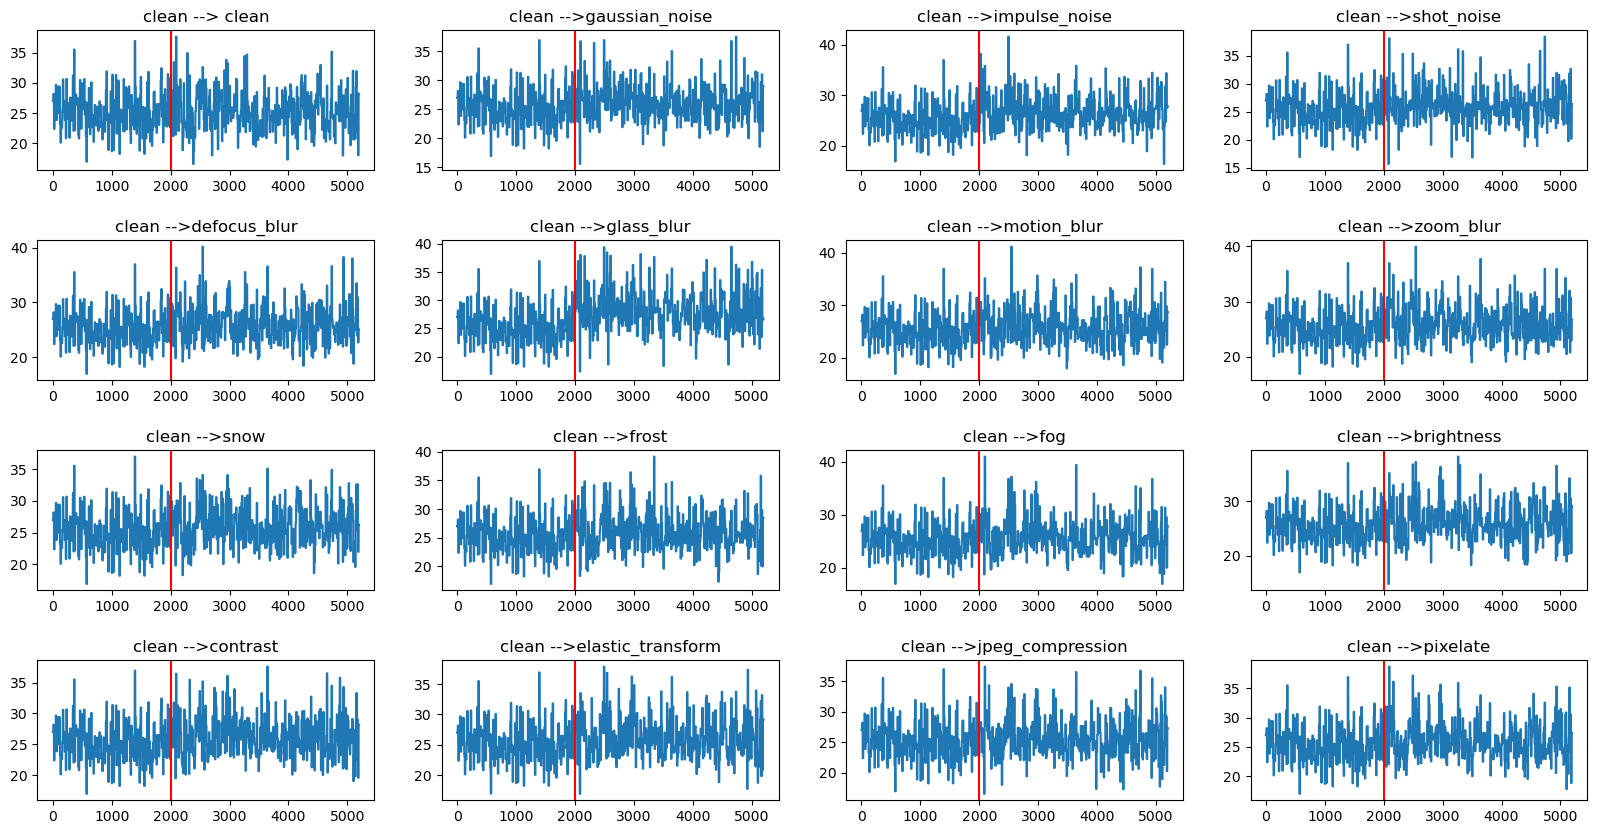

In [12]:
fig,ax = plt.subplots(4,4,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
every_ten = np.arange(0,5200,10)
for i in range(4):
    for j in range(4):
        ax[i,j].plot(distances[i*4+j][:])
        if i*4+j == 0:
            ax[i,j].set_title("clean --> clean")
        else:
            ax[i,j].set_title("clean -->"+corruptions[i*4+j-1])
        ax[i,j].axvline(x=2000, label = "domain shift",color='r')

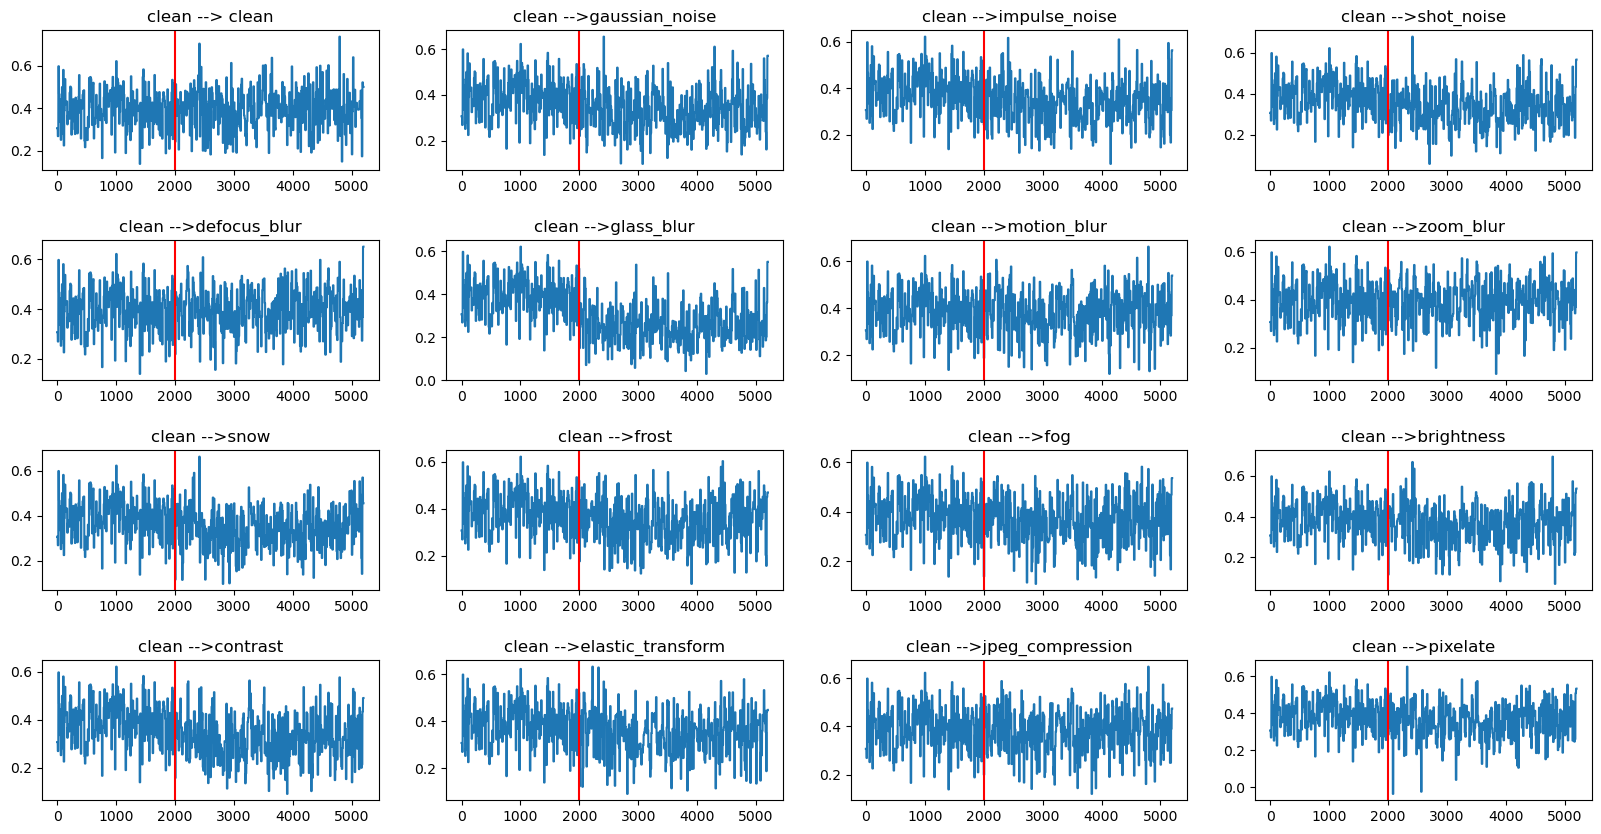

In [13]:
fig,ax = plt.subplots(4,4,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
for i in range(4):
    for j in range(4):
        ax[i,j].plot(cos_sim[i*4+j][:])
        if i*4+j == 0:
            ax[i,j].set_title("clean --> clean")
        else:
            ax[i,j].set_title("clean -->"+corruptions[i*4+j-1])
        ax[i,j].axvline(x=2000, label = "domain shift",color='r')

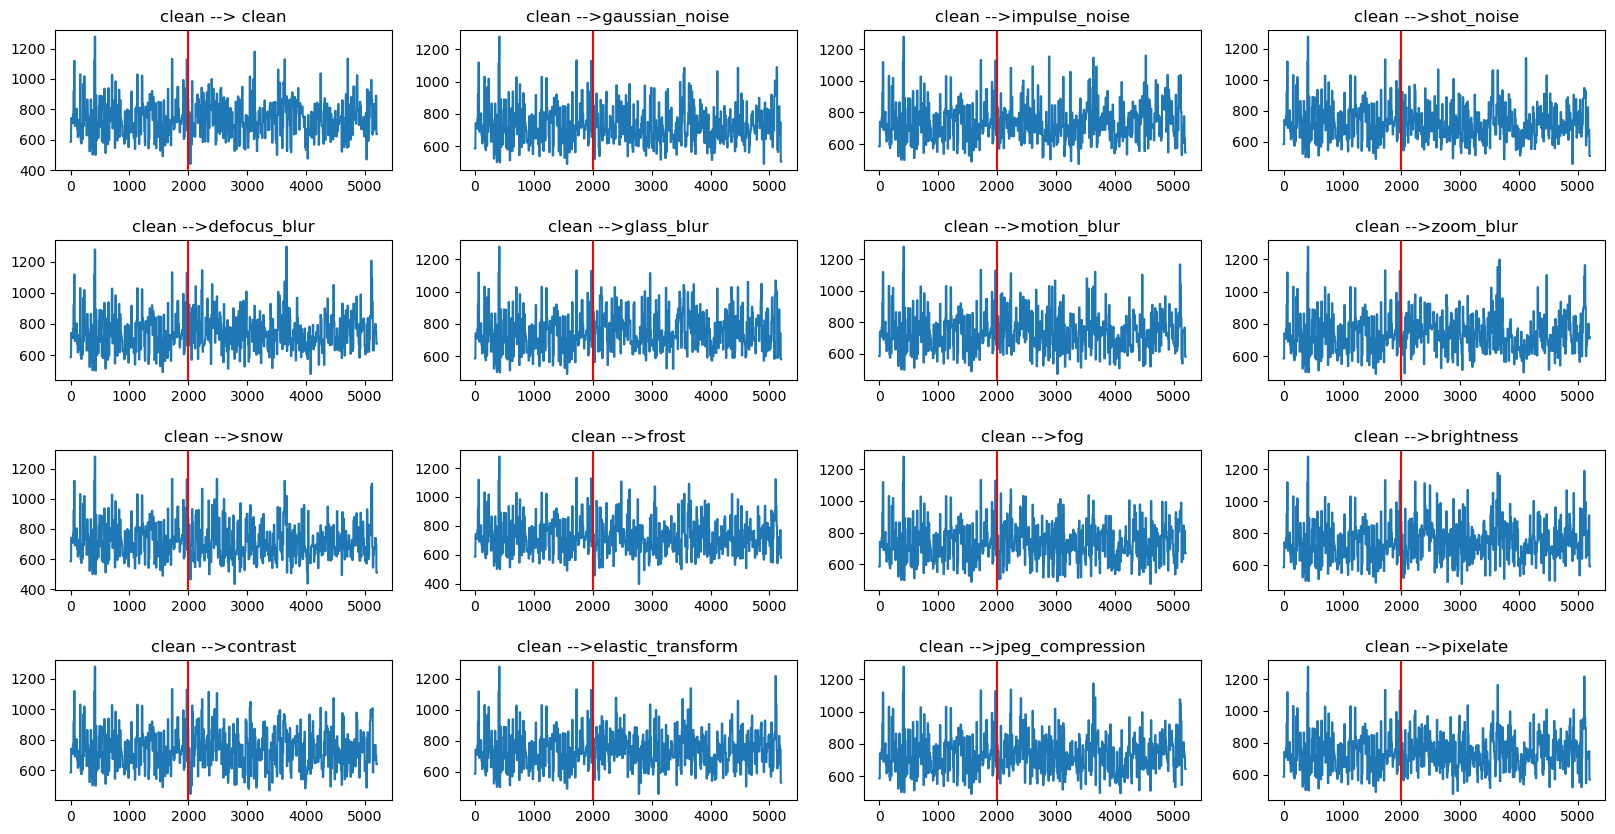

In [15]:
fig,ax = plt.subplots(4,4,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
for i in range(4):
    for j in range(4):
        ax[i,j].plot(mag_dist[i*4+j][:])
        if i*4+j == 0:
            ax[i,j].set_title("clean --> clean")
        else:
            ax[i,j].set_title("clean -->"+corruptions[i*4+j-1])
        ax[i,j].axvline(x=2000, label = "domain shift",color='r')

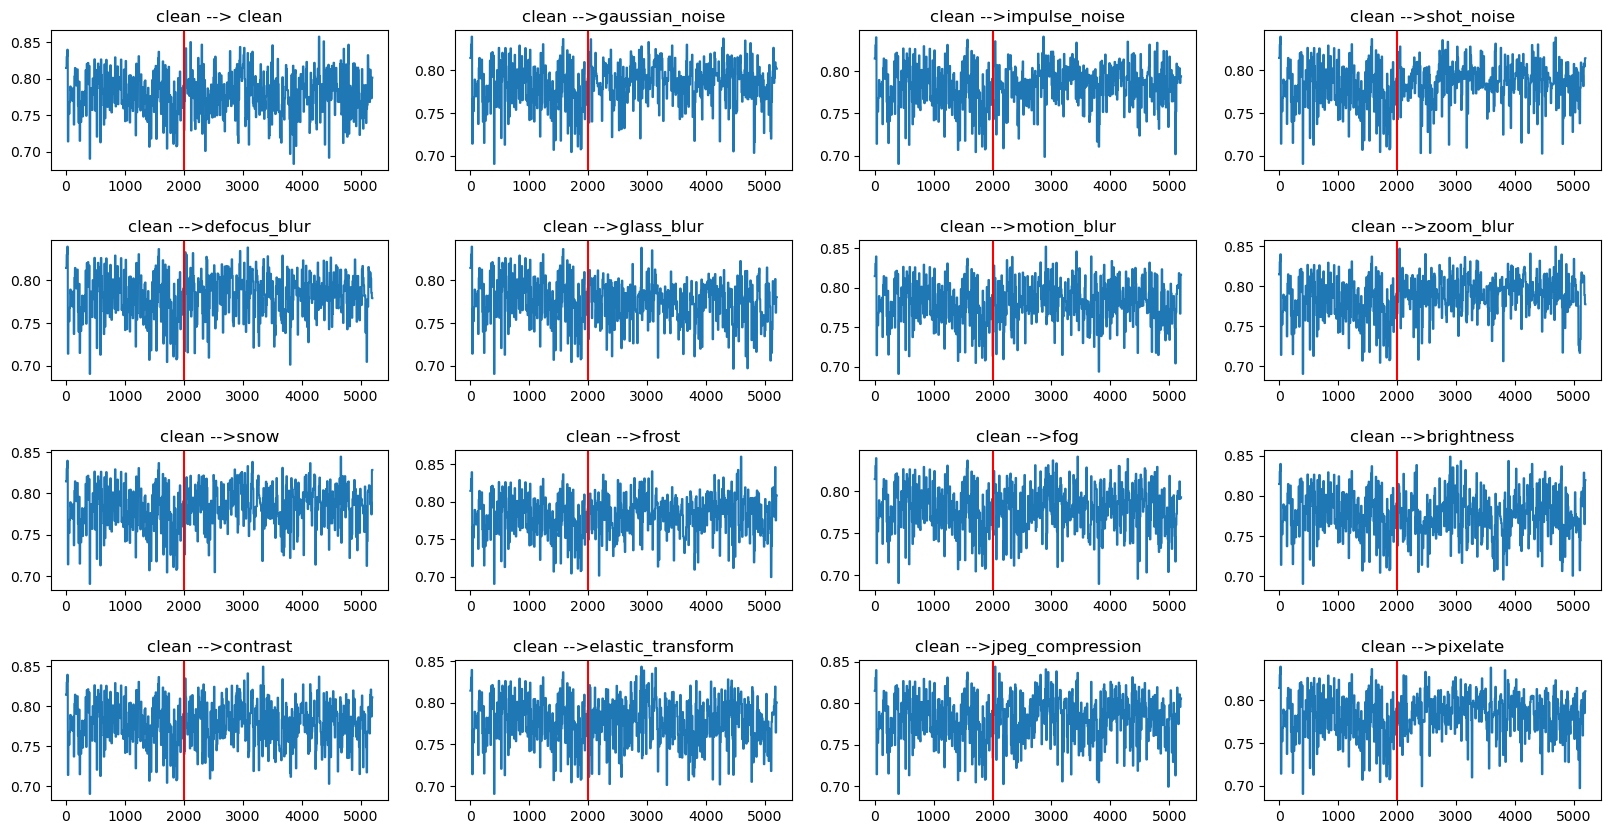

In [16]:
fig,ax = plt.subplots(4,4,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
for i in range(4):
    for j in range(4):
        ax[i,j].plot(mag_sim[i*4+j][:])
        if i*4+j == 0:
            ax[i,j].set_title("clean --> clean")
        else:
            ax[i,j].set_title("clean -->"+corruptions[i*4+j-1])
        ax[i,j].axvline(x=2000, label = "domain shift",color='r')

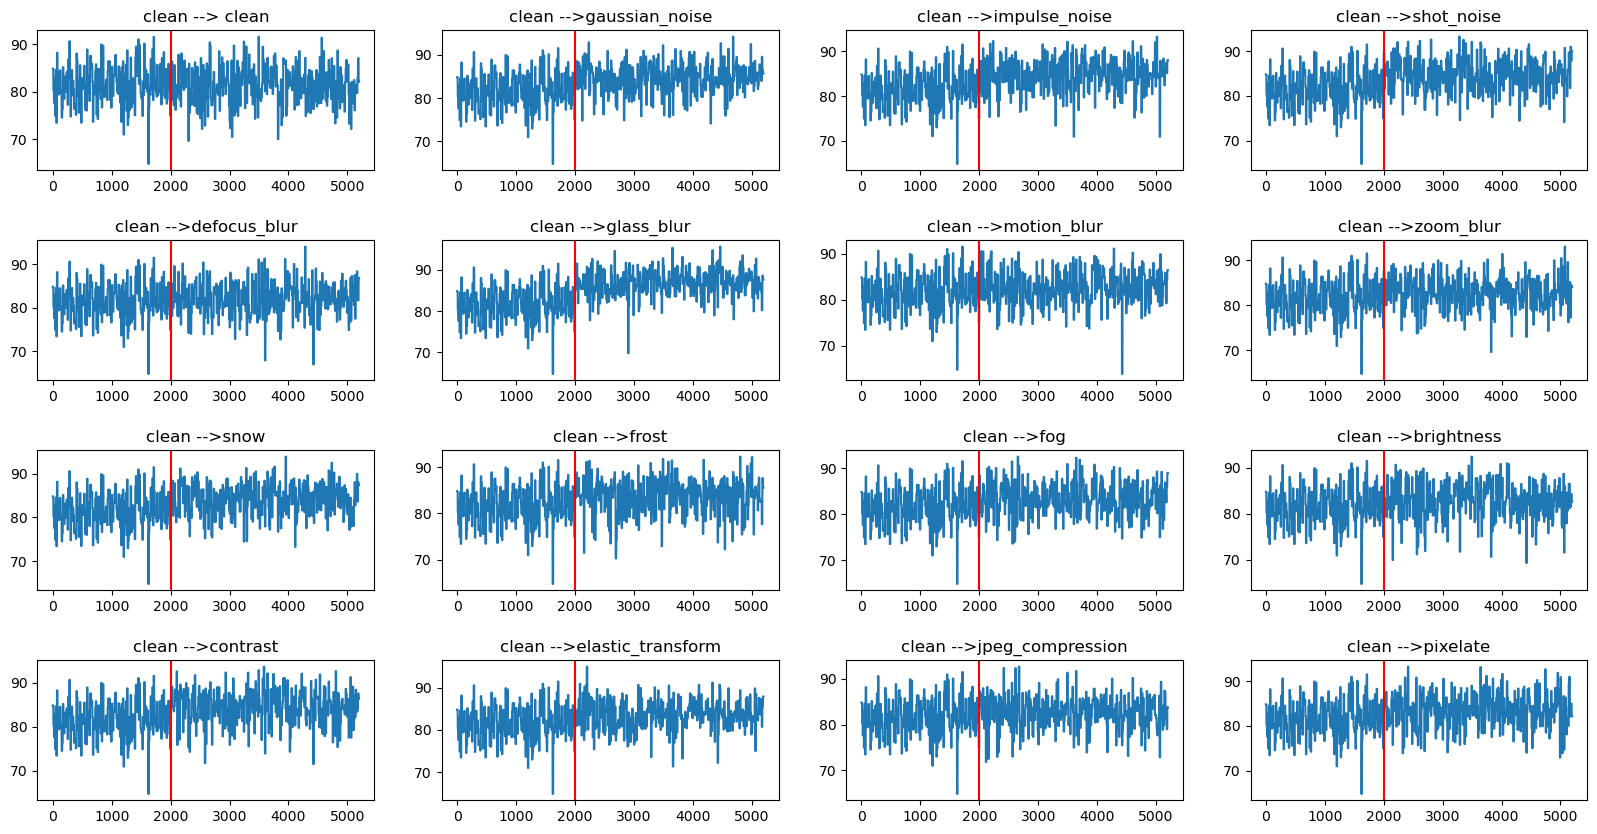

In [17]:
fig,ax = plt.subplots(4,4,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
for i in range(4):
    for j in range(4):
        ax[i,j].plot(phase_dist[i*4+j][:])
        if i*4+j == 0:
            ax[i,j].set_title("clean --> clean")
        else:
            ax[i,j].set_title("clean -->"+corruptions[i*4+j-1])
        ax[i,j].axvline(x=2000, label = "domain shift",color='r')

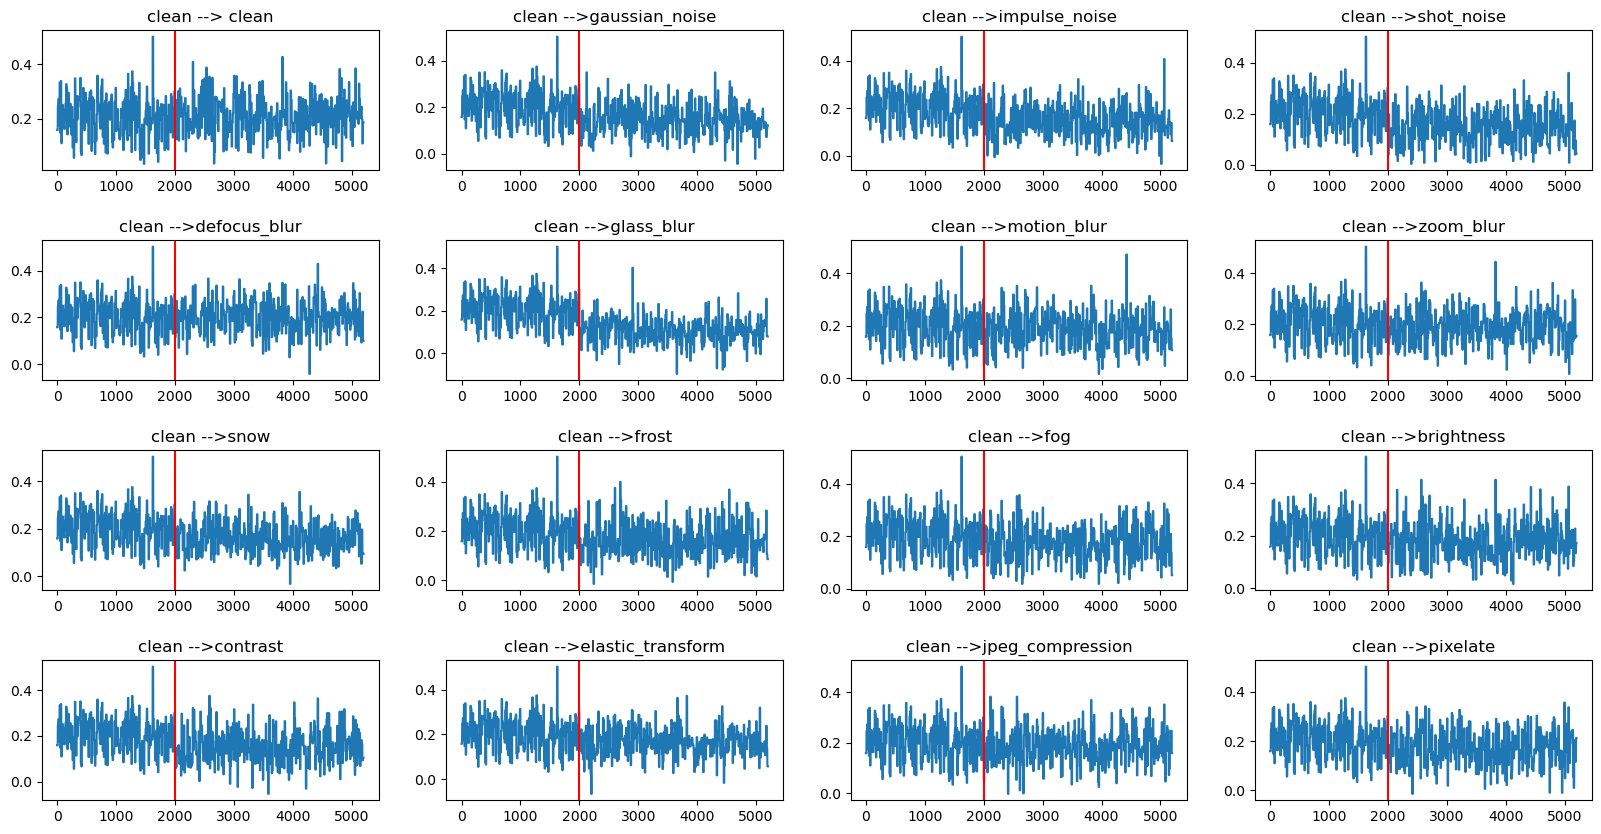

In [18]:
fig,ax = plt.subplots(4,4,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
for i in range(4):
    for j in range(4):
        ax[i,j].plot(phase_sim[i*4+j][:])
        if i*4+j == 0:
            ax[i,j].set_title("clean --> clean")
        else:
            ax[i,j].set_title("clean -->"+corruptions[i*4+j-1])
        ax[i,j].axvline(x=2000, label = "domain shift",color='r')

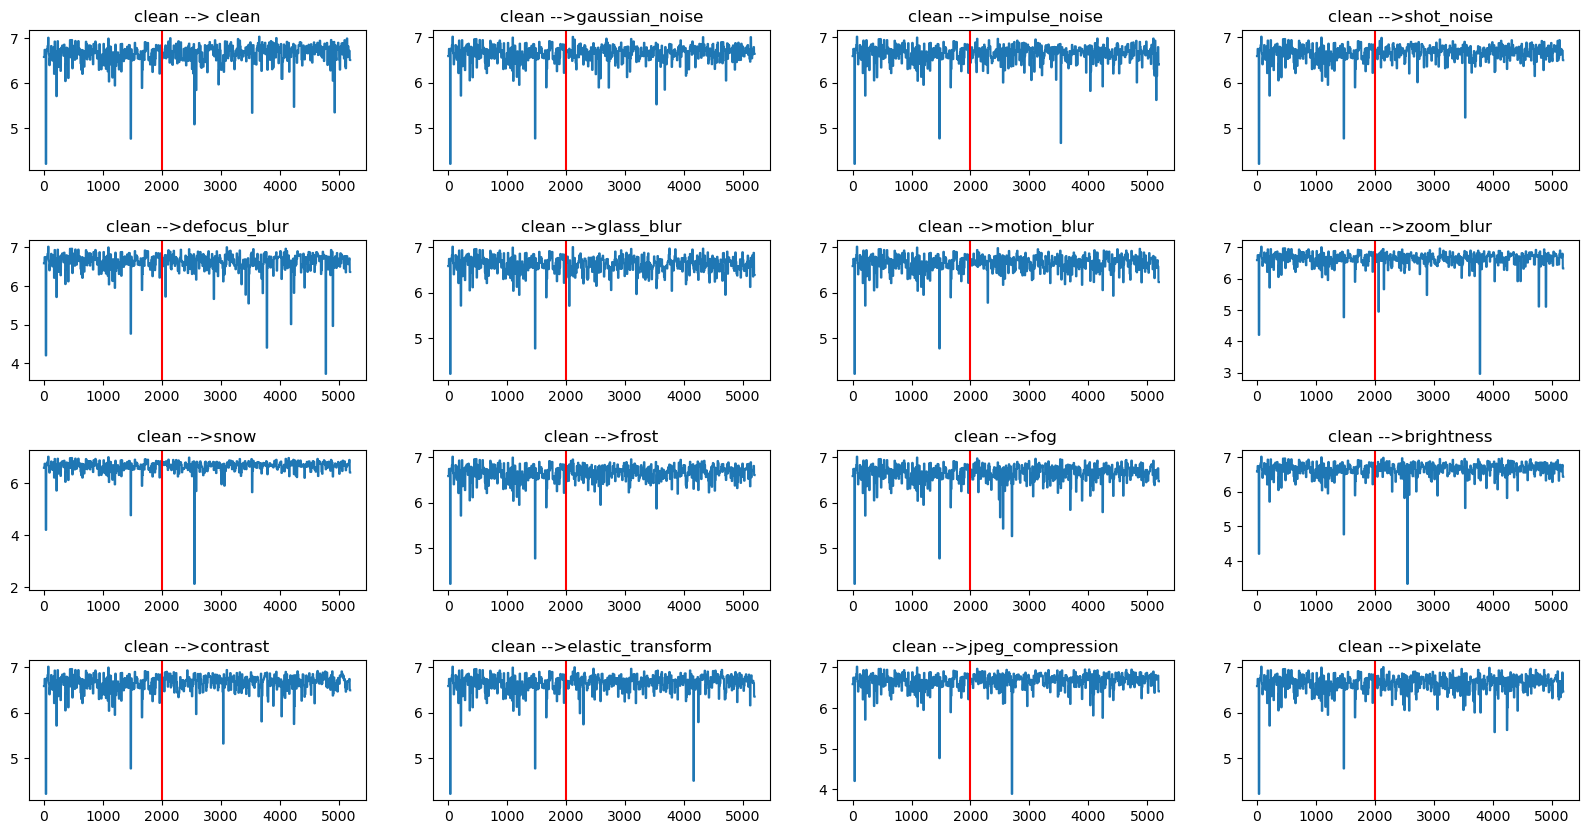

In [9]:
fig,ax = plt.subplots(4,4,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
for i in range(4):
    for j in range(4):
        ax[i,j].plot(ent_diff[i*4+j][:])
        if i*4+j == 0:
            ax[i,j].set_title("clean --> clean")
        else:
            ax[i,j].set_title("clean -->"+corruptions[i*4+j-1])
        ax[i,j].axvline(x=2000, label = "domain shift",color='r')

# Maximize cosine similarity

In [347]:
import copy

model64_CS = copy.deepcopy(model64)
model64_CS.eval()
activationCS = {}
def get_activationCS(name):
    def hook(model, input, output):
        activationCS[name] = output.detach()
    return hook
model64_CS.classifier[0].register_forward_hook(get_activationCS('emb'))
model64_CS.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
num_imgs = 0
transition_points = [1999]
corr_idx = 0
corr_img_count = 0
idxs = []
distances = torch.zeros((16,5200))
cos_sim = torch.zeros((16,5200))
rand_order = CustomOrder(clean_val_loader.dataset)
rand_corr_order = torch.randperm(15)
embds,labels = torch.load("embds/clean224.pt")
embds64,labels64 = torch.load("embds/clean64.pt")
start_at_zero = False
for i in range(4):
    print("i",i)
    # for each transition, reset the model
    # model64_CS = copy.deepcopy(model64)
    # model64_CS.eval()
    # start_train=False
    # activationCS = {}
    # def get_activationCS(name):
    #     def hook(model, input, output):
    #         activationCS[name] = output#.detach()
    #     return hook
    # model64_CS.classifier[0].register_forward_hook(get_activationCS('emb'))
    # opt = torch.optim.SGD(model64_CS.parameters(),0.1,momentum=0.9)
    num_imgs = 0
    
    for sample_idx in tqdm(rand_order):
        # corruptions start after the first 2000 images
        if num_imgs-1 >= 250:
            start_train=True
            # model64_CS.train()
            # for the first one use clean images as a control
            if corr_img_count == 0:
                print("clean-->clean")
                # corr_embds,corr_labels = torch.load("embds/clean224.pt")
                # corr_embds64,corr_labels64 = torch.load("embds/clean64.pt")
                start_at_zero = True
            
            # each corruption lasts 3200 images
            if corr_img_count == 250:
                if start_at_zero == True:
                    start_at_zero = False
                    print("finished clean-->clean")
                else:
                    corr_idx += 1
                corr_img_count = 0
                print("corr idx:",corr_idx)
                print("clean-->",corruptions[i-1])
                transition_points.append(num_imgs)
                corr_embds,corr_labels = torch.load("embds/corr224_"+corruptions[i-1]+".pt")
                corr_embds64,corr_labels64 = torch.load("embds/corr64_"+corruptions[i-1]+".pt")
            if start_at_zero:
                img64,target64 = clean_val_loader64.dataset[sample_idx]
                img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
                img,target = clean_val_loader.dataset[sample_idx]
                img,target = img.to('cuda'),torch.tensor(target).to('cuda')
            else:
                img64,target64 = corr_val_loaders64[rand_corr_order[corr_idx]].dataset[sample_idx]
                img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
                img,target = corr_val_loaders[rand_corr_order[corr_idx]].dataset[sample_idx]
                img,target = img.to('cuda'),torch.tensor(target).to('cuda')

            # get the image at the specified index
            _emb = corr_embds[sample_idx]
            l = corr_labels[sample_idx]
            _emb64 = corr_embds64[sample_idx]
            l64 = corr_labels64[sample_idx]
            # get the embedding
            # opt.zero_grad()
            with torch.no_grad():
                out_dummy = model(img.unsqueeze(0))
                emb = activationT['emb'].to('cpu').view(-1)
                out64_dummy = model64(img64.unsqueeze(0))
                emb64 = activationS['emb'].to('cpu').view(-1)

            print("saved labels:",l," ",l64)
            print("curr_labels:",target, " ", target64)
            # out64_dummy = model64(img64.unsqueeze(0))
            # emb642 = activationS['emb'].to('cpu')
            # print("saved:",_emb.size())
            # print("curr:",emb.size())
            # print("saved64:",_emb64.size())
            # print("curr64:",emb64.size())
            corr_img_count += 1
        else:
            with torch.no_grad():
                # emb = embds[sample_idx]
                # target = labels[sample_idx]
                img64,target64 = clean_val_loader64.dataset[sample_idx]
                img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
                out64_dummy = model64(img64.unsqueeze(0))
                emb64 = activationS['emb'].to('cpu')

                img,target = clean_val_loader.dataset[sample_idx]
                img,target = img.to('cuda'),torch.tensor(target).to('cuda')
                out_dummy = model(img.unsqueeze(0))
                emb = activationT['emb'].to('cpu')

        num_imgs += 1
        

        # get the euclidean distance and cosine similarity between teacher and student
        if (num_imgs-1) % 1 == 0:
            distances[i][num_imgs-1] = (emb-emb64).pow(2).sum().sqrt()
            loss = ((emb64/emb64.norm()) @ (emb/emb.norm()).T)
            cos_sim[i][num_imgs-1] = loss

            # if start_train:
            #     # print("train")
            #     # minimize the negative cosine similarity
            #     loss = -loss
            #     loss.backward()
            #     opt.step()
        else:
            distances[i][num_imgs-1] = distances[i][num_imgs-2]
            cos_sim[i][num_imgs-1] = cos_sim[i][num_imgs-2]
        
        idxs.append(num_imgs)
        if num_imgs == 500:
            break

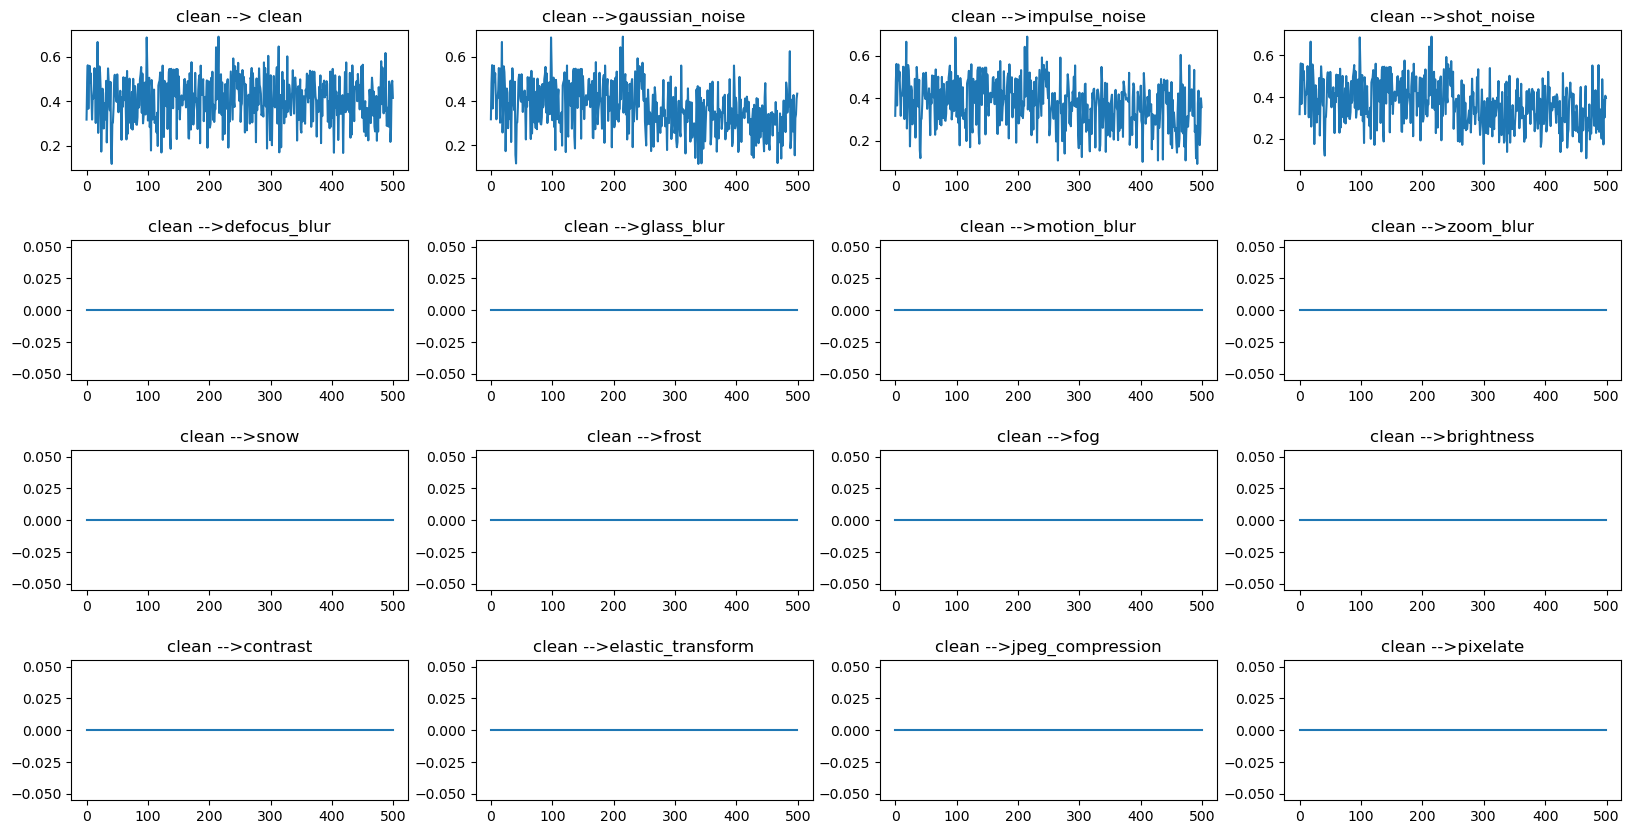

In [442]:
fig,ax = plt.subplots(4,4,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
for i in range(4):
    for j in range(4):
        ax[i,j].plot(cos_sim[i*4+j][:500].detach())
        if i*4+j == 0:
            ax[i,j].set_title("clean --> clean")
        else:
            ax[i,j].set_title("clean -->"+corruptions[i*4+j-1])
        # ax[i,j].axvline(x=1999, label = "domain shift",color='r')

# Online distance

In [472]:
num_imgs = 0
transition_points = [1999]
corr_idx = 0
corr_img_count = 0
idxs = []
distances = torch.zeros(50000)
cos_sim = torch.zeros(50000)
corr_online_acc_KD = []

for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 1999:
        # each corruption lasts 3300 images
        if corr_img_count == 3200:
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        img,target = corr_val_loaders[rand_corr_order[corr_idx]].dataset[sample_idx]
        img64,target64 = corr_val_loaders64[rand_corr_order[corr_idx]].dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
        corr_img_count += 1
    else:
        img,target = clean_val_loader.dataset[sample_idx]
        img64,target64 = clean_val_loader64.dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

    num_imgs += 1

    # get the prediction of small model
    out64 = model64_KD(img64.unsqueeze(0))
    pred64 = out64.argmax(dim=1).item()
    res64 = (pred64 == target64.item())
    

    # get the embedding
    model64(img64.unsqueeze(0))
    model64_emb = activationS['emb'].to('cpu')

    model(img.unsqueeze(0))
    model_emb = activationT['emb'].to('cpu')

    distances[num_imgs-1] = (model_emb-model64_emb).pow(2).sum(dim=1).sqrt()
    cos_sim[num_imgs-1] = ((model64_emb/model64_emb.norm()) @ (model_emb/model_emb.norm()).T)
    
    idxs.append(num_imgs)

100%|██████████| 50000/50000 [17:18<00:00, 48.15it/s]


In [473]:
run = []
tot = 0
run_std = 0
from collections import deque 
deq = deque(maxlen=100)
deq2 = deque(maxlen=100)
run2 = [0]
blip = []
import math
for i,it in enumerate(cos_sim):
    if i % 10 == 0:
        # update the running mean
        tot = 0.95*tot + 0.05*it
        run.append(tot)
        deq.append(tot)
        deq2.append(tot)
        # update the running std
        if len(deq) > 1:
            s0 = len(deq)
            s1 = sum(x for x in deq)
            s2 = sum(x*x for x in deq)
            run_std = math.sqrt((s0 * s2 - s1 * s1)/(s0 * (s0 - 1)))
            run2.append(run_std)
        if len(deq) == 100:
            if abs(deq2[0]-deq2[99]) > 4*run_std:
                blip.append(i)

    else:
        run.append(tot)
        run2.append(run_std)

(0.0, 30000.0)

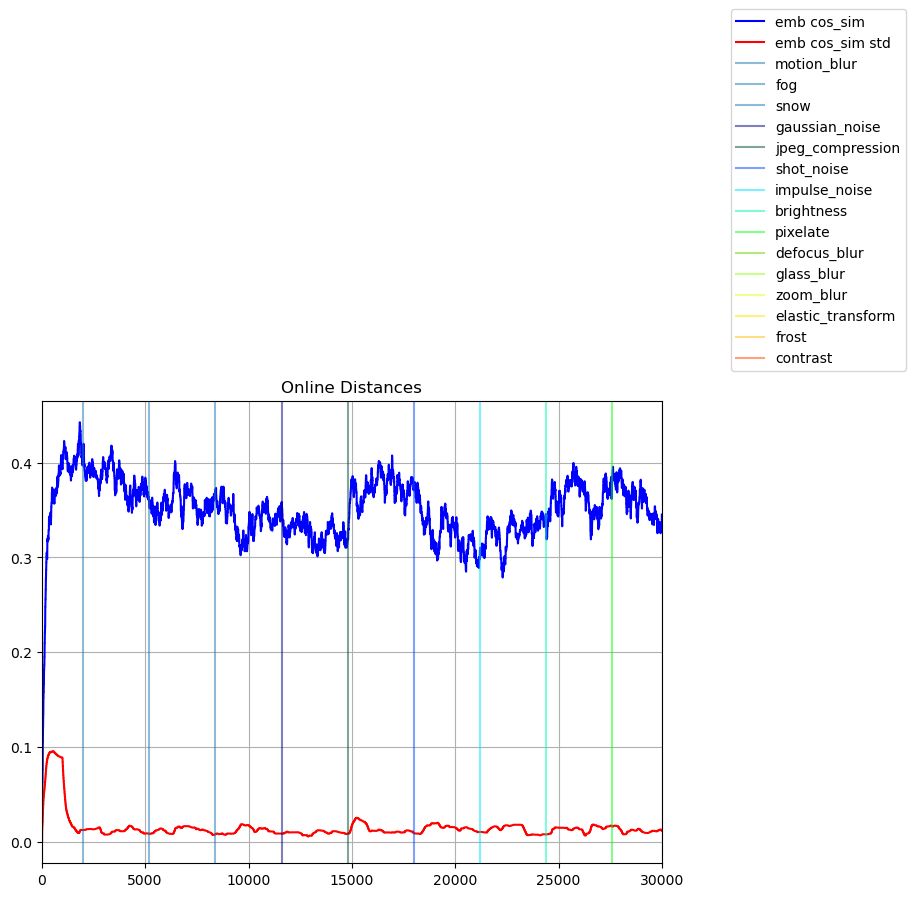

In [474]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
# ax1.plot(idxs,distances,label='emb distances',color='red')
ax1.plot(idxs,run,label='emb cos_sim',color='blue')
ax1.plot(idxs,run2,label='emb cos_sim std',color='red')
# for i,x in enumerate(blip):
#     plt.axvline(x =x,color='k')
# ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[0:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])

ax1.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()
plt.title("Online Distances")
# plt.ylim([0,1])
plt.xlim([0,30000])

In [187]:
deq

deque([tensor(0.3308),
       tensor(0.3303),
       tensor(0.3286),
       tensor(0.3306),
       tensor(0.3359),
       tensor(0.3283),
       tensor(0.3244),
       tensor(0.3187),
       tensor(0.3156),
       tensor(0.3149),
       tensor(0.3122),
       tensor(0.3139),
       tensor(0.3161),
       tensor(0.3266),
       tensor(0.3264),
       tensor(0.3215),
       tensor(0.3202),
       tensor(0.3188),
       tensor(0.3215),
       tensor(0.3167),
       tensor(0.3242),
       tensor(0.3255),
       tensor(0.3229),
       tensor(0.3302),
       tensor(0.3360),
       tensor(0.3316),
       tensor(0.3384),
       tensor(0.3413),
       tensor(0.3479),
       tensor(0.3458),
       tensor(0.3411),
       tensor(0.3412),
       tensor(0.3407),
       tensor(0.3327),
       tensor(0.3351),
       tensor(0.3324),
       tensor(0.3293),
       tensor(0.3263),
       tensor(0.3300),
       tensor(0.3273),
       tensor(0.3220),
       tensor(0.3260),
       tensor(0.3200),
       tens

In [5]:
from torch.distributions import Categorical

p_tensor = torch.Tensor([0.1, 0.2, 0.4, 0.3])
entropy2 = Categorical(probs = p_tensor).entropy()
print(entropy2)

tensor(1.2799)


In [8]:
from torch.distributions import Categorical
class FC(torch.nn.Module):
    def __init__(self):
      super(FC, self).__init__()
      self.c = torch.nn.Linear(1280,1000)
    def forward(self,x):
      if len(x.shape) > 1:
        return F.softmax(self.c(x),dim=1)
      else:
        return F.softmax(self.c(x),dim=0)
fc = FC()
fc64 = FC()

with torch.no_grad():
  fc.c.weight[:,:] = model.classifier[3].weight[:,:]
  fc.c.bias[:] = model.classifier[3].bias[:]
  fc64.c.weight[:,:] = model64.classifier[3].weight[:,:]
  fc64.c.bias[:] = model64.classifier[3].bias[:]

  # # print(sum(fc(corr_embds[50:100]).argmax(dim=1) == 1))
  # noise = torch.normal(0,1,size=(1,1280)).view(-1)

  # n = 20
  # out = fc(corr_embds[n])
  # out_n = fc(corr_embds[n]+noise)
  # print("Ground Truth:", int(labels[n].item()))
  # # print(f"{'| Prediction':15s}{'| Confidence':15s} {'| Entropy':15s} |")
  # # print(f"{'| a':15s}{'| a':15s} {'| ':15s} |")
  # # print(f"{'| b':15s}{'| b':15s} {'| b':15s} |")
  # print("Entropy before:",Categorical(probs=out).entropy().item())
  # print("Entropy after :",Categorical(probs=out_n).entropy().item())
  # print("Prediction before:",out.argmax().item())
  # print("Prediction noise :",out_n.argmax().item())
  # print("Confidence before:",out.max().item())
  # print("Confidence after :",out_n.max().item())
  # print(f"{'| Prediction':15s}{'| Confidence':15s} {'| Entropy':15s} |")
  # print("")
# rand_idxs = torch.rand_perm()
# corr_labels[50:100]

Method: perturb the embedding a few times and if it is relatively stable, we can trust the prediction, otherwise we assume the prediction is unreliable
-challenge is what to set the noise level to, this is dataset and model specific (learn online)
    -use the embedding norms as a proxy
-challenge, what do we define as robust, only changed 1 out of 5 times?

In [16]:
# all confs and results on clean sets
clean_confidences = torch.load("accs/clean_confs224.pt")
clean_results = torch.load("accs/clean_results224.pt")
clean_confidences64 = torch.load("accs/clean_confs64.pt")
clean_results64 = torch.load("accs/clean_results64.pt")

# all confs and results on corrupted sets
corr_confidences = torch.load("accs/corr_confs224.pt")
corr_results = torch.load("accs/corr_results224.pt")
corr_confidences64 = torch.load("accs/corr_confs64.pt")
corr_results64 = torch.load("accs/corr_results64.pt")

In [77]:
rel = 0
rel64 = 0
acc = 0
acc64 = 0
# iterate over all embeddings for a corruption type
e_i = 0
accs = []
accs64 = []
rels = []
rels64 = []
a = 0
for ct in range(15):
    rand_sample = torch.randperm(50000)[0:3000]
    e_i = 0
    rel = 0
    rel64 = 0
    acc = 0
    acc64 = 0
    a = 0
    n = 0
    for e in tqdm(corr_embds[ct][rand_sample]):
        conf = corr_confidences64[50000*ct+rand_sample[e_i]]
        e64 = corr_embds64[ct][rand_sample[e_i]]
        count = 0
        count64 = 0
        if conf < 0.5:
            # pass in five noisy versions
            for i in range(3):
                noise = torch.normal(0,0.32,size=(1,1280)).view(-1)
                noise64 = torch.normal(0,0.72,size=(1,1280)).view(-1)
                out = fc(e)
                out_n = fc(e+noise)
                out64 = fc64(e64)
                out_n64 = fc64(e64+noise64)
                # if the prediction is the same as the original, increment the count
                if out.argmax().item() == out_n.argmax().item():
                    count += 1
                if out64.argmax().item() == out_n64.argmax().item():
                    count64 += 1
            # 3/5 stable predictions is considered a correct prediction
            if count == 3:
                rel += 1
                if corr_labels[ct][rand_sample[e_i]].item() == out.argmax().item():
                    acc += 1
            if count64 == 3:
                rel64 += 1
                if corr_labels64[ct][rand_sample[e_i]].item() == out64.argmax().item():
                    acc64 += 1
            if corr_labels64[ct][rand_sample[e_i]].item() == out64.argmax().item():
                a += 1
            n += 1
        e_i += 1
    accs.append(acc)
    accs64.append(acc64)
    rels.append(rel)
    rels64.append(rel64)
    print(rel,acc,acc/rel)
    print(rel64,acc64,acc64/rel64)
    print(a,"/",n,"=",a/n)
    print("------")

100%|██████████| 3000/3000 [00:01<00:00, 1941.99it/s]


1196 813 0.6797658862876255
139 17 0.1223021582733813
220 / 1927 = 0.1141670991177997
------


100%|██████████| 3000/3000 [00:01<00:00, 1955.86it/s]


1155 816 0.7064935064935065
123 15 0.12195121951219512
225 / 1922 = 0.11706555671175858
------


100%|██████████| 3000/3000 [00:01<00:00, 1934.56it/s]


1145 797 0.6960698689956332
120 18 0.15
211 / 1904 = 0.11081932773109243
------


100%|██████████| 3000/3000 [00:01<00:00, 2169.79it/s]


929 554 0.596340150699677
119 28 0.23529411764705882
222 / 1690 = 0.13136094674556212
------


100%|██████████| 3000/3000 [00:01<00:00, 1825.41it/s]


1171 776 0.6626814688300597
123 12 0.0975609756097561
115 / 1964 = 0.05855397148676171
------


100%|██████████| 3000/3000 [00:01<00:00, 2104.61it/s]


1034 722 0.6982591876208898
103 21 0.20388349514563106
241 / 1655 = 0.14561933534743202
------


100%|██████████| 3000/3000 [00:01<00:00, 2075.63it/s]


941 587 0.6238044633368757
132 24 0.18181818181818182
237 / 1777 = 0.13337084974676422
------


100%|██████████| 3000/3000 [00:01<00:00, 1924.06it/s]


1134 754 0.6649029982363316
109 18 0.1651376146788991
246 / 1877 = 0.13106020245071923
------


100%|██████████| 3000/3000 [00:01<00:00, 2085.63it/s]


1075 743 0.6911627906976744
122 22 0.18032786885245902
253 / 1809 = 0.1398562741846324
------


100%|██████████| 3000/3000 [00:01<00:00, 2245.04it/s]


994 698 0.7022132796780685
127 31 0.2440944881889764
263 / 1654 = 0.15900846432889965
------


100%|██████████| 3000/3000 [00:01<00:00, 2447.15it/s]


1001 767 0.7662337662337663
93 23 0.24731182795698925
248 / 1510 = 0.16423841059602648
------


100%|██████████| 3000/3000 [00:01<00:00, 1962.51it/s]


1243 932 0.7497988736926791
111 16 0.14414414414414414
223 / 1851 = 0.12047541869259859
------


100%|██████████| 3000/3000 [00:01<00:00, 1888.16it/s]


1070 790 0.7383177570093458
128 15 0.1171875
258 / 1707 = 0.15114235500878734
------


100%|██████████| 3000/3000 [00:01<00:00, 2345.45it/s]


970 646 0.6659793814432989
107 27 0.2523364485981308
287 / 1588 = 0.18073047858942065
------


  1%|          | 20/3000 [00:00<00:01, 1532.14it/s]


KeyboardInterrupt: 

In [53]:
c = 12
i = 544
print(corr_embds64[c][i])
print(corr_confidences64[50000*c+i])
print(fc64(corr_embds64[c][i]).argmax())
# print(fc64(corr_embds64[c][i]))
print(torch.normal(0,0.7,size=(1,1280),generator=torch.Generator().manual_seed(40)).view(-1))
# print(fc64(corr_embds64[c][i]+torch.normal(0,0.7,size=(1,1280),generator=torch.Generator().manual_seed(40)).view(-1)))
print(fc64(corr_embds64[c][i]+torch.normal(0,0.7,size=(1,1280),generator=torch.Generator().manual_seed(40)).view(-1)).argmax())

tensor([-0.0730, -0.3322,  1.6085,  ...,  2.4503,  2.2291,  0.1908])
tensor(0.8731)
tensor(10)
tensor([-0.1657,  1.2676,  0.1376,  ...,  1.6251,  0.4559, -0.1618])
tensor(10)


In [249]:
rand_sample = torch.randperm(50000)[0:1000]
c = 5
print("224 clean:",torch.mean(embds[rand_sample]))
print("64 clean:",torch.mean(embds64[rand_sample]))
print("diff:",torch.mean(embds[rand_sample])-torch.mean(embds64[rand_sample]))
print("224 corr:",torch.mean(corr_embds[c][rand_sample]))
print("64 corr:",torch.mean(corr_embds64[c][rand_sample]))
print("diff:",torch.mean(corr_embds[c][rand_sample])-torch.mean(corr_embds64[c][rand_sample]))

224 clean: tensor(0.0390)
64 clean: tensor(0.3573)
diff: tensor(-0.3183)
224 corr: tensor(0.0455)
64 corr: tensor(0.3559)
diff: tensor(-0.3105)


In [260]:
rand_sample = torch.randperm(50000)[0:1000]
print("64 corr:",torch.std(corr_embds64[0][rand_sample]))

64 corr: tensor(0.7074)
